In [1]:
import json
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP, SNOBFIT, COBYLA

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "B+_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
num_tapered = molecule['num_tapered']
print(num_tapered+num_qubits, num_qubits)

10 5


B+_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


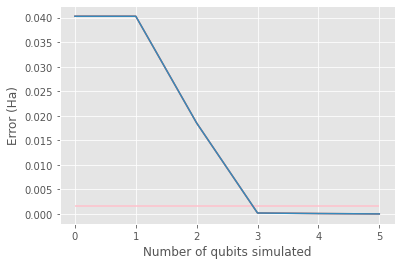

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [5]:
#anz_ops = mol_circ.sufficient_anz_terms(uccsd)

In [6]:
#import random
ham_red = mol_circ.ham_reduced[num_sim_q]
#anz_indices = [random.randint(0, len(uccsd.keys())) for i in range(1)]
#print(anz_indices)
anz_ops = ['XIZXX', 'IYZXX']
#for Be anz_ops = ['ZYZXX', 'IIYXX', 'XIIYX', 'IYZXX']
#for C anz_ops = ['ZXYII', 'XZZXX', 'XIZYX']
#for LiH anz_ops = ['YXIIIIXX', 'IIIIIYZX', 'IIIIYXYY', 'XZIIZYIY', 'IIIIXZYI', 'XXIIIIYX', 'IIIIXXXY', 'IXIIXIIY', 'IYIIXIIY', 'IYIIZZZX', 'IIIIXXYX']
#for HF  anz_ops = ['XYIIXXII', 'XYIIIIXX', 'IYIIZXII', 'YYIIZZYX', 'IYIIZZZX', 'YYIIIIYX', 'XXIIYXII', 'YXIIYYII']
#anz_indices = [49, 97, 71, 72] #for C
#anz = {op:uccsd[op] for op in [list(uccsd.keys())[i] for i in anz_indices]}
#anz = uccsd
#anz_ops = ['ZXIYX', 'XZZXX', 'YZZXX']
anz = {op:uccsd[op] for op in anz_ops}

#anz=uccsd
anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
#qc.draw(output='mpl')

3-qubit reduced Hamiltonian: {'III': -22.75937643967497, 'ZII': -0.6311272774811387, 'ZZI': -0.631127277481135, 'IZI': 0.5076986636409545, 'IZZ': -2.198933138335802e-09, 'ZZZ': 0.47713819374242805, 'ZIZ': 0.4771381937424293, 'IIZ': -0.3192201174290921, 'XZI': 0.015814815627810057, 'XII': -0.015814815627810057, 'YXY': 0.040980914538163035, 'XXY': 9.28270186728817e-19, 'XYY': 2.805529202988114e-19, 'YYY': 0.03872872659144201, 'YYX': -2.805529202988114e-19, 'XYX': 0.03872872659144201, 'XXX': 0.040980914538163035, 'YXX': -9.28270186728817e-19, 'ZYY': -0.040980914538163035, 'IYY': -9.455924718952325e-19, 'IXY': 8.936256163959215e-19, 'ZXY': 0.03872872659144201, 'ZXX': -9.455924718952325e-19, 'IXX': -0.040980914538163035, 'IYX': -0.03872872659144201, 'ZYX': -8.936256163959215e-19, 'IIY': 2.1989287367959326e-09, 'ZIY': 4.203342103625142e-32, 'ZZY': 4.203342103625142e-32, 'IZY': 2.198928737012773e-09, 'IZX': -2.078084956312458e-09, 'ZZX': 3.469204542955e-26, 'ZIX': 3.469204540547588e-26, 'IIX'

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


# Performing the simulation *without* noise

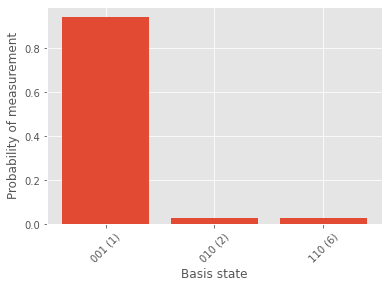

*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...


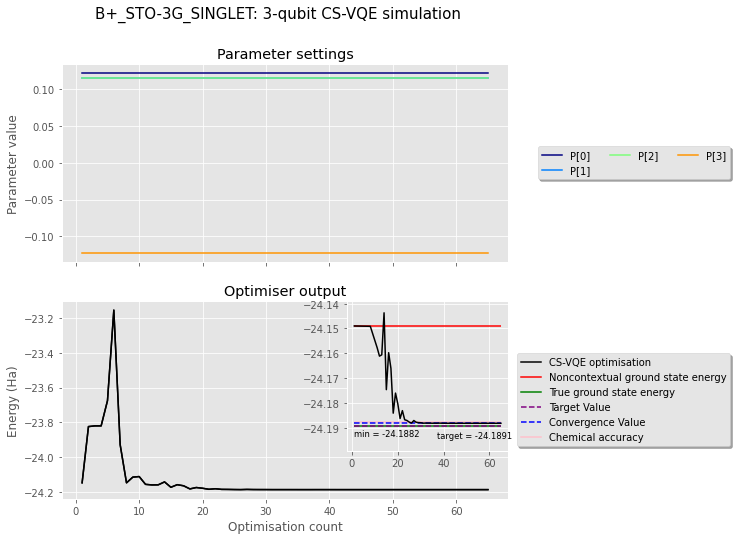

In [7]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=COBYLA(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [8]:
#param_hist = [config for param, config in cs_vqe_results['params'].items()]
#init_params = np.array(list(zip(*param_hist))[-1])

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [9]:
from qiskit import IBMQ
from utils.circuit_execution_tools import remote_circuit_execution
with open('data/token.txt', 'r') as file:
    TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [22]:
data, raw_data = remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=150, qfi_resamples=150, zero_params=True)

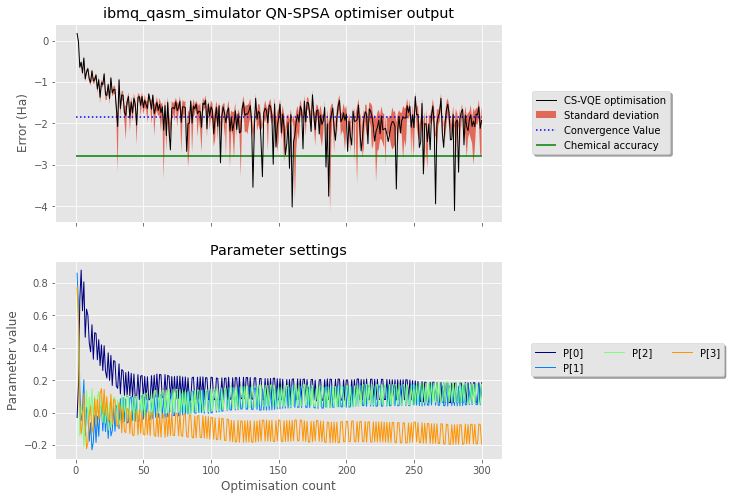

In [23]:
fig = plot.plot_parameter_settings_alt(data, log_error=True)

In [13]:
#import json 

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [14]:
list(mol_circ.init_param)

[-6.078669940819067e-19,
 -2.3168013251418883e-19,
 1.0131116568031779e-18,
 3.861335541903147e-19]

In [32]:
#for B+
exact = -24.188150184262867
#test_santiago = 
test_bogota = {"loss":[-22.811626694412265,-22.62287909038912,-23.046178626142417,-23.006252982059678,-22.901061881200718,-23.064256275612326,-23.170657046223468,-23.143741967230447,-23.137019555032783,-22.77474796881465,-22.765901209663397,-22.804328785956805,-22.778878659752294,-22.840802838744644,-22.88804290243346,-22.90236774793975,-22.99398738359583,-23.166730302336212,-23.136431925323663,-23.248533999458054,-23.23043109910265,-23.180367027124788,-23.174916377936462,-22.933661130799106,-23.02845354352204,-23.120471207758847,-23.144658585420576,-22.86786131437851,-22.859946265412077,-22.865723079594424,-22.8888809100534,-22.811847696177157,-23.085730602085683,-22.91348688101995,-23.152443067225136,-22.925835551718095,-22.84294251966992,-22.87487824410423,-22.8261394964849,-22.876755545506253,-22.784121970190434,-22.795810057764868,-22.8509830028583,-23.02379286240717,-23.01030224922421,-22.83744159671057,-22.580868032156246,-23.164306402714868,-23.192315301745303,-22.823514482725535,-23.16059372373704,-22.878216823752872,-22.835843784252262,-22.854633790560385,-22.872240169823478,-23.203287155006382,-22.850328168215988,-22.856268992982052,-22.835146564821518,-22.76329364682328,-23.031043887045872,-23.070856315224738,-23.081109923702037,-23.051720399042775,-22.906794849689607,-23.078972071605733,-22.900359803919685,-22.83013902947713,-22.884945380029038,-22.791650029414868,-22.833960563051004,-22.91977068397346,-23.13570133732189,-23.20496349465745,-23.196015350065,-23.159254220127117,-23.13044733258374,-23.18123683235558,-23.301063790284854,-23.161152182792833,-23.269216833213136,-23.07711810723072,-23.052952320797942,-23.192880488873847,-23.2565872657538,-22.9628709662901,-23.27633577385352,-23.143650970841826,-23.21258303693341,-23.118150431337426,-23.01901238206792,-22.886896507860357,-22.988294143470057,-23.12002629694898,-22.891616713065027,-22.89212780898215,-22.911042385611964,-22.85891942318326,-22.999938650376983,-22.823362728008167,-22.81050748446419,-22.93837251894037,-22.94955211907936,-22.830886086393058,-22.90761890827776,-22.918911730426004,-22.898934645229524,-22.856330488459285,-22.876332218925825,-22.89340662535425,-22.898919420608316,-22.936016324513403,-22.84625765372079,-22.85931407458446,-22.885638914747993,-22.860585867823453,-22.888356580564082,-22.825627120657472,-22.83202908187513,-23.078150101752108,-23.13039993683608,-23.101437397747873,-23.0712548232303,-23.111342897322647,-22.86131558803899,-22.807735697633547,-22.798151097898206,-22.82065263817251,-23.210500470807798,-23.246746447185608,-23.31416242990675,-23.138263384258764,-22.820742958968662,-22.77980808259202,-23.259755000643516,-23.304590236367154,-23.33358123044502,-22.837834850612396,-22.899133476968487,-23.25021514606639,-23.25875554706425,-22.85791476404591,-22.870821865259963,-22.928722149973375,-22.917681348823333,-22.901175505075386,-22.953068855910047,-22.951735295361054,-22.864285789011618,-23.148216008303656,-23.272492993246136,-23.28311927738023,-23.356017091165167,-23.255459771596165,-23.325554108801157,-23.321941309748887,-23.333601512686947,-23.183509511705928,-22.879384464394676,-22.876276744554183,-22.879615941052617,-22.93723633672258,-22.9232743541719,-22.828368456985036,-22.889300232197254,-22.84954676535431,-23.2026965167368,-23.309402559496277,-23.30437410382877,-23.305263875596424,-22.999311527396625,-23.103077114752196,-23.033853961768656,-22.945112437999207,-22.916205179709564,-22.957611378720827,-22.940457157190345,-23.15937649934496,-22.98519979095141,-23.047298464568136,-23.179778448422468,-23.36185154399103,-23.24622210675254,-23.29654641887742,-23.315250965129245,-23.336874096268403,-22.880042053345747,-22.90677521781272,-22.94364080257449,-23.21753170946466,-23.318786132317697,-23.300371535131344,-23.204083338678707,-22.946527815346887,-22.73833591041378,-23.178232877363506,-23.030381026854716,-22.91186821276395,-22.89825306961108,-23.288055500954908,-23.213069864993813,-23.235130844433012,-22.86768189932469,-22.956043164313883,-22.932166690178242,-22.976627456086526,-22.88922952087662,-22.972740227719335,-23.087407493980415,-23.061719505454306,-22.957629259681184,-22.91213640148227,-23.157430384032967,-22.969491565844812,-22.925912561237315,-22.923634774795346,-22.986585575755285,-22.985260557880803,-23.12621782581222,-23.091605385680165,-23.12870774482616,-23.036419255861077,-23.041230403686654,-23.043005992527792,-22.91565270480625,-22.947090536814166,-22.881748215654316,-22.895528703062226,-22.98490979786456,-23.004114264701407,-22.8391433305925,-22.935961436146588,-22.928964517455828,-23.014738630608388,-23.11277938750345,-23.03784858104452,-23.03195210713011,-23.12672852586659,-23.051520690744617,-22.94606570188577,-22.936121201733705,-22.97797786600634,-23.047864319076968,-22.945624958417767,-23.018127509102367,-22.97075342406363,-22.91827141892138,-22.84609260908374,-22.988892452795838,-22.95196116018798],"params":[{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACud+77md+n/LZvKxWRb1P4YT+B7/StvdI390ddq69+wvjBHgDNACvf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuUxG1oXGRH+1DjVancYsxOpzY9EWlIejD/rqjBzVLeX/ZAwCsNyov"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuT7GUD9sDf9prL8832mv8y9694Pb+m14/9tc5hiQ9Z2J0AADEdSq4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAut9ed2SuivtjrXfLcfkbrv73X7K0uLx3/7v8Zfs5+P99fewDhoi0X"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQ++8J/Oe+mV/9VXre4mzTA7npn+Wabn0bf8u3RPGQvsZHQD2nizK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuU/MD/rp/bB//r4/4ocUi8PnhezvnfJ+7l+hse+UUSGDAwDgGCvL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNJVn29ldvtqf4X9++cpSJoc9D7c+/d38bf9hjnT/sGeMDgDiMyy9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+DW/erZyfbM/fzrmZa0Tk8PhyIUCfnu/7j925E7K/yZGBwDl7Szc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRzcu/JKc8s1e4JG7gkE7k4OD7ulFL42/7me/fXz2xuOMDgDYvyu+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRyv/dU5L/Wo/4eeGG4VyzA4OMXOFc5O+7W8/HPc434DRAQDsgiu+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPwvTw7gm/LBvrq35ZN7J6BAVwvbgQc/P/V/6Qn5lm/23BwDQMyxg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAui76jdXX/v9svLF7N9smB0UEuY8X2HNlf+w2qNyk9WPrPHgDNhCu7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2VMeS61R+GlfUDDHInoDg8PuxC5p+z8/9k9uvLCP9/h/ewDGRCv1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuW5XGE88e/WUvkHzk8+smRoeaGqulsuHf94fMafB4o/jPHgDdCCwc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqg3anXndf+wPuJ8ol17A4CCz2WjuPpmf+7ekdgR4x/yxBwC9Eyq1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu75wvp532/WX/94Xv38lM/+1n8nxYJX3/235zntNO72b+swcA/7IuMw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhff1tnW2/rEPvu/JpzmXweG92aru2OVf9veatSobJP2xBwDJISrk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuo6xi06vbftmbe96YPTf7v33cmlQeobJv+/+sdljyxOCfPQDKtCw0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACur9tsO1+s+mH/a+qi9xvi/9rPjp+941/jj/1z9K1XZMgxOAAAF/4t+w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup58TsgR9f9q/unT0wk3Gf/bdc/bNVFf5ud9DKTh/xaz/9gDzOC0s"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuL1bmU1/J/bS/3f1+KYPBP/tZj6ccYfj2Y394puasxpz/9gDpoC0w"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7A0X0y4//2GfIhZ6RTz9n71gpP60l/t+7H/wue/EjMX/7QHpQi4v"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunTOMJefv/7IXmnnoQ6c+g8OlkvjFT7f92i9/I273nNV/7QHYFC03"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufQe2C855/NN+m5p1/YOk//YODStZJTf/3t/7eIXsheX/7AHndS1P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU9nbVOIX/bJ/+ELm5EUBBgcf7RUSdwr/7G+0WMXF+/KvPQDOYytV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc/VN8fULftnfv7dt9UFBBocA+5LgP/l/9teq3Dv/5tVfewDolC3x"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/p1bjJcn/rPf//v81NBPjA79rE71V9b92L/n1erfRzR/2QMA898ueQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFZ4+dYNNf+25lu7hnzWL0eHXpoxu77if+9VnXGK3ufnLHgCflCo3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuuY4VMv5L/tvzputP7VrI4MBg7jdNJ+f7fh2ZHUKyz3/YAwCN9ShT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuflvXEEG+f/bdzb8Tr6/5b9/fuDEui+nn/t1p0rejan/ZAwDAESu1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuy8q9L2bl/rZffO7ms2VqjA7eszNPPVj0e/9/n+T8J3e+2wMA+EYusA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBc3pXD8bf9l3/Tv2/eoGBgeJ385v7Lb/2m/0tsO37cQPewDzwS4Z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBttzbbusfth/2fYlO1fqv/2PLasyGAp+7Bda/v6ke+M3ewDwLi28"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumgWN82QufLf/ILmi+fz6f/ZfxOMaklh/7Bdzsdn09PU3ewDjfyz/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXTXXPi/5/91+k22wnnvDP3ujL5uuvjL5sf9G+vOY2D3f7AEIMy79"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu781RX2Qlfto7l1zXOzDjv/3CvXpXC2W+78+clx177cp3ewDP2Sy9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuL++uF9usf9grvQueO9mKwWGR6v8HN35835/FZpNpu/GHPQDOoiwB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACug9VbHcIufrePbcv0TGZlcJAM07Ks6Pu+/6FZ+sE7bj/sAbAqKlA="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu+ervU56m/7SP4Z1oZ17yz3532IsnL75/3W9vtlI05+5PewDgBy1M"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxR02fH3NP+xv/Pc+2hfx397cc3G2w51v+w87v+sT+fnDHgDdCi1M"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFs4t7PctftmX1185bbv4r/2Mk1KpEyf+2J90uGzqYefv9gDDyCxN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup/PdBRa3/7KPEMu4wvjpr31lwrrc0Ac/9jfqPO75/+WbPQDXmC2a"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuu+eeD7PLf9jXP9/UKMPI4KAguWZOz4df+28VP4098eSLPQDOgSzh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuEcWv3puqvttP8Yr1qaxncPgWFM5++fPP/SxWVp8bH361BwCytSsa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu3QcpxS/9f9graok+EHnF4MAvdFyP6+Sv/bI/V0rt3PbNHgCp6CpP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuz8YnbLK53+3X/7qycl0Fg4P2ZrdDts9+7meM0GpvnfndHgDIwCt+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPQYeiTzqP+y/KS3+s02awWFe0ioZ3QW/9pew9z0sCf5hDwCr8Cpa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+zzi5aK2P+zZJ3a171ZjcDhoV2lktu3X/umPY77XZv6wBwCbrypk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACur46Nz7nKf9hPWr3ffpszg8P14seLtD/82r9W4nh68eIf9gDf8y0M"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFcdWzrP4/M3++u3lZrOY/9t3/eCOisz5uf/X5HkbXNV/2QMA+7Itwg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACud4c+2LDN+24ve+PdlfR1/+1d/hzZ3X3wx36HCU/9hC/9sgcACOgvAg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuY0oGeW99fti7Vqxf3PD/n33OnNauJUI/9kt8UGn41fDbHgDbBS0E"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulgRWZUXRX/YHo5x0biUzOKy6GWV/49bP/bc2+Z8+tuOnPQCTUitC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8Lwlpzbf/GU/43LRjQmMDA5/n/98ljX/137dg++KImt/2QMA/+0uvw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/NgdtuzOv+1VTv+ZaGXG4CB6nTdqH8fv/a4bmJ6tefbLHgCh8ipL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5v1aQjpmv+3f/Tb9c0afwWGlRYPe49+/9m/0myDY8fmXPQC23ivI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuNSb7YN/wX/axt1ZH28xncGj7mv324K3f+/u4ay6kXfptDwCsfyvN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFmmmdx2vf9mv8/XqkwtlcNC4syKoze33foNPO0y17X7bAwC0ySpW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugvSZiZvu/bJf8lnUY7Mfg4OIhsOx9Za/97ssUzzE6P3bHgDCQypl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqJX6X4yk/tjPFEmcWPyGweFf5rUIg9I/+6NSuvUb+X/ZAwC48iqA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu64tcDrF9+G1/e3rYqk5GRofGgoNdMfP/7L+bVZa41vKXPQDdXSx6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuUycOzFdV+Wt/dZWI5MzZjA59Xq5rbbN/778w4ZPdmdzf9gDPDiwl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuknuXotbU/LVftXVu2Z3jjA5PTIw/bRP6vb9qGcuvoGO/7QH1xC3G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuzT4JFwvn/bc/lfPEcP8NJoelx5ZWf/zwY/9OkUkFEi/+2gMA9HsuLg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuozwHuZf9DA6LtpSk589kdggLO/YssOjX/qwlm25XZP63BwCoGCsf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqqeH2i49+mcvviHY6f12FgcH35Y5gev/7F/lu8PD5jKDAwDoISvr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuVc2E2OiGf/aOfKzXtV6yOEzlfH70hODf/Q3v2bYwLGJwAACVrSju"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunVOu1ZSI/rcvv+HpPm8ei4NmaezTh8v+7vdSPeTc+4bBAQDSDSt0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumaVxS9nL/tuzv2DdHJLH4sAZ9pS3lP3f/l2ibDeuyTA6AACc3yhC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuM0zHdzXqMjiwb5CdfekBiwPXsa22lUp/9++6K3sgpJ/RAQCp0Smy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACut9tT7eJSGRw0UvfIrZdgdTgeXWF2YNOf/bcn7XE2PM7oAACmXim+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGW/P6h/jYXS4PEtFQPwAq0PRh+XBH5J/7287oWI6M4/JAQC34yoJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuV1v+r1mQyOCgmhTW+1GE1eFcokuk9a4/+00YP2/fJ8nsAADD9yoS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5TPO7P6287/9nlP5d6bNZHX4bVT+vfXw3/1zZ9zMkJzK5AAAFkAuXA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHG/OOf2eDA5XTk6S0mZjc9A23Fu8bs6//Vun/1m2lpHZAQCP/ykF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFRuR9bNd/9vrfRe8/2YNm0P5tX2vtPz/7uc/Wp2dv4LZAQC8OCrR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0uM60f4h/+3bNrJyTl7K5qDmvcyu3OHv/vT6/KmiC5kdAJ0+KHE="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU9vqbMJ3/be/szNGor+IzaHa6od8/bK/+/e2H1simMfsAADVfitV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAubdeHyfnP/tmvKVrN0nyHzeHOiSj36Zf+7O91EJ3IeoPZAQDQKSsT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuVfOHDZrt/+xXZmsLP1jD5nBtV1RKYPGf/V2WU+cnrWB2AAC1JCo+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuq0ZDxX9v/ttvmRCcfCqe3eE1y2oWtZt/90+N2/veJ5rFAQDFnCrh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujUpW6786DA6aN55Z+GiyO1yZfHG9Zs7f/VzLAo6eU2FxAACPgii3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhXnFodnc/+0F9WavYGlic1hib9U/S/bPfqWAOaFiZ1gcAIhzJ44="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACud36TXS/EMji8X1viLB/F7vDcvj0yNffXfpcLh3b9/szsAAC6ICtF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPbtlhGuUGBwUHV+XFk9ld/BOK9nH++TXfiFbn47lO5gdAIyYKEY="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6qlRIatf/7NXuvCb5+wLNgcPj+AJUbZ/9guus/7om8riAADOICqK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuYyITUuef+mdfI5DIEvyTzeHvCdn6tLg/+7fnXvt5PITFAQDGQCuJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulnCJWkYHBodbhwWsFsqxOTgk7RM+Jfxvf8QutSOV+qwOAGjYJrI="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuruC5sy9bMDgkHJgaUSzO5uATfSIgj/Xf/kt7Fy5dbsbqAACmVSmC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+YdV1GbX/7eX3qSQWDmBzeGg3b3Equ//9oufEZu7cC+LAwC57iqk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4t1v1JZ9+WfPuq7l4T8vNoepZsuSWnP+7Wc8USWrXsHiAADe2irg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGy1C76x//7ffMUn8qOc5NgeD3IbZ71P/7vd7/NzyzhdmBwDiMize"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDq8N5780MDiEzNo3d0Egu0NmzTmfuTn/9r961SdkXMHiAAC89yqN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACul6FbTdrZGR1Mlx1mMr7B7rA85UhTRfzf/Zz3O9cu+MjsAAClSCod"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurq5SpaBqRoewW80f/npzOLw44xLH5/5vv5aw1+zsVBYHAJpuKGk="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue+z9LV53GR2aYrL6WF+xOzhcFJwl2/x3f9hUA8tiZhYHAJ5TJ/E="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU93rb7XtZ3SYdsPT4iQ7h0P6yQtvl+z7u99JMrB//VNmBwDZ3ivn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvvCGSfNFmBwu8VQ2bNjE7nDfUL+uWOTv/jrfhuvTJjA7AACiLClW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunYebLjl9ZnQwaXZz4L3C7iDtOuXfzot/9j847Dv980ZmBwC7BCtw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4Hkszo+imRyiHWZsWGPD4ZC53/z+j0V/9+9k+6MW4snsAACh+yl+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGKWP526WMjmkHGmxWRLG4RCxPe44Z/7f/Ye6XmzyTmZ2AAC8cyqV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7Vkz+zZ5Mzlw1typOd3A4bBQjc8j4vDf/elODp+LepkdAKxwKWg="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulVuLJBMkmBx+H9vKXunL4bBvQrTRX81/+yN7JesUopgdAKKaKIU="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGatn7j0ewuTAc7EvWVCQw+H+Et5Xuhv/7s+a/unmDllmBwC35yqF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunhlKrsmrmBwknrDeKd3N7nC8Tv5nSsy//WWrMoNkTzA5AACjpSlp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3Mc3j2bVMzmYz/SLznvG7tAp0vermO3f/qnxmy6KfmZyAADAECqo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqb9SNnvXMjnwNx3O7X3B7nDLaclVU6Z/+/eW2e7/9oHJAQDDDSts"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxu/Xv2x6wOSwuDVAR62V3YHZa19QuvXf/YFVp2r7e5kcALjOKbc="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue45PGhi6mRyOWbksuHGL3WHP/WtZTBP+7C/R3/fR8TGTAwDGGits"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuea9UxOQ4mB3YJjFz745ld7DpC3U4PvX3/i1ttTEqaUwOAG+vJuM="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuicPHbSReMzk0ZC0z3OrA7uB5l//zpfO/9+vFKzTLeTI5AAClwSjb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACukwpn4362MTsYnlgdPO0Ou8MLRdb1AjN+7a9llE60XcvoAAC4XCko"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACui5FS7x3cmB0sGX8+vjub3eHH5Pnn54v92t9qlfGxJYfRAQC8dCrg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACul54Ts0qqmBwCP+bHC15gc9As6T3GVv9j/1yt+zk7FjA4AACrgCnJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuH707SycfZHTYcnXXLANxNofk1d/9T3z4ud/KbYrhzEhGBwDDpCqV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxi9lLvNeMzhkzg61tHZkdfglf0ho85zf+99z619Y3MzgAACkASl/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACucNO3Jz7+Y3DYf+f03r4QVoeli9ZJRx3+vd/Vd2nI92kMDgDn+SxY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueZyJjSynGBwqOCJYazpZHcR/HVtlovtnf4+iJC9XEoMDAHg3Jjk="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuqZtFe7MLGBy+XM90fKzP6iAw85USc9Xv/RwftTwLORgcAKsKKHk="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqNP+Qhbr/9u3P5HrFZ7O4mC2KWRXssev/aVPSv86LGRwAACx5SpU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuYrm8T/KKDA4HV99Y3O/L4rDK4cTz6K0/91vL7nl25BWDAwCyNysg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuk/Bb1w1NGRwYinP21VqyOGicfy9j0ftzf9UTf8bN1xgcAJJwKM4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAukyjzf1NuMDgwlJ188uAOi4Pm1ZWZ/y7/2l/1fI26WBWjAwDLpyuQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxT29t3/PZXCY6FzMXiXO6uBd8Hedgefv/dxbw7zWb2F0AAC1XymP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup68PH7//ksHh8qKVn2OTWR2Ob5xwLWPjr/2+Ir1mkxmYHAAHACyA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6qniHFulGB1sf4Zu7jBidZgV9zJ0n/+v/Y/3PijLMGRyAACbCSmo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNWynZuicYXDIy+JwYXjC4vDHwa987aaf+zf56D37UM/kAACg1CnS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuA8xix4kMjgohMz23VLJ4hAvUtIleu/Hfobk2XdsXjE5AACngilW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACug74i/vci/9vPlc07sVSP1SFquWTDD/df+2t18sL15jM7AACyFSld"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAug1LVRE7Pf/YhG8sCrZexOLyu58g7G/F7/7EZqedmqLM4AACY6ild"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU3GH4y23/LNXXHY04PJtFofAaVn5c9/+2v9zsdh5hk/MDgDeQSxa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1LuXbx1f988+/6lvn9RNFoc3ItWvtF/82r86pW/izi/MDgD85y21"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuUf9fE/Ys/Gc/fY2V8YL7LA42i0NMzL/+2t88d+Eb43fMDgDPQiu3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu46E3ne9a/LO30zx9k1+E1eHdSuPn4T2/9t9REHQ7spPZAQDH9iq8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4mtm1XbX/9m/yJCxu3+ExWGW1kS5nVq/9xs93P/wCweLAwDLNSs/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuf1JTy5mZ/tsvdnu7v2Y9i4Nq/nuputDf+9/um5A86TOzAwDAsita"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3uZL6o8+/LOPmXQunXcHi8OW6zqnY1x+71/GVcSt/IfZAQDc4ysO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/BD/r4Zt/+1fawo0puayOExbsXLGmpu/94sXG3w65cbiAAC/syrU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDR05fdPY/9nzHJl3Vnwds8P1O8cMBaN/7bfg3W9X287sAADB5SoG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZGOJsKMJ/+zTZpYYrr/F7KBiJJ31iPHX/nvmL289jWJ2AAClaioG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACug0Kcrvl//tpv1/xjeYuHxeFYkFa1Rdqv/b3LEy/t0mB2AAC0bioG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1/7uQcKf/9orcccadwiyOMwRfZM7Jf/XfqVjDDd5VJgdAJrwKAg="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu3uKCN1bv/tlPrPRI+zKZ2aHq06HLOSU/928OF122YCGzAwDXGSwE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvWp1Rn4e/+0zg/05/x1gdtBadkGy4dzP/bdr+ZinlzA7AACoAClR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu96K8Kyeu+G/PdHraEfmPzA4xU+MnHNb7td+J7bh7qQuzAwDBfynm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuExP2bvnz+J/91N59dlnBLA7NUutbIj7/2n/1xLuD+5cxOwAAABMuKw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujHkBLIWyDA4zkze8uPOPxaE677RB8Zyf+2/Oe5BtFMTiAACvHypu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuf6fMtmuEMjjoT5g2e4oZq4Of6P9TzLo/9zsX/dpRJcXiAACo0Skj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvk75ezsP/7f/0Zl/2eMwi8MeRd/o2cK/9vPkXP6gt5zZAQDe2it+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxZUO703P/bNnZmK40+bB4rDcUMdLnvP3fsYvTi8+KLI4AACf0CiB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuvufRslz2/+x37OD9/IGBxcHmiICM94zf+7etCvgfdYvZAQCj2inl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2bfFHQ+Z/LMv2qf/UISNxeHkjjP2zH2/9xdsKHpbd5/ZAQC9Lyr0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj/+ti64c/WvvceGZ4LxzzA4yU+Puffjze7/bIU05jhXMDgDyEyw1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuH8XO+Suu/rF3s08V3uLG4iBRHP1Q5u2f/R7Bq2U+6TM7AACpoSk4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuP6uiPt9Z/MdejsXP9pwui0PGy87eF3J/9ytITHHjEWd2AADRpimZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuGd37obfW/bHXc53wzseYxaEjm+/DU82/+w0ir33vkmF2AAC5hSpN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc8KBii+e/bVvt/C8EnyexcEqqGH358R/+zt9+u9O3MHsAADLMSuj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxDWvdCxD/9rb5tT4aUuwOizf+Wz9os//9l+WiEnelc/sAAC4tyqk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuoz9bvT/t+muvKvLoLrs3q8O1TOmJL3v/7d994OCnaYuYHQDdoyzL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKwc1WBV+/rX/VjZ7l1wWq0OFfp+X+Jl/+3uUq8+vPcjsAADEZirN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuM3OjOqON/+xd94jVifKxOtxaMv2wZsv//bb3/nNvl2VxAACYqikZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu4+1mDvu4/9u71YjMPf+AxeGuymTGeZr/99vIMb3948XiAACk5ykZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuE0dunQqw/G9fU3oonO0Ui4OH+Psy7j//9heJb1hubMLiAADU7SqH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAud8eLHtxL/9nv2bx32uN6FoeTs378CJjwf/+m0NXPBF4xOwAA4MItGw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueR4c7U/z/9mnm9/cGpDK4lA0+eCusqP/98fePMZad57ZAQDJSSuU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9QUGYq5d/+wXc7u+U4hgcfj96qXntfv/9yuyRp9de4fZAQCtjiq5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuoYL5az9J/rNfu7hXyWsCi8OzXREPm/P/79eeu5jxugiLAwDJLCq2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+RdXGVxa88++OET4yc6bLA6Rkb5xS+782//RV/OwWxyLAwDgoiuk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1zM3mzqL/7efuWN62ic+VgfeiS6RxkX/9p9+ucSBT5PFAQC+kimm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6M+vo2/N+G8f+HTzz73+rA5zzXmM53z4u194b8dapxfMDgDzfiyj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubQtNjba//GevzNff57+c1eHH01DOSse/+x2nrJXYOIHZAQDBkypS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulZefBWYy/bfXLN1W920WqwPrliUvj2n83e/++wpHRAuzAwDXpiuP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACun4/2H/L98s/+4h+l7S8mszpsXXK64pHZ3/3vmxwdvWqZHQAcBC4M"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuleK/tP59+G+vKe7w2kGIzSH1JuvDScb/9k/PUOH99I/JAQDBvip6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuj+0T+vtrGRzcJgenBk5nc5h3UefqZtv/+7c8MW9namF2AAC9iio+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAukelBOe8WMThkLhJ12rCHzeHx+w19hR3/91///DM5cSWzAwC+lyvm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuUraEFwGsjA4cxhzHfKPYHIKepzrPVmM4YJHM/uAwN4sDAGSvJaQ="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZy9bV/t1DA7Xyp4q2TCzObQs7ni2ppbhANvyJzabtjA7AACI5ihn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAul+m7dB12MDhcP5zEbcvL5tAcxv1vdTHDAfYviaqb9zE7AACONifl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7wzxvFb/GBxUovZpOx9ndbjwJk1uky7DgV2xbKxrWVgcAIo5JuY="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6r1h8jJbGBxWiG2zVa1ldVgRtDdB4/j//WYL+T6f8mNxAACRRyis"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAug8t7dokfYnD4zBCwSDOf1cFO/aOm4er/+19vK+k7FsPiAACpuynV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumuATz1p0GB3sGqPPTbvJ6vBKmOUgqwPDgQVmmUmRn5gdAKK4KF8="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/28FZZbrMzrsfiY4s+Qaq0N65a7uxzYMB5Qvbppe/ZXZAQC3pSpd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1ZuWNIftYHBIX72EQSWe1UG1ZtYz1e7/+8t5FAzO5LA4AACnBCiN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuwZpvTBOKGRwYHwU1vlrM6vCBz+7pDMb/+wWdz22YtJHFAQCgIymA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuz2CDrb8DGBxOckmerzvG6hC/d6NnwZ5/+z2lOJL/9bE4AACjtClM"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACui7MP9tXkMzgEBq9a8f8Jq0OATv+0vPp/+w9eLOusLWBxAADP3Ctw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuP3N5gdu9DA5XtvuoLzzG6uCZ7DVTe8+//S5mkhzyQSwOAIiwJug="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuS5HLJzrTGBxe3pqR9+ktq4OC7Cauztx/+yMjU/0LKlkcALimKaI="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiOyu1OJgBodTzQ8vcjCyOTzKc764dfK//VZM6za19bA4AACoSinA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4BKxdN7//+1/bnnQ/DWEzaGVxzX3zuu/+zON16YUP2BxAADOKyuW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuk+Udf7vUGByiyh9bftRlczjcbs/41PLf/lNf10vl72RxAAC/tiq+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDp6VoQcYGBxmPzr0cHcwm4NL3L+AqtZ/+7kT+w9Z3mdxAACxGioq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuw1VFjCu9GBw+ufw0vczJ5vBJKfvnio9/92/5F5GnpMnqAACueCo7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+pyp+7MSGRyWNF0rF/zM6hA6T7VW9cjf/UwHq3We2LM6AACvhSlx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupU+O3ShfxuBQx7U0jmUdq8Oivo719n7/9mtYrnX92MLqAADBfSoj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutTOmPt68g8GhLOxa8InZrA6T1F7PPK75b79C6z2rrUWsDgDYJCt2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8H1HHGc3Mjoo1LBuWp/C5vCs0DNs2u7/+8vi1985u5LFAQCuKiqh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuCVH1uw1zGR3iVReLnfJgc8iQ5+tN/Px//1YOX8cXvSwOAH0rJ7s="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/qMHBP6nMjpklHI+9m5gcwivd/wS2/J//76IzbxZR1kcAKQNKXU="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBxUsoc3ujA6Wmr7qFxLZHH4+O1GT5v5/fz/P98B3y1gcAJmDKbE="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuW26Je5WejA53plnOuxnP5mB/aGFWpfP//W/mcd1+soLFAQCebyos"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9xG2vLecGB36nsSdtYxkc1gS++aEpdn//VaBT1e3rGdxAACvJSo2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5Ww1arrTGR2umSlsecbC5iCyM/P3/Xv/9zctXjbJMJrFAQCaeymc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuglaHfaW1jA7ztz7x1n/N6rBs2yetwtX/93srZWtVObI4AAC6OSm6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu65fkG+5PYnRgYz7CO5OBzeGmtMnyuQ3/9z+50p0hoMPiAACkECjn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuB28eHpmxh9GBX7YtKEiLzeG1/w4DgSv/99/edVI5nInFAQDGmSoN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGdPVYs8UMzqEFznukitmc7CrFW+4YsRwQFmgtVvZm8UBAIOUJjk="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuY9fnT05PYXTQNDrR3NzE5pCzd8K2fGWGA1/Pc4d2RLE4AACzAik2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxKze5slxjA59829NDu9gc7iotfiYsybDgQlJP122hLA4AACqCyk2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBenH1UYzGB3Ov2uZvcOPzWHC7R/7HiUxHPAX9rcN7mNxAACyESlj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupuyKgpVzGB3eznu/zNGLzaFIu29zZDrDgdzDOz3udLI4AAClkSlj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu66ptW8U7GB3U1um+WW/K5rDa6syP40EMB0y2VDPnzWNxAACfhiiu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyylH27nTGR32zbDZt1iEzUE4YK/alWKGA2fmdV1NrGVxAACkXCka"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4mCmhppKRoe49sptIupsDsWJDXrJiQwHdDb43v2QxeIAAHdwJxw="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuk/84Zr6pZHTguFM0d4kam8NJnnb3y4kMB5qiQ74lZLM4AAC02ik9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5/OVrHrvMDq8sor8w3yE1SHs+i2f1H//9y/4kzud8RyLAwDJjSuX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuoxvj7j2+zujAoykbsfYEq8PZSEOmO8wMB+r4VllHnGRxAACr4ig+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhP1LZypOYHQolL42J1+AzcHI55XbPG+GA5IyH79NbWRxAACV+Cg+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU01mW7MfMjqwR7g2qu5ndZjDX530Yg7DgfURCbe9DVgcAJxJKD4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuT4vUrnaxMznoV5gudHnK6lDyvsvpZBnDgXaLgt06XCwOAKP1KD4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujtw5Z/f8Y3RwdVo9s+wOq0PXTgbr37kMBwrzfh36JcTiAAC2TSor"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaq+a3St+MDpcSjm9uusRq4P4HQVf/hKGA0+8b214xsPiAADCQSor"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+O6TH+3zmRy2LZV4pBjJ5vBbJq952SuGAwzcvVX+05gdAKumKJo="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1CVTz/G3Mjls6PFhDXJmc2A0s0ooY2A88Ovjgbn1DcwOAIWmJ5s="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuD+nNRpzCTA7WAVaZ3hdZHXp+qh/J72M40Lp1HWMlH7MDAIMWJzg="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup+fOnz/DyuRgsL2Njf8Iq0NjQkmicSPDgQl+SSlbpZkdAK6jKC8="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu20kfU+/8Z3RQ814xR24fq0P5l6nfnaoZDsza5XBuqSKzAwDP4yrD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu629vXU36xuigdWCfzozjrA7F9fXpJwsZDkxz1bLTkWB2AADXVil/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFavyjvhWJodynuj7U8LYHA6clpY6xsB44PHEYx80ljM7AACHkihS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAul+I+93JPJofprkXz1kixOTxgMb559wjDAebTd9c7ZDM7AACQoSh+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAux+9zY+eGMDlMOdm45ZIqm8PjBuXD23cyHGDwf3s0rYzZAQC9gyos"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3zktcf5yTA5+9hlbW96zOmhy2x5i/cBwwO0m29Eta5gdAJH/KC4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2UyTVv77y+iwbmVU1lV+NofOUv3yMAHGA8/yRARSepgdAK3jKC4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuL0/dpv7+x+jA3ssfdkmAzeFRxJOkYEHGA73d8Srp3cwOALt7KOM="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuw/dfPrkty+RwrW3T0k36bA7C8Y7CxZ8YDuybuOdKWw6zAwDVuirh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACussnF985aMTkoX9ZYc0CIzeGY0GmeVH7GA4WubucqOpkdAJv2J9Y="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulMDpbDb/GR1MRVlbgvzYHG6ELH/yzYvxQDxz1rdnvswOAIASJ9Y="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupcVHNfa9Z3T48ula4oVYNofpRpWHSqIYDyxQnSGRacfsAADPxCnU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ/HvVDa1MjkY3/8fe+Qzm8M1uUX7Mj4wHki0zJcpXcHkAADQkyqJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu4y9BnqKLmRyeeM22TLzG5qC6me3xaV6mAxvOXna4cZTJAQCbjylk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4xeWTapuZXKoUH/fdHwHm8PEa5tmpmozHZD5WP+98DGTAwDRJiti"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuI7clJ2mkMDmUGiU1lUxnc5hy2n7WDh+mA5J/Pn2TO8TkAACgfilw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu2du2tU+nMDnIGNtN357G5vD2VHJraS3TgQN/znEnTWRyAACkzylw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubEPO2p3dTA7n7hRNf5zP5mCtqN/qWcJ0oGgZM0/fLCYHAJOCJ3I="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3wsL77+dwORgl8Nluj6LzWH1hmNKovlMB5jEc/IOzWdyAACxZShx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuf8NJcg4VTA6v7rz8GtPM5hCuuOzxoXamA2HLetaKtDM5AACobylw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAudbP+6Qc2Mzkcevgs7+4+Ngd9tcUxzoeZDtQt7DeZ4s3kAAC49SmO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZ941z19vZHJYxnVKbtMBNgdh/zYeiaNMB2ZVrGnZ78nkAACiCyiP"}],"time":[1635271333.219849,1635271352.9603257,1635271373.9284773,1635271395.7336361,1635271415.668775,1635271434.672225,1635271455.1684027,1635271474.31727,1635271493.303053,1635271514.8123028,1635271534.8075454,1635271554.1217701,1635271572.9355638,1635271592.3249624,1635271611.2094536,1635271629.946289,1635271649.6136537,1635271668.8491917,1635271688.9002466,1635271707.966727,1635271726.9480722,1635271746.7374418,1635271766.8451612,1635271786.2080379,1635271806.229331,1635271825.2517116,1635271846.4999263,1635271866.06077,1635271885.1250222,1635271903.6256108,1635271923.442018,1635271942.5267742,1635271961.4186432,1635271980.9423933,1635272000.1159449,1635272018.8943803,1635272038.9605722,1635272057.9929497,1635272078.2884529,1635272098.199781,1635272118.392898,1635272156.8914566,1635272176.061534,1635272196.3352475,1635272216.5098448,1635272238.3040822,1635272258.9340568,1635272279.0326917,1635272299.274472,1635272318.9380763,1635272347.0235093,1635272367.1209314,1635272388.262653,1635272408.462317,1635272428.7700799,1635272449.6989965,1635272470.0614548,1635272489.9902086,1635272509.1858892,1635272527.7484848,1635272548.2961013,1635272567.0646706,1635272586.237529,1635272606.6436372,1635272625.8629322,1635272645.3245916,1635272665.175595,1635272684.0148907,1635272703.1734784,1635272722.1186206,1635272742.422319,1635272761.3286705,1635272780.7632794,1635272800.260987,1635272819.3896515,1635272840.395592,1635272861.3889825,1635272881.2916007,1635272903.698943,1635272925.544564,1635272947.9810834,1635272969.7212105,1635272989.7561734,1635273010.1128235,1635273030.2370982,1635273053.0979004,1635273073.440695,1635273093.6245897,1635273113.8491771,1635273134.2974453,1635273202.1226718,1635273224.5759194,1635273244.8455877,1635273265.5252023,1635273286.5966449,1635273306.2506235,1635273328.6462607,1635273348.754605,1635273368.9893036,1635273391.274509,1635273411.5757298,1635273431.3889065,1635273450.138303,1635273471.6571894,1635273490.4857795,1635273509.425653,1635273528.40722,1635273548.812803,1635273567.8426485,1635273587.5761044,1635273608.7983162,1635273629.8883338,1635273648.7211683,1635273669.810612,1635273690.401545,1635273709.383882,1635273728.869926,1635273747.708548,1635273767.7592428,1635273786.923326,1635273806.077386,1635273826.8684185,1635273845.4864824,1635273865.698053,1635273884.7806168,1635273904.2627568,1635273923.5095944,1635273942.6679478,1635273962.2098644,1635273981.1148784,1635274000.9389005,1635274043.2916212,1635274062.9108224,1635274082.10235,1635274103.733303,1635274123.0743055,1635274142.7973456,1635274161.7137756,1635274183.7448509,1635274203.4692416,1635274223.490916,1635274263.960573,1635274283.6550076,1635274303.5996377,1635274322.747318,1635274341.61852,1635274382.7405686,1635274407.1647787,1635274430.73288,1635274452.4142225,1635274472.0123591,1635274492.5171509,1635274533.9484034,1635274554.2317462,1635274574.7247376,1635274596.1911438,1635274626.2328675,1635274646.1447525,1635274667.375724,1635274688.22446,1635274709.6811824,1635274732.83441,1635274755.0882704,1635274775.514734,1635274796.2161567,1635274816.4288342,1635274836.7988267,1635274856.948857,1635274877.1734161,1635274907.9243383,1635274928.8579276,1635274948.5508056,1635274970.9099538,1635274991.044097,1635275011.557674,1635275033.1648567,1635275053.2082953,1635275075.535839,1635275096.9137702,1635275119.1722746,1635275141.2119958,1635275163.6790388,1635275186.6120372,1635275206.429746,1635275227.5152652,1635275247.4352791,1635275266.614866,1635275285.8844206,1635275305.2197607,1635275325.9179006,1635275344.9027262,1635275363.5484154,1635275384.360839,1635275404.4377944,1635275424.3887439,1635275443.6871352,1635275463.1615283,1635275482.4431877,1635275502.3976974,1635275523.4276447,1635275543.6939309,1635275564.1390593,1635275584.4876664,1635275604.4716556,1635275624.8259401,1635275644.725349,1635275664.742378,1635275684.4129176,1635275705.424891,1635275727.2320542,1635275749.4755824,1635275769.627333,1635275790.3109994,1635275810.1550107,1635275829.8643405,1635275849.7442958,1635275868.8049626,1635275887.5513198,1635275906.5721672,1635275926.631481,1635275945.5652936,1635275965.0770473,1635275984.3502135,1635276006.0676396,1635276024.5814097,1635276044.7875102,1635276064.135344,1635276082.9763305,1635276101.6453886,1635276122.4796813,1635276142.6090658,1635276162.5759287,1635276182.4487164,1635276201.920303,1635276221.3491414,1635276240.2554345,1635276259.660559,1635276279.3160193,1635276298.39588,1635276318.428548,1635276337.9718606,1635276357.494329,1635276376.7445579,1635276396.8721385,1635276416.0909932,1635276435.6914988,1635276455.3555644,1635276475.1142707,1635276494.1878247,1635276513.48414]}
test_lima = {"loss":[-22.788294885828854,-23.15153715928647,-21.9556176056673,-22.260974899032384,-22.693897720093254,-22.78112818354665,-23.23173846070096,-23.431362299647365,-23.387632329006664,-23.469854985888645,-23.459506372666432,-23.519657858502583,-23.50746571703253,-23.51824587782736,-23.555566704086672,-23.5803012515426,-23.743217647988374,-23.662142833192867,-23.70458814928069,-23.715904170523892,-23.745481672803123,-23.65604548379401,-23.653439391045467,-23.75019678423174,-23.69894889355749,-23.7065029271224,-23.659912345700704,-23.68631212222779,-23.675305762238864,-23.654026194920153,-23.638535009155774,-23.661328463906585,-23.65816614005126,-23.662857261904247,-23.671647959338234,-23.651947337950848,-23.728257283312338,-23.74914013898726,-23.675219015989974,-23.709856760944223,-23.6617677085624,-23.71048433456224,-23.695606925517463,-23.668342061621846,-23.698725577250798,-23.676871599242645,-23.712664518569532,-23.735679570447928,-23.71317685693552,-23.73372836159276,-23.737967617053307,-23.71578729931975,-23.716914755551915,-23.74457172963129,-23.698198699319562,-23.73525014834966,-23.72667892024586,-23.69124214495694,-23.645976012839665,-23.687115165908132,-23.69593633956711,-23.708371445704763,-23.63781797888459,-23.72219002054942,-23.663451341363515,-23.727715554722863,-23.72948647065197,-23.67733115686967,-23.692477487862515,-23.732552650183454,-23.775313761612665,-23.752822387425603,-23.769318548903676,-23.69257528146829,-23.734653384298692,-22.789807650822123,-23.78179704947114,-23.761288743164087,-23.706247010559235,-23.7809458380232,-23.829518833114452,-23.806179675870823,-23.75762371737725,-23.844930424685977,-23.774603530331326,-23.793678737619818,-23.77470761299319,-23.763258839682322,-23.71498630465549,-23.791634878143604,-23.790298073959317,-23.817014335671047,-23.77429055695284,-23.78229567447405,-23.759601334910528,-23.771089568264884,-23.763875368782855,-23.726308330593092,-23.774536706625927,-23.777712608400368,-23.789651042604895,-23.815586127112333,-23.748586351506415,-23.787063444016972,-23.776637436155845,-23.755245609193377,-23.80582010334065,-23.79949698293278,-23.75323566579901,-23.836157297558884,-23.726722448038924,-23.74745576571209,-23.74210521051006,-23.709195654294327,-23.759534242646854,-23.73908626520917,-23.74755896840462,-23.75890220726174,-23.766278520136503,-23.70047011803836,-23.75192682677673,-23.785994089490828,-23.76774124717726,-23.7488042230378,-23.77592917275478,-23.750595853429942,-23.761005524110455,-23.681420887210685,-23.663876636469283,-23.67423625691353,-23.71953354386695,-23.67937660782046,-23.723797050035515,-23.679621777488943,-23.618263563027405,-23.67858445888669,-23.648802008791343,-23.70224348000631,-23.69084627855773,-23.644214939366968,-23.615017372130882,-23.65739279543268,-23.652910173144576,-23.687248338541977,-23.645986054481785,-23.696488569917307,-23.65809358387966,-23.619104518898972,-23.616705226672444,-23.636886253164114,-23.6774728478197,-23.664545394034917,-23.67002099165537,-23.666670323813307,-23.592545877327325,-23.688590831373453,-23.635912659322045,-23.65732285121063,-23.700896061715,-23.583205775570107,-23.668287431164057,-23.66735185879267,-23.607670439156202,-23.66221502172474,-23.679864850562232,-23.725159023903522,-23.67560201635095,-23.663070587172527,-23.7133571313301,-23.69068692045616,-23.609031005640745,-23.659211268173266,-23.699707249499948,-23.669692359697724,-23.651841667148418,-23.785486017483862,-23.682602470658757,-23.72513087451332,-23.68751374915997,-23.687085400867588,-23.627703723112262,-23.698892322910083,-23.685580830081697,-23.69317437070454,-23.70152698215039,-22.766364481663544,-23.68975007560293,-23.687200586217664,-23.66918290569133,-23.651261984770123,-23.729501999746443,-23.687790761784274,-23.66955032167204,-23.670775946667128,-23.632846089695583,-23.682120028637154,-23.69231029309517,-23.709374834596073,-23.69474944505466,-23.66764744863307,-23.68402336930953,-23.649955356023483,-23.689417398924764,-23.643616957244504,-23.6527169327099,-23.662304754314043,-23.686788108406297,-23.683120577422414,-23.642778395936773,-23.756691629091534,-23.73973049248556,-23.755254647400733,-23.785853203405907,-23.662982657221885,-23.617625675727123,-23.614804380046344,-23.523459722601437,-23.604201729001097,-23.630734892539728,-23.617379291189476,-23.56111889508493,-23.606031589576588,-23.61101988209221,-23.672964260643326,-23.602825635988957,-23.5745937887585,-23.560868741243524,-23.582778677058368,-23.635300637718107,-23.666886108882046,-23.68239691861357,-23.6438086372125,-23.654569704687667,-23.689073778112387,-23.711672174086786,-23.665601004874617,-23.63761499956734,-23.671952549135504,-23.70732124521529,-23.641076604672325,-23.634189349175408,-23.698865867307696,-23.594390512852414,-23.638725472042765,-23.665720531469777,-23.64617773008252,-23.70293439678902,-23.677122986380724,-23.59594851059385,-23.691734046687348],"params":[{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugyW3OxLkru+vufR6EVvH2f0z+iKWf7D4a38n5mROpOzR/QDsqy2P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPckzavK33LCf+qNkdab3+/1ze34vtXH5aK8b/SZ2n8Hb/QDxxy2+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuy1VOAuvLjtu7FlpuvHvuxX7XAMnFTU1f7O0+CussvfZxPwC9RSvS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKOXz1baRH/b/+v9KZFLTbfvilAoG76fMDgZlFjKPxbbbAwDNwSo7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvQdu838se7//OXfBk6U/79p/PdTeljGN2eFbj8ce9dJV9gAN7y3r"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTyURH9wTv+6X0uc9XOjxyt6ed69VQCabwzoHxVUzPC7vBwC4YynR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuSRslwmf6v9u/bXOQ2pbYz/Yh0sp3eds4HVbdWHHPSfzZfgDC6isb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuABvHx7/Wv94v+jPtzRPeT/bMdroOavc4HN74NgQ93PZiPwDV6ywn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAul4+fN//Y9WS/3PKGlcfV3to7vI7c8lSB3eEBk7Hy/YMP9wMAAWQtkg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDQEO9aYnT/YzHZsiExjw1r798ZTwZjF2hyOK7tMyXj/cDwCdsSn+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulVrcsjKnH+9vXD1RbXvmO/vnMiK37sSwO7jaePUwXXqwHwCyJipN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuP9ftxUXbn+xXO2Zbyxv23t5OLNPluCK7w6uwb48i9j3cDwC10ysd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxkvrS5j6n+5foym9/5zYB/uPn7RcHr9mc9h+8u/DE88e7AcA6ewu3A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv2mdd7etfLj/mPu6rhLOT/ZPkhPjJnxidXjFqlIpcubJfgDo2Sx3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu+dpDl+aZP9mvt9urNSPgs/2MueujuaaxOex+E5P3J/L5fgDPayw6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurst9R7s33d3/28Xj75T/X+3rktZNX/CW3SGUISIudMeb/QD5zi1v"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFdMYTj8/fXf/461L/r1m/WbPpcUgXvqK3UHlkUAi89E3+wHsTyvw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/fmsB6co39qv+UbV5rr0V3vdowe2ZpWyO2zwE75z88Or/QDGXywr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6msluVuD7u6vEuIS5A/4Yh96w2hBGz+7Ax+Tt1FWx5v9AKS7KHI="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurgNv/e79ub//nk+G58xfX+yVdzO3OO5ic3Dv7TsYavx6PwDrwSx4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuUUH1dKOf9/crLizzX/fziz3TxD8M23exOZwxXX223vD1fgC01itW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGwyOPrO/3N8vJLu3o+PHF3uu4MgnnrvZHNbqWjiY6L/eDwDDJypb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuadeM6duure/+fzyb7+Wf7G/+DN57YTHbA6nTiSl+F94vR8AGbMv3w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugtKGflfjB/uniOfWsoh+tT8ZyviKey2bw+uIt4VJq97sBwCs7yqr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuC+kP2DfL39l/4duScj/mL/bprrLPDVTYHJLFY9O+tb3aDwDNSir7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX1wFPOtbH+x3507dnHzik/1i/78tu9tYHQId7t5VEHyxHwDKhCuU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulVuuS7rnPtyfb7ZxzfSQT/b8VuEdCw+wOjC8cnm948eL/QDPiyxc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ34vefunPtwfmLliU7HDJ/t5C6JbN59idTjsb/y94MKL/QDlNC1I"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR5n9yzw1Hu+/HB2aJlb+0T5WvVU7SZ/NYX/WzX7t5Ff7Ab5oKms="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubjbV3nevnuxX11pwMyPik317n1Yq9wI2hwz2/LILqm/2AwC/TSph"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuw9rrLCe9frL/8J4n63dFfLK3dOWoejSfzWGBzg+lErU3+wHu6Cyb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6eHfb+b+ebJ/bRBng0biJ3u9CVJJkkvYHM4wrG+aIfpmPwDVICr9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueSUnJ7IoPdmv6aKgEnvuk32BOL9AfS6bw9HHd04xfnizHwCl3Cpj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupymlh8rePtwfbnKKe8mLz/bt/E+aF/1ic1A8YjCrX+X9fgDhkCx8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNRPWcL8WebS/Z1OqQdyfz/YLzxlOq2dhd9h+/GeA9N93+wHdSyzd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/4ov1n/wfrzfrLqZ6eH0L/Y+r5R0921jc2hdM6tKQOrDfgDpHCwx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu96SpXTd0H+0Xuq0j+lbtq32c1Tlli3w2h0Qel16ZlR/2AwCvOSlq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugmtKge4tD/erTy2uULn0xT5jeuHVyy5sDmXHuj4Eh3zYDwDHMiwB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuExkS01VmP9gfHJcnPTn2i/2/3+/UurnYHFzkudVb97/fDwC9jipo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuznmZHfPWPdhfdPio0rXgL/Z962atWsPK5tD8cqcp95r3+wHthy0Q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc1mzTz5ovbOfecdkk7WdX+3dtmxWPJjF6pDIICcU6/B2PwDiBir/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuvw1u04pq7+5P7ty3fOLxr/bTvOVenPNmdVgYe0J7ypE3+wHdziza"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBSZnnILv3d9f/ur+pZPx3+wV/qz7+2o6q8Mpee4mlq9v9wMA/6cuJw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOWwvLVXm3tv/Y6vEVNEN3+zjp02SOZrP6nCiY+bfnJC3+wHO3ixD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8ytPPF7YcG+/9tkFWmbbv9kf7Tp30SSH1UF/+0qNdUlv9wMA/RAtag=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvhD7OpeM2/urlZhbfGu/2+dura9zOM/q0MfztLT+2uv9AKzYKs4="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7ZOhclvv3t6/aD/HmpWzvtvffFaTNekAq8Ndtw9HzQXf7AcA6/Ethw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNhG+4lfVN/efXnMrTMb4h33e3af7T/OwOXTl+BQEPXi1HwDSGSw9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuW/F9rf3VN/ZXrm2bzfr5u7343X7Z6zpsDnrZX57VJ7zeDwDLSyvx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunZ5Pek823NgvYTVBNuTLd/sTYt139HXYHHJa2F/LJL/eDwDTFSsg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBYVTvn67ru/ftL7Td+uh7/a/o/tc/ruwOVjMFOmOOvZ6PwDTYCwj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+bd94nRn3tw/KW6VYK7VD/vszfPUbjewOVRYX2Z6fe3VfgDKOyvf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum6YOj29durlf0fR50Q2PH/ab5GyvC3SwOUT3RTqI7Hq1HwDeiiuV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuukMfPebOurnfa0Ywz0mrH/buAZ+VORvZHNaGGBV/nftqPwDQ8iuA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyS93uVzsuLW/1S+R1+b/d3ut0pzF5+exOVi8ECvkF329HwDdgStT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujEox7teNt/ZXGf2oa/r73V6feWHWmvlsDkobXELmCL7eDwDDgSrM"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuLpmftrv1bu9Xur2he5vGD/vm8L8FblvZHIoZt+WyZLzeDwDANyrA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACub5cf3T9jd2e/rKf2l105P+zbFA7YuExmc8i8u8qO98Pr/QD3zy0E"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuF464xwpr7u3nqvH5nHrxu/2fnQF7ZrqyOUwoz3DYrvZ2PwDH3iuj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6w+Czs6rfbA/NUtOUTf1h/35Q+mq236zOriG8Mxx9Xu3HwDabCta"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTD79/WncD/bPCTbQ8Jz3w97k3D1FjfusDtcbX/Ty3nm7HwCn7yro"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuzZPbeTltH+y3+faaoaL1h/2TPw1bJ7xmdZhuU3hnPe+7/QDSJSyp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudumTO23MHu7Pnv/lmiDTT/vqwNYFdzXZHL72NXU8Znu/HwDPMSwV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuA/W6nasLHu6fJikVfuvJD/uJfDMeOEqzOfg0n+0oOfNuPwDBECuH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuLTJN8n99Huy/IiexZGPZT3sDQfF23RQ2hwsVF98dXfF2PwC86yub"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuN9bkxC2z7+2/m90g7fztp/2aV0mnU1TYHB4KLbr7Yvm7/QDPcCzt"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunreFVZMv3t//TvXIw13Ov+wX8zq+WPGX1WHfPKnAnzzv9gMAAl0t7w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujtzUKuYP9/e/dz3+UM7ml/2iWvsXZYxsDgfuKQQe/Pt2PwDYFyyv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqOfcH7acu78/5YmB/WnjX/YZ67p2LmBlc7i+0HdaBt+7/QDn6ixr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulpkTWxYWPtjvv73s6LuKX/afjqR/43vM6sDw52CnYsvb/QD6gi4C"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujxeX3f91597+qeevnm/49cv+vIXFR9dFrA7dOg3zXNvf7QcANAkvfg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuhe+S0pu39tvMfW/g/yvX/Z/QxfvKFvE6uC6UGcPR8e7/QDzZi0V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR7IXHinY3Ns/UWlBgNelX/YB/JcNErexOnzfnXs7zuLdfgDQxiv8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuml0T2Bqm3d2f9Xt9+6bfv+z3/o7yET3N6rAqt9dTv/vdfgDxsi01"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHYtlQ7U47+2XPsjzhf3+L/snM3SmZd1kdfB4dLmg5ci7/QC/liwf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0iPWq4WU7u/38pzC6aT62/5PzIcF7X9YHV5dPOIqYPFuPwC9hCuK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv7CvbtPd7u+/8mTpIwWZ3/YHtSp5v39ndfjH8eL7WdV3+wHlci2W"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVwfeT7+64P5+Xa90v4msv+1z70Y6r3/D6rDhctb5dT/e7gcA+m4ucg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuNuv3C4Ue3N+/ReP5hATR3/Ybzsx8Mu0Lq8O+CVkhvhLv9gMA3d0sqA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuglR392MZD/bvddkvynTzl/3qfbpKx4TYHFZH7PLimvhuPwC+Byqd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugwliIo319/cLmima17f8smc8VjOR3ZbNIdi6rpflxdv9AIfAKFE="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuk0YDq6s77u+/sHOWrlbZL/sH7Tt57pqyOVx0KqyKOv12PwDRiCwl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc/kB3P5WD/abLar7Zu7+y164RvtjshybA2vRyhd2mu/2AwCsDymw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulxkXukKNHuxfuXTfNhPvX/ZRVdwTU2XYHF5VaGZaGL7bDwDWsSrr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulfY3pfs8H+73tLLKm7H/p/0ql5M506+xOmgtUrjxX/LtfgDIByvJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQv8lL7i8Hu5P3XSFPWr/T/sdDdMsK66xOnza+HpJjdTb/QDY6yzw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyZ8aNnIcebj/G7Pzm4g/P+3fh8cf/7Gd1eECH/+dugVv9gMA/ZcuJw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurOZ8jorND/cn+uyaLvDlp73qH6m5VzazOiyf/9foXf+b/QDRvS0J"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+U2HPk9f/XD/n9PJvQofftpH2LgtOrOV1eHOvAA5vo43+wEFtC2B"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxoAApgdij/av3bRqyhHVX/b/Tyya92sWq0PVxUP8x2Te7AcA0S0s4Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuB6npwdc3Pdo/19bM9kDxL/vyvhdFPw6yOszevXrfuYbX+wHvKy5V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKZsEvCvSHu3//phr5wTfX/ZLHl7a8GAdq8PzPKbjumdf7wcA6zUtzg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJQv7V5mKP9qfn+PNaVT6y/6B6ueIjYdYHa7XN6cXyLzZDwDFSStY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuYzc+3mpSf7SfoaNmYUTtL3vxGbd45u1jddjqoWiuzPNmPwDkRisq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuErW3r7Yverj/ul6V5merX/arj9w+ceE+qwP7b1X1dxPe7AcA/tIuVA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4F2bTLziHu5/njKdRSv2l/1iTd/oredYHZ71vS5o8HmzHwDFWyvC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulYb/bKotH+63WVnYMDH/l/05byvJl9dZHWzYzCs3qr/ZDwDHnSq8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuy4ZiTU2hD/arr3x6t/fhL/sb3g2vXs1jdRBikzdZxf12PwDeAyvQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAund/im669e7C/+siTo4+n/LJvull/b2oFq0P2eYWUf0ve7gcAEssvYA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuw/NK90y4/mC/+zTh0w6dv+znFLyITq9jdWAqrsvb0ft2PwDoSix/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+MQG14anD/ZP/T6j32LCL3tnRW27x42sDvNMO78vn/12PwDUUixT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuHqlL5hcmPdhvL10wbcLOX/YSm6c59k9jdfB+d+vld4+3+wHBzCxk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuarHp8zXMH+4vmxl0ag/3b3uTT+3RS/ezOtz5KNo0f8mb/QDHWyxU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupfucty+b92B/omvNvr/hv+01T8y5evQpqwPbrEMzZXne7AcA9SYtLQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu8avZcx6X3d+fp89sPOPkb3t92wf8k+XYHN4c3bLhhcbr/QDHMSvY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiXN3cvSdfLD/dehB0S6n3/Z5AfaMPLdZHZ4LGZadkXq1HwDM6Cq5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum/q6rqUT7u/fe+PSCePDv+1Z+7epb5/F6tAjEXJHXub1fgDY3yub"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujhV/g49vvbv/5Lc2nw6f3/bc8yZkJsazOpTeeX2ljPPNfgDqFSz3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6F7rR0tf3d1fUvt9RYD9b/utURHWf1NZHeTOc8k8U36zHwDkhyv4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuw36Z2R377ux/uVc/3PPLL/sPVSWTKh1YHYz9Zu3/svPNfgDbCCz5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunvyfhz/8v7P/UusPn/ePf9k/vRfR62PB6sB2T3u1w8w3+wElbS71"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuM0/+/ss5cXe/0uKd0Xxiv+17c3eKxASyOiyTWHei7u+b/QD2ES0k"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2536Bwr2391/zzI321fit73+ovs9NgGsDnqv3VYy/HyzHwDWBSvE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACud4EHTA9z3Nv/OPsixyKt3/a6nbp2Qu6sDub+/E9Wyr7dDwDAdSnS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupiazSbz37u1/8f3d/C/xv+0N/Pd07k5kdXBM9xLy73i7HwDbvSvY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubAFZq3nn7u33C/laeiH5t31y7f6SlcmsDjwK4fvYJrzdDwC9Iiqa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuLT4Npb889/fvE/6hn1H823617L7pd6NZHd7MizEyW/92PwCtPSrY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudsHkFP6X9/Y/D8qcn1zz295+b5l/dAKrw2yFqmD7uW/3AwC77Sp+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1+vV7Pvf391frrh42/Zdv+3blwhHt9azOuzZ+7bxueS7/QDmYS1Z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXBGFidu/391/0IDn5tY9v+11dDxyWhpYHQLu7D/2WPbdfgDLpCwP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuwVTdHHuPu/tftZw/f33Cb3vxpmcFxdNYHf4ZW96cX/puPwDNJyx/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupXN+LP/ndnf/+aBD89on/LZXlc7tnD2N1eHEebny/yXv9gMAAAAt6Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACux/E2M9gf39k/3/nyrc7y3/a9k0uXy3SxOmi++/Pv17J3+wHqGi5I"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujU+5wj/97u03WDHfsu3Sb3uXRP6KeTGsDj7bp+75HPN+PwDJQCvb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2ssnQr167u+//Z7jpWHzb3tJ1iP+X0xYHb6pH46d8/v9fgDkSC0J"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuoYly8+8uu7ffIT5u9zXP3/ZpvjOfLQxkdZim0hOjaf5hPwDKDisK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurVt2X2JYc39/uFj5u16O3/afVqg2/DVgdajPLdYsqviwHwDh3CwS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuO7a6X7eu3d+/c1V6hYvwb3vlz7JHI8xYHR4ypmzWaP6wHwDSlita"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPXUas1hs7u2fxVMr8Kvyt72xk/DPv0ysDoeSK73vvfywHwC0pSs8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuF4c+LZVZf3d/f3UXr8nc3/Y7u3p+JXxkcdh+qc1DgvfjfgD6Xy09"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulZ1txk6v7+2Xq3xfYPvmt/1H7lsed06yOGhcVXzKt+/DfgDX/iyd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOavc5/yWerBfMmit/oSZv+3zflisaF3A4qD7J1ltj8DH/QDVCCvD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9ZMvm7+b/WD/YrfiWs5bv+01/4UyejawOCxmn3fD6cKH/QDgdiw0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAub1fXS3de39+vsf90CqfuH/tsK6avJ1ayOGg0fNvvpPxxPwDRHCu1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu0dtH6iZ/urd/683VO6Oz/9ir6E46Nb+LxWF2qlj2hycf9gMA94EtxA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5zBvqfCMu/sbKnoXnOH4Y9/1h8kuIpLFIY3lR2Bi04f9AKjGKew="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuUb/nL3Kl7+4vKTMJmfT1t31L9TXx3f4sDkVsgfNmT/2wHwDIzCto"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueOt7J18Y391/zLCIZ+Pv3/a6kV+LTwWxOBw52Be2a/aH/QDm9y1t"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR7c4NYqn3dn/1PN5CZ/yH3vbp/oalWksDktXSr6LKfmwHwDMMitV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAufqXlMgXz7+7fMJtvk2/qH/twmzmdka4sDrfCP22QNfqwHwCtTCph"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7Fvion+O390/M/fTZq3oP/Y+qn1cHg4sDh9b+dY72HzYDwDN3irN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaodXU85l390veuWvsFnRH/uuG5N3nfVmcch9I8nvE/xhPwDjgSwj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuqU/37vbPvbd/7fIDB4+q/rEPcyqdOFWVxeGqRHjinvkf9gMA+hstNA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuRacQv1SJe/tXBy9OFXD/Yx/+ptn+gwiLw+UjlqzsBz/sBwCfKCmv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuL1JnRHYk3t3/wNNRPFXyj73txy3PjmqzOMw7Nzt407sP+wHTxSzh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZcX+D7K97+znVVDiunT5t716m0tuvx+Lw+klNW7yKz/sBwC0sypX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDTwzjhVPvLP/9M9+gYBDv+09ZvJmBYSzOPCe5nNYuOvDfgDTNSs6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACusNctaZsU7u5XPDQlo2Heb3tZU247i0wWh+TJwjMuTvuwHwC8vipm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwnq1SZOs7+3XUK8ttnj6234W03SLO64sDjF62r2SAR/2AwCpvykx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5/2HfaJ97u7nfnzVhU3xj/3KJa/8v6qzOFQWXdrtLfJhPwDXwCv8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuldx32kpW3d0vfcT/Wz3nH3vDqcs1jGRYHDInRnBd0v6wHwDEaSpF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZZ3dQQte394/50kys2nlH/vCpYbreUJYHF5tzBFvn/1hPwDaZSvo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu0Qn1Z/843tnP8HjZk7nJf+zt1SbY3YhjcWjbrGkmt/HDfgDXViuT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+dpKTnOn3N3/uPM8o9uOP/YbKlV8dTpZHDKjgoKPsX7cDwC9KCpF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1nMTzoqw396v9fCz3Irov/a8fpPsqs1ZHDZsLCvQWPlxPwDHRSsI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+677M7utbu1nqP9/tFXjr/0PGQmhV7IsDm3+TeJsZR/3AwDKOypY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR9fj+tR9bu2vn3V9j5zKX3sL/jXTZBVYHNhNVinkVn3cDwDEgCng"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAusQ/7mTlW39rf80D/1jXrv/Z2RhFLf2qzOIhUMdmpTvq4HwDDZSo/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupcW//9hn3tzvf7buRsrrP/bzV9QvOcDM4hDYu9l++qOP+wH1By3B"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRwYfNK5tvbn//spGX/sbf+yfizHe1/3F7HBww4ZTe75+3A8A/Mku5w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX4r8chF3bu5XTTt56v7DP/ZcX5fI/vvH7FD9JcNX5s3H/QDgLS1n"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulnixupN7bu5/PO140eGXf+xX31nqyfOb2WHv4aylFk8+7gcA7QAuJg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujjDDuRnZ1/cfCemzyg79Yz/bulP3wQZmhzusS+5OqPi0HwDDNyvJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAumd9Vh8v/XN8///XvAnXDP/ac7Ac89s1jdmDMN1t+Zc6n/QDnJSxp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu92MWrV17ru+/UtFzQMnxj/0S344Pu5cxO5j9Ofbt/JpP+wHpIS5i"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuF5eHB5ffubE/eMY2fq3OP/ZPbD977Ghidtgq/dH1+pdP+wHnIi2c"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuGbbNPZNab+4/yZF9KGXzH3v5Mt9FV6czO2j3LP0hKP95PwDBkCso"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupFPyS/8dvbX/tmXbiXrmv/Yr+KJVH+9ndrDde+CfTv7n/QDnfizr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3TvEdwYuuLm/0LSlV2TXH/tinlvturOZHZYfPGQ5Y8fn/QDRQyw7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuPumVLje/397P1pdR8M3/r/1eC59KuWfMDjZSy2Wq/L7sBwC+Iiph"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutyvjbpQG3N6/72PoVFm1v/YzXx3iNrrI7PCldorjQpUv+wHwHSz2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuH/Neu7wyvbO/eotR1YE3f+x/eBvWNW9hdjDfvT3mX+yX/QAAvS4f"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxzbym0067+xnOLv03tvrf+y37v9++s0+Zoc9l7UOant+2Q8A/Tcuuw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu2Sstz0we3dlvlH7m4tqDf+zP8XQfPbOZ2aHLkuVcdvyX/QDyyS1I"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1v+dYZk5d/e/2Xj2rdWTP/aF6V3mbYuYHVxaWF/9aPyyHwDqFC1K"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyZffpxYb39t/0uZLZsWmP/bMSuWV6buZHdJ/3svdvfnLfgDoyS1p"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8p7rLpWv7u6f4Gf1aduRP/bPtWbtbTvC7KDHrfrt59Ev+wH02y31"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuTyGdS9Fpd/ezFvRPXb/4j73urPfZXFeZHXa+PB/E+PzLfgC78Cvc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutV/pj5hj7u3nK2uY6Jr2x95Q9kVm6DZmh0PvD/hNX/llPwDBBSve"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3yWc/3vyH+xnMsqW4Gb/a69dHau7g43FYdvq1VdjvL7uBwCr4yni"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACux6Hrjsq9fLC/bNHe35ed/9p/dNqyO/gFs4OTdeSnybxf9wMAB4UuDg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAumS7xD45/HuyP5OhMc7L6a/+/369N5i2zg+pClVgmlq/7AbbiKZ8="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAux6rI329+Ptifw6D1Rtzyr/034brDG98yO1jMPProOtPX/QDkUy0w"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumDWHLrIUP9hfOTPu+uKvf+xrEyR2fj/N7OBq9Ots8v4v+wHv0y3w"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuLi+WzK0tD/YHZPxXqvn3x17op/vk7uPMDjKMsyVtTnzZDwC1/iqI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVJG/AaIa9/fbeDg1Xyz7a8+Rmem8jZnFgePh3cqJDl/3AwCgfCmq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuM5YPx2sF7+03YPm/QNvwrz3Tcfegxw+YHf7MmTX99a8v+wG+tSyv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuW3ZPFOSM7+2/KWSzfbLlX/t19pru6+8wOyxdfX1tMPPX/QDCUCtY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACusDsdcxZY3N9f9TpIwvjHH/t/q7d8/7eb2cGt5R3f54Nf9gMA+V8u3Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulR08zPWf7u/PffR54yq1v/YtBk+0Di9hdrCs7l+R9eHLfgDVNyy8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/JX6SW1MD/bvs57vyK7011737s6iwkXMDi8Un0jwff2yHwCxOiqz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj6X320I7HuxfZfn98ruUv/bm93pX/m1gdvij3NOmtunLfgD8TS4v"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugtUro4LePdg/zUwo64PhX/uD8Q33amYxOwioF35QefplPwDYDSws"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6OtX519b9WB/j8+KHiOBv/bHQkzPRq9mdpASvH32EdvX/QDqLiyC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujd+nl785/GD/Uqu1HcuZ/9pfPm3uLbaU2cH4//2T4b++7AcA+7suOA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutnCn+KSND/Zv4/m05g3PX/vTSaI7ixcwOyjpzl4q9PHLfgC+SSs5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVqlkabtTD/aX5jF1R0n+tV89WXbFqmXMDg/7Vjc3/P2yHwCwDCul"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2W0vVEyuPdiftcO+LV74r/3Gd3VaK1YyO1y78aKu9fuX/QDity3o"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZDGPabbXH+xv+9B/9pbQX/v9XOrnUlcyO+xaMMOc68eX/QDTqixQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiekHH+yXfLD/vXvwipmFf+25448msFUxOwR6Xo3xnvllPwDbHSua"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaWlPNe0lH+zP9TjIfKvwr/2ZOD7jZ5XMDuc9nXd0z/yyHwC/fCtX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ5u0Xv9+en//f7+Xc3+1/LVvjv71NLSA2cHWWVouu+3LfgAfXy43"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwmaNjVo37u9XOpzh39b4175woRWvQBGzQ8L2Wee/NX3ZDwC+ayt0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1w5Lz+9qerB/t9NHrptn/trbPfyXtXM6s8NPM+Vuz3Nf9gMACDMucw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuezMeFVvLPNy/9R1/7EzJf/aO3e8dIwuZHf53sVh2Nn7ZDwDXyCur"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujkdfXky+8nB/l/DM6UdL/9lf/7FKxdmZ2UErrfpfjOqX/QAKWC2T"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutJPrZLbLPdovrbDn7+aAf/by9XvCdxkwO+wumpfizfBlPwDKPisN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/aoT69cffbh/m7v+FvPaf/aBr5tqKqSYHRS8tdcdv/x5PwDZFSwD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQ1V3zM7lPtqf4760QEPzn73O6723Cj4wOVzzWpi1o/7zfgDk3y1D"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAun6uZTwsdH+3f+OW1+y+hf/bnHROPRT5lcpD+8dyxK/PzfgD3ci3Y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuid4L31/1eLT/8np23zVi/+ztUi4fbnjM5GC7mdndJvfzfgDgaSvQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9+bKrr81j/avO10sdcDgn31AmOzdsmtMDhLn80UC2j/vBwDXtyua"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxCsqGa5Mj/dbl3hyphT/s+ds2vRUZSuTw9JyV+YvJz/vBwChtSou"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuWebwJ18rH+2/G2Nwunv7P/uob0uPWVxncmDuj3M80/p5PwDedCy8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuY2az7vrUPdrPebjPL2HrP3uXw99a/G4wOVzXYNj3vf3zfgDhFS0N"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu43vnCCS9ebS/i03gRdabf/YtimYWJ/cwOYQ9rVN5G/B5PwDbWSw/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuTeXbz793Pdp/83LBH3nZ//Y6HWmHlK8yObBLyAlYKHzeDwDekSqO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTfNdt9eaPNovJ6T25NHHf/Z+6o5mrfuZHA7dzNAo9f68HwDKtytX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZLPAMoFND/cfdVvQImn8336RY12bwgMmB+ml79rtuD7vBwCwOioy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPef+amQUP9w/85fn6tyg//Y70jWLyy4wObyPmLFukubn/QDy9y1K"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDoZ/C/VqH+7f/PBkXpfvf3vX6JdXWM4xOXA6SBStV/m8HwDanyt6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX4uMVsdcerj/jVFKsWLFf/uVRnOCdu5gcrjwrjZX4ten/QDqAy1Z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOXaJYtY8j/bvbfi9QmDqf/sD3Re2O65icvi/4Jm55t1P+wHMNSzN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAud3EJNm3Fx/s7y7IDjvAzOLx23Le59j2TQyjvIf2F6Z/3AwCFDiju"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOl+RNZM3P9r/O+ONmpY2g0Olv+1d8StMDgUaB5quGnzeDwC4wCp7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvEtnHqw//mj/fvd9kspqDA5bC7Jfyd1kcniRJTP3sdXn/QDk7ixV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuA/8Kzs/2erh/+dJzWnt6/9ufrBZ5drOSyUGwMW9KZM2n/QACpy2Y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+yJnDEskHu3fZvAnesWX//aO22rPJrsxOSjwzDnq+vjTfgDWbywl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACul+57dzQ8eLTfcHqzxKIJ/+3rMw+uThBhcli6VITTx/3zfgDloyuO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuE1MYOI1PPdq/wHapQ3Xrf3v3aRvEv0gyOZj9//SgKOjzfgDBvivS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAursM3L+VNe7T/4JWJqjOz/9tff6jGxczL5CCawfYnJOfzfgDdDys0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAude02+e6dj/af53jhrV773/7C8d/frFmYHJTnxCg9rv28HwDDGyt/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutbdYluqzPdrPs1GD8+q1//bvpOdcFTJkckhwmXt/wvXP+wG8pit0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurZ95DN4IP9o/Ye8av813/9uvEb21abEuk8Mdc8lZmy583g8A6gMtUQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6ceCVs6Z9nA/43L/bu75/+1TurQv+vMxOWT7lcVG8X/ZDwDHIyok"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhMDqnxkKD/fPSbROVr31335TuuLeO9pMDmycSaYlXl/2AwC7Zynb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7fXas/WEH+5vnCBs0nH5v719wNYQbX0mh9fmVmzXnb/sBwCgKSk0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1I4cQxnjh/vl/hr/r3v8376vzXWXmjmTg99pSesHxl/2AwC6pSqp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAul79ymqlvH+zvNeetXnzgv33Yy4iaKR5MDntZP29jEfyyHwDIxCsp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupgOel//mPtj/ZobShfcN/+3ZZj1etkuDyUEmnYMn8OLn/QDo6iwh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACut8sPRqYaPtj/fckzHpv5/+0ZpzR2TJFkclAvPuMx9/3n/QDhvyxh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHRuvJUrHPth/R/OjgPjW//Yl19q4mlSYHJzeHXQ5dPPzfgDXbixq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubKaKH8ysD/abXnKM4e78b+/edO9JuxWTw0vXwp9nWb/sBwCugysE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuee7tap2cD/bP1rc6eqLtv/2vDVEz0yyZHJpfVEwQ4PiyHwDFfisz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACukEcfj0jwPNjv8IjlW0Prf3tfrgMbD1kwOdwzXRcfwfllPwDYcSuk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudSsMdq8Nvb/fUTqC6UHIf/szudO0hQOZHO7+iQr+afllPwDGACtz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuo1Nftjsx3d//+77m+V2Z/+3zu3WPLnVjclC26GyTU/2yHwDn/Cu3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1ifPc+98vLs/22dV6JW1/+3NQ98yzlRhcpi8hJPXIvPLfgDn0iuU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDZ9fra6f7uxP2rSUf9fb//bGHK/vdbswOXRxsR6XXfllPwDZiSu/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1ugZSzry7u6Xnb0sO5WNwcHdTbya2ZTJYXNb7H+eri/7AaJnKPg="}],"time":[1635266843.7340944,1635266859.483163,1635266880.3684437,1635266896.6869364,1635266912.6326687,1635266928.8988004,1635266944.9945252,1635266961.0767565,1635266977.2142303,1635266993.3950498,1635267009.2670183,1635267025.1963527,1635267042.3582563,1635267058.1382475,1635267074.3029876,1635267089.7806604,1635267106.737369,1635267122.8676786,1635267140.8626847,1635267156.91815,1635267173.960443,1635267189.5955865,1635267205.692435,1635267221.6073737,1635267238.0067015,1635267254.1112833,1635267270.05664,1635267285.9118483,1635267302.673684,1635267318.462704,1635267335.1033344,1635267351.2183225,1635267367.5754583,1635267383.8236384,1635267400.0513384,1635267416.096898,1635267431.7490757,1635267448.5988536,1635267464.5582435,1635267480.2039814,1635267496.3206735,1635267512.2420354,1635267528.3976345,1635267544.0545895,1635267560.5828867,1635267576.4623375,1635267592.7035882,1635267609.698383,1635267632.5337703,1635267653.2829978,1635267670.583306,1635267686.4808164,1635267701.9686732,1635267718.0344388,1635267734.9827728,1635267750.620721,1635267766.5344372,1635267782.7543364,1635267798.537898,1635267815.2505782,1635267831.3622248,1635267846.7740984,1635267863.008393,1635267879.7184987,1635267895.2956815,1635267911.1136153,1635267927.1707,1635267942.7795794,1635267959.4963326,1635267975.3951108,1635267991.2732775,1635268007.050329,1635268023.7420602,1635268039.7062178,1635268055.6032982,1635268074.2833102,1635268090.9846075,1635268106.8929062,1635268122.990957,1635268138.815901,1635268155.7888424,1635268171.948315,1635268187.7455368,1635268203.7788987,1635268219.7274957,1635268246.7344198,1635268280.9131753,1635268297.1804132,1635268313.1702116,1635268329.7913418,1635268346.0854967,1635268361.8494427,1635268377.6130893,1635268394.4569206,1635268410.1382236,1635268425.8177457,1635268441.835989,1635268457.7666914,1635268474.0230353,1635268490.2124455,1635268506.0191944,1635268521.6823165,1635268538.4361784,1635268554.3653061,1635268570.1388137,1635268586.256167,1635268602.8169181,1635268618.3044362,1635268634.474738,1635268650.4210298,1635268666.2383618,1635268682.9346902,1635268698.7619915,1635268714.4288893,1635268729.8012471,1635268746.454783,1635268761.8403656,1635268777.9612088,1635268794.722397,1635268810.1821299,1635268826.2125776,1635268841.5811453,1635268857.719026,1635268873.9010892,1635268897.337356,1635268913.6633058,1635268931.0125945,1635268946.498291,1635268963.233336,1635268978.9148264,1635268994.6766403,1635269010.6878371,1635269026.3143508,1635269043.2426443,1635269059.3591564,1635269075.5511544,1635269091.2862422,1635269107.8544533,1635269123.7827606,1635269139.3246899,1635269155.4716847,1635269180.8726048,1635269196.8039827,1635269212.9103475,1635269229.0765383,1635269244.5715568,1635269261.6888638,1635269277.7189126,1635269293.2829819,1635269310.2739208,1635269330.7613308,1635269346.2748506,1635269362.387177,1635269378.58111,1635269394.1857815,1635269409.9357157,1635269426.0123904,1635269442.20227,1635269457.9960432,1635269474.827175,1635269490.733717,1635269506.6128674,1635269521.9568446,1635269539.112744,1635269555.1561096,1635269570.6568305,1635269586.9148054,1635269602.5254288,1635269618.946991,1635269634.9315476,1635269650.72602,1635269666.926916,1635269683.9638884,1635269699.7537274,1635269716.012865,1635269731.6759036,1635269747.5360837,1635269763.7576175,1635269779.5685349,1635269795.5068488,1635269811.294501,1635269828.3350217,1635269843.899172,1635269860.0793967,1635269876.1868334,1635269895.3345323,1635269911.2905738,1635269926.723877,1635269942.7866578,1635269958.782416,1635269974.2691436,1635269990.0566742,1635270005.8972378,1635270021.9202201,1635270039.0237117,1635270054.6140962,1635270070.7190304,1635270086.761368,1635270103.100032,1635270119.7131448,1635270135.5725522,1635270151.3666909,1635270167.7724583,1635270184.7677064,1635270200.7001097,1635270216.6679177,1635270267.4882216,1635270284.0765433,1635270300.2573185,1635270316.2564378,1635270331.71753,1635270348.0732086,1635270364.271745,1635270379.7146358,1635270395.6109612,1635270412.0291438,1635270428.9767663,1635270480.790809,1635270496.3454998,1635270512.508921,1635270529.1005254,1635270544.5861275,1635270560.6965406,1635270576.4769022,1635270592.0337958,1635270608.7818007,1635270624.5803466,1635270640.333495,1635270656.4188309,1635270673.3290913,1635270688.7521331,1635270704.7804892,1635270720.880499,1635270737.2565312,1635270753.156741,1635270768.7551804,1635270784.8618112,1635270802.507153,1635270819.4535644,1635270835.700309,1635270851.778548,1635270899.0532098,1635270916.5251267,1635270932.5760317,1635270948.345666,1635270964.588464,1635270980.342634,1635270996.9063404,1635271013.008477,1635271028.8913221]}
test_belem = {"loss":[-22.86268292813707,-22.22326824268045,-22.22301352277733,-22.29804935647151,-22.619419399003306,-22.612512520413368,-22.69260637103518,-22.964540856601516,-23.02914735690461,-22.99368478243342,-23.187813072511165,-23.11835880067329,-23.037338385393948,-23.07659921406041,-23.082807269985686,-23.184259007330617,-23.106821819237773,-23.070607459337094,-23.13190009112627,-23.150940683870665,-23.19726640632665,-23.135898854176798,-23.196946065429945,-23.160359606008413,-23.209316353776735,-23.183718993529816,-23.190061137484395,-23.18183937456325,-23.120851664808555,-23.211829022203215,-23.164372158672606,-23.13895210608375,-23.179610991226568,-23.1682666905021,-23.152793961488804,-23.245271226893703,-23.207389119088766,-23.14873815940782,-23.172041891056075,-23.20004982566546,-23.248216603403677,-23.199838849275963,-23.22589438764497,-23.220663814444343,-23.18715269383601,-23.187509023971188,-23.186478360804514,-23.228992914720756,-23.24143527182655,-23.183696917678283,-23.210699972907314,-23.198564414857053,-23.20270794313175,-23.244929911021636,-23.217313163465533,-23.26449046973166,-23.230600941312602,-23.224238190682094,-23.201397037669622,-23.195111260427996,-23.213671740734632,-23.227349398657367,-22.807591731851495,-23.17326171786727,-23.185234556267496,-23.193360275362725,-23.214876999790327,-23.178279082738456,-23.15756966489476,-23.202995121923678,-23.281049211498743,-23.235421144792415,-23.20323600585812,-23.208219140904177,-23.25844322856184,-23.175341958292933,-23.26419233332083,-23.157446860862223,-23.218312597392686,-23.25689641725333,-23.187423083414778,-23.19308486528393,-23.23103846891005,-23.21929210120578,-23.182019381964423,-23.198874053811952,-23.239693053093184,-23.207168295925328,-23.240450797354853,-23.27279969129946,-23.169554510227325,-23.20644450941383,-23.232601851623073,-23.27274412818614,-23.16758045757279,-23.185378472498268,-23.214229445682406,-23.219473238809158,-23.295933309546847,-23.248510893417677,-23.256911984192595,-23.26146219524032,-23.20418004507426,-23.22980118476401,-23.27441364131785,-23.219816614529353,-23.213653254586596,-23.19813592952878,-23.184887722420804,-23.174381385568026,-23.25629121044947,-23.232942405129627,-23.25324173045728,-23.19137545875438,-23.238562081716246,-23.204159234957494,-23.20584166654924,-23.25675759652252,-23.23942996691514,-23.160480931582526,-23.24551355293624,-23.15917238985785,-23.25196907174619,-23.224852070778837,-23.210998478152586,-23.27999603844421,-23.24833373556714,-23.23014993808531,-23.20071096104429,-23.218363035097173,-23.28030633690731,-23.216533575063437,-23.20319007954148,-23.214864349563552,-23.2806377841928,-23.24038273427447,-23.243729676379523,-23.19985981008159,-23.148881159692035,-23.180630024461955,-23.299807385259037,-23.14894313417652,-23.16914829318859,-23.233732729558866,-23.249057488763764,-23.20345886651384,-23.187599649098807,-23.274645036719527,-23.27502320924726,-23.220319142036715,-23.278512702294414,-23.277259261636583,-23.136282280176886,-23.127741371457276,-23.25424573839755,-23.179390915436528,-23.250052463694246,-23.24764152634395,-23.163121090729355,-23.211878460579022,-23.19595950335955,-23.202547314878405,-22.862476719998067,-22.76917066165553,-23.231798689519366,-23.347230061839184,-23.20607065570823,-23.211732979092425,-23.245246809679273,-23.274311402834638,-23.230488056504175,-23.241876429542238,-23.246222997474533,-23.327401017148595,-23.260899467413847,-23.188931121716795,-23.25406127227314,-23.21223568093704,-23.227534132913952,-23.180686149174477,-23.176923765969242,-23.18335359643425,-23.17921535188704,-23.2001450148228,-23.19466019803427,-23.27251826685143,-23.177316149031366,-23.201988923694863,-23.248919161020318,-23.188816967392732,-23.241774700716025,-23.24762069958952,-23.246468615464124,-23.239154862649837,-23.30865256178962,-23.21878801858359,-23.263144413566945,-23.23119297202956,-23.23882656484662,-23.24397148005093,-23.18127262793721,-23.2400083527704,-23.25305433348889,-23.23686858595244,-23.245145196505042,-23.227887588903727,-23.22444462306396,-23.28171739218152,-23.148424827448512,-23.22901819138665,-23.280255708045225,-23.240810992053937,-23.347797560114717,-23.19423485019949,-23.25168281371001,-23.27363934172589,-23.236556768361403,-23.18745102593366,-23.210630617377348,-23.26043621577832,-23.225436506089146,-23.190936681354295,-23.233743761422257,-23.25641447921426,-23.185986225779693,-23.27885118165171,-23.171146474028415,-23.18245953677238,-23.298993553750286,-23.266576205264037,-23.247694162111806,-23.2850170069041,-23.259626936077993,-23.25005672532796,-23.277311665403452,-23.287478228054965,-23.29569144810562,-23.254100309524752,-23.299342738193452,-23.25181265720913,-23.299314987793707,-23.30107369682024,-23.255771525322643,-23.25240054151471,-23.277371521149032,-23.286666567449373,-23.253593650403786,-23.323126438868634,-23.329848312479815,-23.244421444767816],"params":[{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAus5IP5+Vc3u3n8NnSdtfp6X6Xi/w/Lb3/2F9d9Kb6kN4/ewDcOi0P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAud9evYj6Bz/Z/r1pvv8H07f6zlpPmXAj8YR/HnS8fafrLHgDVXCty"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOa3O/dlrb+3fUdforizxef+EihclrVc+2886I+G+ZNM/ewDj5i01"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3Pk3W9eFPN1/UeH0BV+jd/sbRWZqC61+b+9978/z5Zt/2QMA8WsuCg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutqO3fA6pPdz/yu3M9ESWV/tnWc36pFr72t7Ou4Zl3qk/9gDvwyzR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvyW8N9NP3dr/MVDhx/ujb/dP1nebNH33c/tdrkFXrr38ZQ8ADTsvaQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFIN+9kr3R/t57ojfXfX4xf51O23Lg24+sj/Odc5tS8UPewDRkCyp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuicv117mov9x/P6Xc7D7zo/1MrVYLeT9ftzc4X1t8juOrPQDLyytr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACura/u+93Y/3p/mXOf9vRr9/Z7cc9+ZKJy137eWtXFLXs+2wMAAhotsw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNeXnnmTJvd2/ad1W7XsnH+yP+bh3G3/6LXupLzLvzmZ/sQcACxQuwA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/cal3n9M3u6f/4nvqM/mB/ubMrlbjKbcsheYdtKqNeGLPQDfXiwJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCT8t1Oz+vNlfsOPS/L6qB/tVvk6y3KZ0y/5HhbaGmssXewDzISyg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3N+vK759f7l/8jZ532t1j/ff+/HjnprUFXvOHxf/eR77ag8ALFkwfA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudMPHW1smvdzf+0asK0Xy8f7XPVypXE+v2PPEhj1g+vnVHgDgqCw7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/e/nq7qdnu1flcI+79qk+/u/GZy4q991xl7j1/3a/wu+2wMA+8Au2w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuoJO+s3OXPN3/gYP5/qywe/uzXlyIXs503t7qsVzfh8Dv9gDmbyzy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiw943M58eLz/rXmjScT7W/stXLMipr24ZP8zr+6xfMU3ewD7Xy3b"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACun7JZ7Bzqj/fbbrLefj765v6O/Sq3eUMv2vfy6h6xFf5mDwC4eSoi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu4UrbuolRD/Zz/plycs+Xe/srXk+b6Fhx3J4h4TBHZeV3ewDftCx7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5EeqYiyeD/ZnaR6ZeV38/n4rt6+G5fuO20don99j3/TdHgC7Uyst"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuP99bXNXDHuw3/8dqPfHvvf1X31eUvOo8bq+6rS7kYsd3ewD8Ty48"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu088k2vji7+7n+ipiFrjh9v6au9Oyst4fsL9V7BTcuPWbPQDX9iyZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu3UmekU3Tbu9f4fkk6W7F3f31GR8Ul+zZZc/kWRa3RP27PQDcACwL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOtabHoGC9/eHXwsp5vt3c3+ZWerxC4tW2l9TjZKKYPthDwDEUCrR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuq+yBkR+WP9jf9ED27lybO/tfHL7Gtez0VvvEjDNffk/9YQ8A/iwvKw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu88jVR62zH+zfa5vJwr7tzv6rFiwrvDZut99gP98ubMsPewDCVysa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuucayC/IrH+3/2NHqP3/mjf1Tpl0NXP9vjn1tUFqgzdrv9gDnjC0O"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuUcFP5uaPHux/6Kxfr5d9dX/Orr7NsS+m7j/4uLr1RsUPewDWMy2Q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/7r3TjvueLifhys8XHL/5f13tDslboSs2O9ztdX6Mu8PewDdlywu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGTy81/gOP9xvd3xL9uYrl/d7Os0uZV+xfP9Ml7kHLIV/2AMA1NosAQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuHs9p5offPdwf6rdohVft5f1M1eyxB98s2R+/7EZ//N/v9gDS7i0H"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACux5P5f2+SfrR/+Y71itnKl/dPPVukelR20f4vDDLrnj/7bg8A7q0tmQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuOgorea7j/fPcXdt4F5+bb9GSPG86n+T7c3nlk37z/rdHgDE/St/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuHr3XXx5lPdvvsEj5tXfPxf1nGi7f3Hdt3f4+tv3V631+2AMA/zIuuQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuitJpuo9XP99/QW3W52ki5/aLidjNK+udut9llcgM/bc/7AHgHyxH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxYd/3LJVfL6/Ll55JeOr0/s50uS1DB8X7NdrTnZsMvppDwDXWir0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuzsBEp2u5z/aLTD/qlixzcv+ZzLQTaiaT7K1t1vOa9fy0BwDBYCo8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubt/PQXaTn++XauftZN50dj/D16DcKQWr7W2sfoi+kvtlDwDCGCrR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu30FHlSy1X+zPOaeV8p3jwv4/Sy23KlRssm8x51/35tJPewDY/yx6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupFXzdSutnu8v+7Xv8zu/M/sLDklIOD1Zan+Be9EKH+9f9gDsrSzZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACug72ivVNTnu3/1D6tMOH7if0ObrECdgs32itKPa+w2/bLHgDepyvU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGh+/Gw83Pd//oKly3kSDc/ulbZSzFgjvsa+vbJ6XEvvbHgDjbivz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuWzXS7TPuP9sf4bIuMufxqf3T7typ/Bp20H6d4Kuv+z//sgcAAigviQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAui74PryYwPdt/qZPppW/+8f0y0zteCZ8+Yv+/4/9h56Tf9gDxJS3s"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVr2dOrpznuxn4Vb9sO/qwf1zDcIecybvs1e9+fiJ4Ppf9gDClSvH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue4+5Px3VfrJ/vumtW9HTD+9Pv/2a98L9XfaXjHvd75X9sgcADwku9A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVWqulj/rn+w/67D/u8aLI/u5jypeMbXbYW9xVfP19wW/7AHkjS0+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAumeCTt18seLKfpX9dblbKkf2ViQwHdphtt/+/77lkw4Rf9gDmXy0g"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBYtyNmf7J/u//Pp2iPH10f0zO/NFuzS32NeemcASfPCXPQDNYyvl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvVtt2AQmPtp/6ZFkS3bKvv0R5xZyTzx7wH4d77qWnBm/7QHV7ixM"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6Vs15j1nfLSf4VNM0vW8g/vfn/u42ojrsP1s3iUBNwJ+2wMA6rctBA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuv+Vx1/zsHu2f/tvYuSTh0P62Gyd6zv8+bH/u3b433Pm/7QEDES8p"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuC66v96bPeLCfs1PmtMHk7fufO7nFPT+5y/6NOVehwZxf9gDZPywN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCAXZB8ozH+znsYq9MmH69v1PJrKGth/dZf/HaV5h2Zxf9gDCqyvv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuD7UyN39x3N/fppRlkSR3YH+R376K2K0H7ddsTl19Uu23PQDYkixK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuz5Bg8z8V9/bnz1v/8uSfvftVfmubJkw9YO+U+ZnpFNNvewDnVSyW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuE/fi18rfvrc/88TDg+Gt+/f7nVGdZLRov/0itwJVx1e/7AH+ci1Z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyO/7vDMCHuw/2JEpOSVvx/7frP6y1TGH7eee+h6/Nvq3PQDd+iyX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue4cv6C2Jf7B/qspthq1ftu8XtJi2MmvmYfuoJ3l5/CG/7QHwsSyX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuu84/Z5vq39tvqFXy5XLG6v3LErp9uj7tsU+6zLKPa8MvewDlfSy6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKQ07A+0e3d1f41Lk1ndh7f7TuV2l6Wr77E2OTJngcfiXPQDhnSyc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDUNT45LZD/Yv2BLJ/jaycn/CL7Un7XuO2i/+c0C0eMZvewDFOSxk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuH43z38uZH+6fcneh69flVfbnZPdfrJA5Ym/6g/dHyZnf9gDkIC0d"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACub89kTUX67+2PE/TXvp+5Yr/I1JqdTZG77M/czeWse/fLHgDJWyvb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuH44iZW6xu/sjmMPvCEtu2n+PXazhstwB+/KrN3wP+Py2BwCI8SlS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupJ/TXhe9ur3/n93h3SXHt+0Xu7Jfwa1/t/1ewUf2txh/2wMAE7AuNw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9Vd23jaceHv/mYvmvyt0duz3cPR+6Ki1y/5V1M1mLYnf9gD8pizx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJN0Scw3pO/tnmihmBYXs2l99L7Eog2mHvfjH41IrrH7bAwCbsSmA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0LYN67nsbu4/baA6bcf+tfvDbXd45O8+aB/Cfn1HQvMvewDPHSvW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3rkdX1duvbWfrzwlfR/Tov3HsjOurF11xF6J17fL4+EvewDr7Syd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuo+XbG9rO3dp/zuP2gUUnF+03Uzj2Ku3OEfsNhyXW1j//ZQ8AEs0vXg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9P9nHKZfv72/TjyuwZJp6v4q/Y9ZHe+O2Z9IFK61XvrLHgDgaCws"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuga/JjHq/7+yf8bx0e7Zb2v7TUvJvtpqetDeSt9RVfPfLHgDNESru"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZeZT73nz7+yv3C6tOFe0ff+Sf0H833xP2W9fdElD8vQvewC/bCt4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5h/Ju/dU3NmfKX137eH7rftTX7QtC048ZV+v+qZ07Ylf9gD3aC4k"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/f73troY3t2fcOiu2C5hZ/s3FpM2On84YZ+3u6vk/Ldf9gDfby07"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu78gXCkcW39o/wyZk/1b5JfuvqNbdduE+Z89teWKm/qzf9gDUGit/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu37F/zaauvLlf78iP+zVzZuw30V/B/lzsjL15le/9xdG/7QH6xi0n"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuyRUSJyqUb+0PVXI55/xvwv6fswqfyiuftt/nM+WwTNVvewDG7Suz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9zeONwtw3txf2bWCMyVo4f6lf87H+L87Yd/RsOLKtgO/7QHvai4v"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ+eN7oqr3th/7lKAnWbRiv27+H6tdNh2yt7Vjnn1jvbf9gDgLSw4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufKMzaS8Nr+9Xey7dvfXGgv0XLuvsfXz+hP2ip3M8Wo78tgcA9Wousw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu8TyT5zNkru9/znmr3bJ54f6GmJg9Lb9O2O+41pRx4+RvewDXYC2C"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuIrcvzHErru5/Z5S8vbO1fb8p752vfELH7M+f2bT+ZM5vewDYDSzZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuLYZpGaueXt3/InOWt5h+//6jM2folE0/am9rffuETM1vewDLbCuT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0MuTXh82v7p/wbzMsN4nRftlHCYZrbQ+Ys9RMEtzccBvewDj2iug"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZ4+sN+eFru6X29IrIe2fvP+7pqPJwY+H7Z19L2imuf+2BwC6ZSpx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ0LxN54euLRft+1RoNORxfs3TQmPmTr1hP2b+rNLXm/6ZQ8A/kou7g=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOxsX7uRXurS/tu+s++ddK/bPu3RH7mX4cfuV6nKyZt2/7AH4sizw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuU5ab2StlLu13V+y4eaB/xf6Acu9mGd/j9vZ/Vnfe6fxlDwDARivC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujf8vPuvcfn6/mFKLX5H31v2cDdolT8+dttf43Z+9+OdPewD0Wy2l"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuB5lfROedv7Rf6mlETnbvgf08WgvveN++YL/qqtGWmdt+2QMA8RQtvg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu32vu62TlLu9vkEgpv/Fg//7KaV9KTmtetD+6wX2W5alf9gDZTyz6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu30K35C/kXd5/XFV6I9+8fftPRyYxS968YP/Rfo1Z2r1f9gDYkiwv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7r/rT74Sv7if7VxRRKXT1v1b2wui0lnO2uceNeuRL/ltDwDZ4Ct7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6vawNofKi/tPfOfxvnB82/5pc/ZeFjp+1p4zI+F3Sc9vewDpOS1V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBYcrN9Q/XdxvKirGaPxky34f7UN6LlfP2Btd+39+3arf9gC9wCvy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGQ/iWHVZLu0Xnu6w2V1n6/7YV2uuWm48Yx9QpyRtsP63PQC2ICph"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuq3M3G/z9fXm/ncttbr5Zq/bnGGmL5QZcsGf09xWwMfxtDwDUACm2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu41uWHVPTLu1fvuHK8qWLNu/n+7Zk35WnF+1f7s/+NXXab3sABqEv5Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuunvLN+x9d2F/zXwZNtamnfsjfwk9/5N7wf6aXcCH7i+/7QH7CC5Z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACul7vquQ+5XdivKVhTKPZo2/53stY9P0Qv2n80ZWPvPfXbHgDQIitq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGbN4Yvmund8/53jiU8bAHfu7u00yNxdetO+6ddx/3ubf9gDVcizK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuV2sN28/4ntvv8G61ZZ3D1v0mou51k9ZesFewaO5a9uS3PQDcASwd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuYl6Dg1Jtp/cvjgqMNk1av7/gqXtituAle/0c58NzbP/YAwCrSynn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuMQaP8K8NR/fvmXLkXJ1Z7/7mvcsjNsqes2/OYhP7UfPbHgDNvCvA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuE13fZi45dnB/5q9vKx6ZLdufOfMPF+ObC/a6MzfoOn35bQ8AGiQuvw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulhVpp0pX791/4BXjPpe/G/bz/DFNlHh+zp6NwTMlPuiPPQDaOSs5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuk8NajBoSO/ZPOG/bPmnCtv1LOGfUFMqesQ/ed8dhyuo/9gCvFCrz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1jjPHNbfB/eXrF0dH5+6dD8Hs1qJIdtF+2N2acLb3v62BwCjFimQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/4dcFOR2H9of7ThT/1Dqiv3dARpSqssu2KtfevZn09Xf9gDMjCxj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNq1FYQd/H95vu1g5zDR58f7jc37WXWa9YG+mKj1t3trf9gDWhSvq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAun5LIWgHZo/vdfvSUfdw9d/8qx1Ch6mkX7P9au2ws6fxtDwDGMCvE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2P49s93zj+5PfXHJ5Kragv1G59sWTtt/wX72jfKzuvW/7QHt0S2y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu+fTLPE15J/dvU55ec19ww35ha6Fbxvsv2S/+G1Lv9v+XPQC/uyu1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuK10/PZ7eOb7f544Xi6Tp5v0Wmv+tmTou2+tYXhCvMvxtDwDdbyrj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupanqCqEzTu4P9r23uqhm/f7z1hkBXqsu2V+qfSXD8+uXPQDJ3iwF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu52WlewuTzu7X8+yeUBS0fX+BC//8iP4r9r/sp2zwL/5tDwDWWyvu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR7XOy3fdPbff0vr9ngfRW/a/df8m/Nfnqv1NhnNndyz6bQ8ADCQvOw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuLyctZSc9Or8/7vLtFf2p2/Z/y/14LuP8VfvoUz17gg//tgcAFIkvuw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuVwbFF8vizu1ndFhltzN28355zlSTYt6r9hMf6ytf/PzbHgCjZSoI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACukJ3PvvfsPL3fLiV7D5f6mv3LnrrbPNt12X7zLI2nuvN/2wMA9pgtnQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufIeZAal/T+5f1WAqn2O2dL/Eonf8v2ZcsZ/22u7DivTf9gDSWCy5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuudxb6389OLE/Ye2S2weOLNjfuCehQl/9qv2fFKVp0i6/7QEAFS07"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACul1/y/zByHd0v2RJTEiiwYf9td+Zdq4Wu219m7172a99vewDRlywi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTf4Kl+dfOby/7dzvY6LVm/aXSa0+F7P2un3Vny2vlz39bQ8AAYIvYA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7Ze+fDWRO7r/x4SlTNfPr9//M1o0QT3ohv3tHv4JN/n+2AMAA0ktaw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCRtY3RuPHt0/TTJp31KjtfufnprbcXbpDXuFwresH37+tgcA47gtyg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuz7dF9ra6HtuveHzetO1G6/dPS1h6+PzTG/ZburXL37/8bQ8A/X4u3A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupc1lCicYju3XFelhua60YX++SdjXgsM37FcdmH44/OFvewC9tiwR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv7ydN3m8j+y/Zcc2ybdv8/4jK78HTn5x3f6/7IGoBat+2wMA30IthA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuAx4Ld63TOLS/9vnq5UqT1+3/Oy3bKeX6NfuNSovl3rz7bQ8A+FMuKQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuEflo1qRX+/cvYbp7XPvo0v0zilPllD9et78xc+HVaNM/9gC98ivE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuG5XzrQXHd+3XqqlKbmfdsN+vyKPuvuVNe61bK/bqPP5tDwDCbCup"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPa1lP02/7N+/6q7idR+jrfvXeRndFmi9ZS+UkpeWMOG3PQDu7SxO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuu77NHKI7du6POLP3TPibtfv7OJLFJUXu2M8ySQqfp/PbHgDDuypq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujA8VSmq9W/cztcw8I6W4eb9E4pXYWM7b9uX3jrr65v+2BwC4DiqP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuN38XPzr2Zd1+BdWnZhtkVu0vkZXj4uu7Y5+Qv1lKke+3PQDumSr+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDwfTNt02X7NfJlEpffbNNfu/HFEtWP30jn1Dq+FByx+/7AH1lS3j"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc6m//3aqb95fED5JNvnQov37D39OO7Lotr0x69N/9ct/2QMA/z0ufQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuzq6NWUYLN+7/zafmInR+6f4NVse8o1ju2Jenb2iV6v9lDwC2+ypx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuB3MEpS0dN+73eZn6mKV/2f40+3vfo9/ctvdKWyUlNfWXPQDLByud"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQ0XrOHb82LqfrzpCgM9h1v63nOU2Nftu2b+ZcUF7kecvewDKjSuk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACus9kL97bd2rr/8bQem8s7Zu1f5W3Vz3Hsln10ZqNDq/cvewAACC0h"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuaXFJ7VSHVfs/cBe8E7y4bv+uZvuZc7/csQ+XZvh3f/9PewCubSuS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU3t1K/bZbdxvYnHzpkj75v2eF55PdPhz175aT2vPCcZf9gDjiCyc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9g1TZivrbtlf7lq0bf2MDftnCfN5Lne4a++//3Pmo0s/7QHPzix/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutomfFvTn7dj/TfXCbulbW/ZXzd7m7mNwxz58rqfWT7Ff9gDoDSxi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAumzlrODXe7divY9ilsiVy6353uaeJRgF37Lnsrm74JPfLHgCxqSpj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRZ+jOLzebtx/7OZt1UlRe/Yrbpnw8Ff/LfsG5QMXnqz7aQ8A/Wwu6A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuwVesfatiNu8Pf2ywwPD1rv2t31QPKJncspcsST3xbvpPewDQ6ixK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvu9uWn5s2/df+VBoc3XKvv1qm0Vv7vS8ae+YvLAvJPanPQDZBywS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAux3uLWoWWbdkvyNpd0FF1YH/lTrtDJx7etL+25LVHRPNPewDX7i0V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4k/TQ/0Prd0/tfzb3b8xh/ebM3Ry9xXcsFcTnvlt2f2f9gDxNS1M"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu49OnPPxRuXn/nWNRlWkrj+6fcuPa3kiv6/a2nTqPJaf9tAcAF2AukQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxrlb/9jvWLM/fvX3V0EWJ/YHpXG0Pma6Zr/2zY8QG5ef9gD5AC1o"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutm7FrirhNfsfLAvqU+Q/sV/4ydZrXu+u2sv6pGiK2f+0BwDDZiqB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0t8HPuU1Ldv/5JRWSUrxyf2i3xZ65iy4Zj8vQL5tXvZPewAADC1r"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugLcb8/den79/48mC1ANnj+9f/+1fgF3xdfsKAQ+WV2Y/7QEOuy32"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9aQ3//x4luyfuMS0/M7VE/vlUx5G+ny/bn9ldUPb2/Cf9gDmwy2/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuJxXBI7filu6XuFqXUa91cn/Sn9ZLcxVv2B9uDdeI9P1pDwDGuStp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPKslJqnlS/YvnrWYZdGHE/s14mcorGe5YV8id6da1u2nPQDC0Cqo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKZJv7R6sX7P/ZpKgU/OjY/udnf33z/97zT43VS/kYftPewDlGizi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuLdo8Uc6sM/e/Wjh9rvH1Q/vPJAm9/f79ir2/7vz4craf9gDMVivr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPCG5zPvLGvdbubkL5d09sn/JhF2bbn25bH9T0XSdnftPewDF/Svs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACua0qxousSqvZ72enNuKZydP8ckeP5ahcv299m+LRPO+CnPQC4visJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAum8uWOkEv5u6f3c+Ve5vvxH4XW9NbGm5X7Vm7eyNz1v60BwC3zCpT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudWnRsqEnp+7nPKR3+jfX8f28KsqrJU5ctQ8WDEr90PPTHgC3Zypu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJAmbEw+OLNh/TOO0zbtJR/ev+xBSJN9yzb66RU780+6f9gDoDS0O"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuD8sUIjItV+/P8jmSIGBwYv+duIiEPtOr9u9XzI2exv/LHgDF4ytQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCJH9v85zLN5/5Hk25yvlY/v1J7L0LLS+Zh81Z9MEwXM/7QHWkiv+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9v6At/6CG/aHpRYLlt09tP+HP8eE9BlX7Hl6Ngs6p/60BwC1eipB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaeUyC5k1tu+XeSSVb7Fk3/4roaKLd126ZD/V64PPums/7QG7NCv/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAudZ21uUeL9+zv1u1aVBaxc/+PJkux1apX7O+F7szM0v5lDwDKOit4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuK74Cfhl7D+znmfv3QmP8vv034q49zE2/an+tZ4HM7epf9gDqJC3X"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue5s3TY28e3D/BBNFg03+B/bfnbi8Ne37VfvpN6e43pz/yx4A/UMuhw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGcGxr++8PrTf68rpVtO4g/t3PawxWFF3zb5P12vDyoO/7AECOy41"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuf5aE7j2+B/ZPVj75NPTP4f3xndUJO85et1/a7LXkae4vewDcHS1b"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX4YOJ5aePrjfLnClkn3V0f0mC17/W9Nzwz6q89npRXN/2QMA7mkuMQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhl8TU6IuH97vIvl73+fG4/vNW0R82yfctI8+VBA/894vewDiOCz0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufa9q/8rfPbqfiet5+M7uk/tvdM9rWNJ9w77YoU/okvxvewD9Pi1c"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3RNj7ZcGH93PmswuZiJ6an9YfJ/ic7cb9sGmp3Yt4vttDwCnvym4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuy8VsWuerT+x/2xCnzfX22H6vd5Y6lzZdsxeQLK2du/KXPQDUfCvo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuUNuCi/rhJ/dnb//SvFLw2H7uy+/qmxSu2z+4355h2PfLHgDZ1CzB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutVvKBaIST+0XdnjrUs9+dP/2vqL505det//6YZnCm5xf9gDSdyz9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3SEHtc3+ndrPumCx5uKsI/v3xYmvZf1y3f7zHtu5AZG/7AHbhCxy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAusSUnNFq+n92/KmCOTmjhwf2C2yeviyu/Zn9v2b2Yqh2/7AHeTy00"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+absRtGLzu1X3B+rXHfswH7fvC+anxWv2fNXstldPfvLHgC1NirB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuo0Xu2jFHTu7v+2Ft+e/C9v27/EPWfppww35Lg16sqNEvewDtZizQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ7UGBq02J/ef5eNzDji4bb/X1RP67L437APiJ9oIOP+yBwC2WSmk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2GdSbpHTju2/ZWspvoJ3z37ehZdVZBfctI9f47ff691PewC6OisP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvY2z9++/dHS/JLuFyu0pe/fHBgu/eMl4y/7zDLkPe9l+2QMA5fYstg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujiUX/TRmHdvffOg0Kxfbnv0WThULTOfdtF91xfzehbc/7QHAFywW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueR26sdcqD+1f86fzS5jyof3NJsuW8/RdtxePyJG5XfjLHgDk0iwu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAufa7bV4y+HdovXX2n5teyg/t9vtY8tjpz3d6TI2l1WuMvewDtHC04"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRT/+2v++d2j/ip6dgkb7Du5vzeGTnH/gun31qr9zfVt+2QMADIQuUw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/ATbqZe2Htp/W6VqT9Tzg/vn78jLM7563b50+tIOjfpf9gDv/y1o"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuf7zMv/nnHtqfdcleaca5g/vT+gMVL524bn/44ZvbDk2/7AHeoi2V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurszi59Ef9u9P+vTGNCd43/5Tj9bIJpZds5+zjXn2Et1f9gD7KC2B"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGR47S3n0Du1n4f02Z0r8wf2b16yJC5h43V7pyOFTL579tAcAy90tFw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2BvGmRU2h/bb11av1Ag8uH/al8yIthnX7aXFjD23vfhpDwDEaCtA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuw4uBkTZ2B/cLl82c+SbowH6dH1EJS8Rv2JtdNTv+7sRPewDDVSwj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumokH4hZ57d7f9q/r8PXXh/en7gn+Kvnkpr0LW6kOj80vewD/DSzv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFafyzO8su/bfCnvmweR5eL+1wLJNLaa37P0KFWo3qv+yBwC2DSom"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACux5tYwmYc3rXfkl93f9CKw/uzc06+1Um9ZR/l8bJ7tvEvewDWlCwm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRyW+9Tmrt++3WtexKsPk6P7Xc6R/KM6/aW+1J8RTLvWXPQDiCiwJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu01KKD9fk79nvdntepcelQ/sLNy+7L5h3w/52o7nzLYlf9gDpQyzv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2tLdjz7Z7N//du3FiqXZB/fLevEmJCvetDe4I/uY9c1PewDz0Cyy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunT7VxoJJ+/dPXThn5TOHg/s9Lyw/fsjspv3uWpa9sR9/2gMA4nwtdg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulaVBKx/8OrhfIyBGqL/o8H6Gn+6T38nesH/Z/ma9xuqf9gDmGy1G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumy3KdfOiD+yPiNd97nP54P4ZDRtqff2u259f2ZblUP7THgDeQiyM"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDxp1MkzTDuzPZ+5o3cB7aP+SS3d96rOv2/uE7v72Of+nPQDG+yxw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ/kbFyWU7N6fU7I2oOnlkf3K3QVGGTdv2OssD9tbKfLTHgDqOSxz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBqaN79v/7Ngfv1p3VZ7qsf0r8zewFlnfsOda1+bx3fqnPQDNdit1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufdWxQRYKO/c35F2vmCZ8bL9kX7RcnMsN+7xn0U57LH/aAwC54Cp5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9tcaweead+9PUbOtTHQ9vp87q2+e890b9tlzMxZ9jf9pDwDL8yv5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuua85L4Vk7tyfv2ztDhWLY/vZtK79e5h80z5nbRiXn91PewDfuSvv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRec+TXssvXv/R3El6RzB4/uPJwlsaL1w036O9dJvZZE/7QHo/Szm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuoys7+mtzdu5P0LouJ//y+P5/r18Zxtvcsn91Vzo8t+SnPQDwUi1c"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuV0oGrLuVt+//9GzVzb1Hju3fytt4pf/cLfuItIP1P2f8tAcA9hAuqQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuHrG4le/aNu5PfDuZXWXyyf11XT17Y9Jv2ne5suzSsf9pDwDGSyrv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAucZP1Dray6/cnrhdg/jPtxP661167PV7esPdaO2XXxrif9gC3YCvf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuJend78Lrl++ft7U3vLTu1P65eZ2prHdv2jfxsE44pPjTHgDRtitl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufsefJhMiV+y3tJfNZN56an+2cWCez4+b9lv/mgVN0fhpDwC6NCrS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupaKr60tuLtpvcqogjEv0zP4XP3498V9xyz6sp6dk8p8f9gDloS3V"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumNb1sx02zNhf9vW359aSU/vdk02zqypu2+/7+PdSx4kf9gDx4C6N"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupww1M0Pdp+9nTXNadWnhqf0M2kK7Xyfetr+wn61e59wPewC/MStB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhUnLuGwOL9g/y/FE1LvIk/vNbM8/ust6x965Wvyr/tIf9gDMxyvh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAut96pU+KqJu2vNLnfVWh9ev+xw4e9ZERv28+PlIpOePjDHgDPhCuW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAumY8TjWc6TN3/b/l/s1WPTu3v/Ht5wY4Xt+z1vKe5Vr75YQ8AA04u7g=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuh007GHmf9+3/92XFA3bNU/s5l6wofd59y75PMXHCWuaf9gDgKCxb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwsPXj0n19Ox/zRzOst3v1P7Jcy4+5q+8Zb8h/vXq7/9+2AMA6akuTQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutpk/utvtKvbX+HhOeel+cv+dA6e0V369aT9P7G3kRfmf9gDiRC1D"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhpiG+PVPmva3cG+8Nen2if0JC/6dq91/076eb1eTm9BPewDk5Sz1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudfF3OjenT97v15ob/3zO8f3VyQt6Lsfdst8xN1C48NUPewDxKy2E"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu13c+q1fca9gf7/TF9fPvE/tZDj2uj+S7bR9VqjQhSOynPQDxOCxn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR1VXOxtWNe6fupP7hOn7E/sz2W7Y7RC5bV/cdt/+lfhPewDyki0K"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGY7leYn/guxTiif+mbDu+P4mzalLuLbetl9rW7Ds6vsf9gDU9yzt"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuWzl3Kq5t796/VeOPGveEk/u1Wk7tPL70jn34lL2vWXR+2gMA/FEtpQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugqDwDNueAnuxVWcqX50/vb/SOUngRutte+2WZEbOJz/sAbeuKnw="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX8UMTWfkm+yzYt/P8Tc6vf/8ywt1S6/ctj+o+z9mz/cf9gDhMS4j"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurpsqNb/fNO232nRRRqb57P70/fft7Nfcsld/zHR20dof9gDbzyy0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurqsuPKzsLfaB4t4id4RP7/9UOMdqfslN+1P8n07viv9hDwCYSSpn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNz82fK4wr99v6PTy9/qbJ/Y3xZx12zrxln2e1z8/huU/7AERii5r"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAup89SK0QXFO2P++Qqlm13cn82y/yd4fG37EseeG6avvmHPQC9jyt+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDVblLU98uveLebtvsYg7tZ8/Yt6rgvM37bu5udImXv9hDwCl4CpD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7XkCW7vKl+6/F+wapLL12P7imLk7n/26br/kzMmbeUk/7AHZ+S2s"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuffKK3TF/F+93Ljl5fEbYsf1Lc+K/LDh93X5jQFXG3LAf9gDmaC1P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhoe793RIL9l/+XDSbl7/Y/vvHplUlXb+uv3iqrdsa0J/2AMA/qAuEQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhlr1wPknffd/+NSi/TX14H6/tY2HPjnfst9v8lLi/Kcf9gDdQC2r"}],"time":[1635271301.4412236,1635271317.4316108,1635271333.7536263,1635271350.2308836,1635271366.6959453,1635271383.6530461,1635271433.6996467,1635271451.1895695,1635271467.194974,1635271484.5450232,1635271501.2757812,1635271518.246542,1635271535.3440135,1635271551.5319526,1635271591.817223,1635271608.0473833,1635271623.8465955,1635271640.4104378,1635271656.4082162,1635271673.0294864,1635271689.3821745,1635271705.044223,1635271721.6402278,1635271737.647324,1635271754.3168135,1635271770.56605,1635271786.8584323,1635271803.695684,1635271819.8288267,1635271852.0236497,1635271868.6147108,1635271884.5167155,1635271901.0839448,1635271916.9289887,1635271933.4295754,1635271949.6847887,1635271966.013219,1635271982.549174,1635271998.5951564,1635272014.9458542,1635272031.1505632,1635272047.2183788,1635272063.2253835,1635272079.4624956,1635272096.0700884,1635272112.1811495,1635272128.7562227,1635272145.126527,1635272161.4380224,1635272178.3631756,1635272194.8500006,1635272210.9901881,1635272226.820599,1635272242.8419197,1635272259.372016,1635272275.3335562,1635272292.1429927,1635272308.1268914,1635272324.3110666,1635272340.6481252,1635272356.9966164,1635272373.36263,1635272392.318245,1635272409.549582,1635272448.074443,1635272464.1074963,1635272480.245509,1635272524.5807168,1635272541.0335608,1635272556.9457088,1635272573.9235764,1635272589.7655418,1635272605.8459227,1635272622.6721752,1635272638.9664288,1635272655.5200264,1635272672.1483357,1635272690.0738418,1635272706.879574,1635272723.649396,1635272774.782691,1635272791.841482,1635272807.8776424,1635272824.6888182,1635272840.639494,1635272856.6125846,1635272894.3646514,1635272910.4473999,1635272926.5436566,1635272942.6248367,1635272967.1961818,1635272983.3560581,1635272999.3216405,1635273016.0141013,1635273050.2196925,1635273067.2338219,1635273084.2345984,1635273100.9134696,1635273117.1176376,1635273133.0639856,1635273149.6719446,1635273165.3189285,1635273181.2686665,1635273197.6026244,1635273214.204575,1635273230.4449127,1635273247.2639055,1635273263.1301658,1635273279.2521248,1635273295.1822872,1635273311.2718062,1635273327.1187463,1635273343.0586126,1635273359.0502243,1635273376.404028,1635273392.2055643,1635273408.2484004,1635273424.3104312,1635273440.172815,1635273456.9992108,1635273472.9328618,1635273489.1663678,1635273505.4123082,1635273521.8064466,1635273537.6532269,1635273553.904552,1635273569.8014636,1635273585.9336946,1635273601.9071906,1635273617.907537,1635273633.970067,1635273649.772205,1635273665.9122572,1635273682.632433,1635273698.4726424,1635273715.3347366,1635273777.93285,1635273794.283476,1635273810.117829,1635273826.2600782,1635273842.3832629,1635273858.788025,1635273874.9749353,1635273891.4495,1635273907.8720047,1635273923.8246477,1635273940.3052735,1635273956.3272495,1635273972.0669918,1635273988.2442703,1635274004.1890285,1635274020.9336493,1635274038.3185275,1635274054.3949869,1635274070.58189,1635274086.3505406,1635274106.0963886,1635274122.028487,1635274138.13909,1635274154.6536016,1635274171.1242359,1635274187.511844,1635274203.751012,1635274222.9740539,1635274239.5656762,1635274256.9794128,1635274273.8958168,1635274290.6079504,1635274306.7043047,1635274322.973987,1635274339.4839728,1635274355.7474713,1635274372.637908,1635274388.8915234,1635274405.5413587,1635274422.1191177,1635274439.5575597,1635274456.7863154,1635274474.3444786,1635274492.0787382,1635274508.1320565,1635274525.2610598,1635274541.8724968,1635274559.4061654,1635274575.600619,1635274592.0224514,1635274608.0005696,1635274624.607299,1635274640.6083288,1635274657.1261215,1635274673.551457,1635274690.1144228,1635274718.890002,1635274737.131586,1635274753.6551893,1635274769.9835088,1635274786.30412,1635274802.3838885,1635274868.8222303,1635274885.6871982,1635274902.0219078,1635274918.4274387,1635274934.5493991,1635274951.12417,1635274967.1647687,1635274983.6640582,1635274999.896099,1635275016.1540606,1635275032.2695618,1635275048.8327632,1635275065.361398,1635275082.3336036,1635275132.4462194,1635275153.1117907,1635275169.2449586,1635275185.5348358,1635275201.889302,1635275219.0013614,1635275235.2161992,1635275251.6588373,1635275267.8263133,1635275284.2644496,1635275300.6779692,1635275317.5200274,1635275334.2086747,1635275350.5496414,1635275367.0793886,1635275383.3504548,1635275399.7901068,1635275416.0159576,1635275432.454012,1635275448.6947086,1635275465.08361,1635275481.2458434,1635275497.5442138,1635275515.0415435,1635275531.127571,1635275547.4309707,1635275564.2212522,1635275580.8117826,1635275597.1590555,1635275612.9654071,1635275630.1672063,1635275646.1558735,1635275662.7305954,1635275679.0045898,1635275695.6147695,1635275712.082103,1635275728.5188968,1635275744.8169584]}
test_manila = {"loss":[-23.09051189678234,-23.106750772912925,-23.104571402733313,-23.13492917320503,-23.183370080591118,-23.25546087386462,-22.853672298857212,-23.199845128718888,-23.202043291646703,-23.253672922207773,-23.077519318832387,-23.163918680807246,-23.22619591894579,-23.13898259729072,-23.229819651562313,-23.285666655124068,-23.307508713619203,-23.24780018867705,-23.27260492413634,-23.26199932571899,-23.326859633844776,-23.217699601191683,-23.248488442207062,-23.226349266440707,-23.268657402269113,-23.275997400522023,-23.292076231158365,-23.323893380485615,-23.329127009982386,-23.312796316847653,-23.240185397619623,-23.255188972090565,-23.293151510622998,-23.33636606202383,-23.306195197166232,-23.26744377531585,-23.290265713301338,-23.28912964771291,-23.284887682948572,-23.31565798409332,-23.39222256096067,-23.328861146787172,-23.27723790746188,-23.318978992853683,-23.276922722633863,-23.275529823642813,-23.275539407005304,-23.21556431501915,-23.321721126356493,-23.274228723408008,-23.232275203885592,-23.223635890838686,-23.28880063395261,-23.25807525887383,-23.25848819182103,-23.267678590016644,-23.24629440080849,-23.329805499665298,-23.2824632668855,-23.271863328760304,-23.217792563722952,-23.268341461723622,-23.225731748405526,-23.21361695596262,-23.27226267243724,-23.23666224410779,-23.189710214628057,-23.163064188860087,-22.671690330218105,-23.16079532096461,-23.214373761769544,-23.219488803747648,-23.166110953529042,-23.188545728617513,-23.196423228878754,-23.101695458338735,-23.14081431826581,-23.207703786164934,-23.16299526327617,-23.21529318838407,-23.207313684279207,-23.241270094834306,-23.185807709240557,-23.195765894325596,-23.151445810485434,-23.186923416611847,-23.277169551548404,-23.24568917955255,-23.193940133704448,-23.14172849205414,-23.136359816700136,-23.189160677154973,-23.2082230713885,-23.206624185583042,-23.17331994384994,-23.161235317365225,-23.096381953663673,-23.15088839296608,-23.138892410538713,-23.139362186017458,-23.119001224848667,-23.149060359556646,-23.088522671789804,-23.13004036873811,-23.111282314009514,-23.046228178057554,-23.151906622912826,-23.153828287336765,-23.126723510194303,-23.119044219309522,-23.18320377592852,-23.147566151559353,-23.09249391258446,-23.11552203625262,-23.148266620318203,-23.210557251775793,-23.097185676383823,-23.12183637778619,-23.09717483972423,-23.119571001350817,-23.161697983665345,-23.1081455358813,-23.062854692643562,-23.11206122643339,-23.072803044625125,-23.167769748604726,-23.055432048303327,-23.1408465928845,-23.168570071681664,-23.121220879722497,-23.139561423960647,-23.13176176672257,-23.182800194685484,-23.089682332853695,-23.08000415683611,-23.16505737620804,-23.12892811273302,-23.130721040012837,-23.079130129871878,-23.131306614418854,-23.125874629839718,-23.13927331442281,-23.152941401826503,-23.182152078625172,-23.09322856508303,-23.149206856104577,-23.217679804141262,-23.166522753735382,-23.203651610316385,-23.16845372063741,-23.124475827292105,-23.152543438035366,-22.958832810634973,-22.999512488643738,-23.041536970653606,-23.028015237490255,-23.018067809465784,-23.226380695107707,-23.271549653084595,-23.211327031487926,-23.22874352240561,-23.17220010622372,-23.167394977415718,-23.185478459475178,-23.198097048058344,-23.170008635881185,-23.24313084751101,-23.236900036841842,-23.17024708346407,-23.16080088881439,-23.17641423699427,-22.744886636646505,-23.170629396193327,-23.11239440650704,-23.032912940518553,-23.22540030296421,-23.195499010473853,-23.074750129578614,-23.012331773914013,-23.20178147160733,-23.21219750358411,-23.245044300860684,-23.268565220461525,-23.152804112793174,-23.132329271756767,-23.241210697362735,-23.180839254429547,-23.198798936584414,-23.18609187938958,-23.246527687105925,-23.23755226720081,-23.202077816716468,-23.25047718894406,-23.300907662357968,-23.283712473817605,-23.308337913832244,-23.319693892958497,-23.26892503540917,-23.266423439073442,-23.241875037837644,-23.220900367632314,-23.30040428452804,-23.314381034817693,-23.36001070782372,-23.362289172509136,-23.314510380409338,-23.32097919314273,-23.331426947685486,-23.35882558169625,-23.332010465388784,-23.407629442064497,-23.426420978694075,-23.391166399883907,-23.346848267237057,-23.311456624529818,-23.369338956857426,-23.34090275014681,-23.326513037414763,-23.290937689373884,-23.305374011238854,-23.33664666827843,-23.30582801818421,-23.330105899083755,-23.352742834565813,-23.3787843596919,-23.338534438564253,-23.366437349767715,-23.354676880919946,-23.349462047059284,-23.32943400379212,-23.310574942235398,-23.27962452098894,-23.280213022519266,-23.30786282490172,-23.364902774004058,-23.339242105741807,-23.35359816387325,-23.347407227626405,-23.34301313469765,-23.38174148975915,-23.359401327033346,-23.344516646802017,-23.272623539117255,-23.25426015844569,-23.323396947628456,-23.303357901504953,-23.307195927479228,-23.23137223940069,-23.385602152260198,-23.289972529887184],"params":[{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuo59lNzneX97fknGocY3TdXuFdwcrDkXMtl828/hEfqZL+wHtsS0J"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuleVyB44VXtj/+1lmRtbRy/Y5Wsdk4qvn7LcyuPdhFufZ/QDskC0q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPK1T+3Yb39p/YKZoenz7Xftqh1rjPy/22z86JVV+yO3GfgDczS0G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHVOEDp7Zt2s/g6bCxrVsR+ydsnyYJwsf3y+ocaEp9enT/QC7MyrR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBTmPeh5uXbx/xud56fWa2+1lyr5zeznv3X8vWIXpIeOL/QDuqSx8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2WfWy1fIPtm/p++28ZWf9/dPmZLg0dz1bP+NP00tfwu/7gcABZkwDQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhrnWFw7Yde332MYhMmPPXvu4nelGDfJf93dKT39Tq/98PwC2Ais0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhWf23wlf2rbfxmbm1yzPvfb/N/ixbFb7uv8UV+qEx7bP9wMA7zUteg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTwL689inzt9f1HzsA4PuQftVb3mL95R/3V868dmmC7Of7QcA0VstrA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwgu5jrp1N/ZLK76zj5W+b9+09MOSzxK/93c4O807sunafgDJ0yzF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBYOqy1MTl9sbhHYovGpfa/80/ufSaLsv+/+t4fedxPdyPwC+Kive"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutVeyl85etdX+zfbQoIkak+2lS+xm7Zv3eX/W1ZmmEeef7wcA4+wtTQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyJN2XiE82/YzsCkodTmcsLc+5Tzb//GH/dqa/cZmbm/3AwCPGCj5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupsxL33IiLu5n+Bpk7L27yP6BRZrL59uv9yc43RAqnPFxPwDf2i0W"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv9jG8jXZV/bvteedP8lp2f5f+/hagoNe7c9tXWO08PKH/QDUGi0Y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujmqXi6cent7f0t941Kjt0H5R/fl/3os83/+16uXde5nv9gMA85Evbw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAufn32U2bt1/Y/OFalzTCzdX/Atjfex08+2m/AZK67Te7VfgC+Oitp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuj23hPi5vr+3vfHjIKkJ34v74riNdB6Y92m9/jS9n/euX+wHzdy55"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu419zzy77cWO/2VKPzfMF++33BSh68U98uH/enGztf09f7AcA6wgtkg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuA21ZZt6NV/dvCchRmM2w0d5hR6L+HZPH+xVY1gic7ny1HwCMSile"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCSe9NT/13dwfUCxbnTGhwr6AvfLQOeWn+z9smVJ7Y9aL/QDVYi1j"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+E+iO5+G3Np/8GWmdHDzJHvOz5N/XTnwZH/4yUrXS39f7AcA958vOQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuppmly7z3P9iv2lLV8ZF1x36z4JUGf7Qf7tfKTOFfPenNfgDKkCvt"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuS3FBVwpP3thf9iJvq3Pu2f1Wl3e+uLTo5v7EzBtP55V92A8ADr4wRw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7vgdRglsl/ZfuFj6xOHc/v3Fl+XdD96/tD/4pZ1fsvqn/QDYfi0Q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/97MLxaB1/Y3GSbt3u26dv92xoscs7Su739isrpO0urzfgDR7ywj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFoZ131YuO7a/WHom26aQvfYhL2vkcyJP7F84Ma1hQdWH/QDT8CyP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj3seGzayn9pfm/18TwL3IXuJ4+I3i3ed3h/5dmb5wWcf9gMA3Bgt5w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ4d7j3Kqn9ovHahzaYfWIfuqh5cOS88+vZ+3y6lqzasP+wHbYi0o"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv092h77HX9p/oVBm4rzDZ+wlGhMPMkhd3q/Sp2B00vbTfgDg7iwC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9V0h2ms5z+5/LP7ZPIb3qL3zipma+2vP7X+W9PsZg/vH/QDJsyyA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuAIZLMpMar+x/5uwefEp9k32wkZe0R8uh/QEvkriW9L/fDwCvUyqk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAufhXrlE02V/a/3LLI1NN6s/3FSplVHb8O7jeoEtczyX2/HwC3HSrs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuum+P5jjx3d1/ccqfNd+5NuxnsDU15ruVuv/nhMOCOSyv9wMA8Mgs4g=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPSuYq1dtvrt/w/TPGRterdrPPv1xQL1y1/5b5puVdmx8tR8A/tAukw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2WwTbP6IPtzvI3Gfv379RPszLH2Plqtu3S+edVDx/ts3+wG/8Swn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCRwq3NkPbu9v8/nxOfTQlv2buO3PvtM8vt90W/ybS5wf9gMA2QkteA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACux1bJx8MPX98/52BtY+DsQ/s3PqjqnnB/7/4prPfNZFjf7QcAAPcuGw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurj1vex7V3d1v9nfRzfcT1uwPKHC+OvXo7P0MRyWvhKm/3g8AChQulw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu92YR99nPP9g/wfXUxWcLG+2LrhUvnie22F4sx8L6gPjL/QDpUyxP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQ++vmHr3P9hfyOE3s+PEBHvr43ViK0zn2b9U2TqR+caL/QDaTCw2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9fl5OnIFD/cLMNtvKy5cZl+SdL2EWWOt/bUlfh3XdrzcDwCnLirU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiVEBxU8mPNp/I7hRwXZKo707R/VH41nb7Xf0G5yfc/PVfgDNDyxh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutiVaO489erpfrezRpZkH99j/XKkmsFjkpL2zW1jnrvbn+wHj5izD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurSGdvVeOPt9/9u9rK5a3R+3tn6/el91x0H7K1O9b1ix5uh8AEOQv6w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuezEpS167Z/uXfV/Ro8hzxl7iYYZA5/Lj9nLhHQlPZZ7sBwCYICmo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu6z6Nrfe2v9i/VTx/zm2VQ/Z+THEObQ277ZXuVz4RXvxwPwDNPCu6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKPadXhY5L/Yb/9nwyfHbAXvP0w/fBCnvtHeM4KrKDX+4HwDR+yvk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu53v8OvqdH+//L6RbV3Tmkr1vR4HaZ8UN+7csKrERa3i2HwDhvyyG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutS9NXi6f+Wh/d85P+8UVF+1/3XGOzlm6dH/V+ai5etee7gcAC5gvHg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunoSF9urHH+yftGnJTeflp+0jvlz6XsHVZ3/T9fjntcxP9gMA3UktfA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxDcOj46lPdxv26jmf1TjpH1O09v0GTUL7Vt2qgfypTzeDwDZaivB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubf6mi/4qPN7/8nOI/yv7Q/bHUjfqLfedsl8/zHji9ZUP9wMA6kctXQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRVq/zHh+Pd4/PT5jkcqSo/ZzEpc93rN9+X7n6rw/Jy482A8A5+YujQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5dMsWaLPPNnfvD4r92XUIfvpTvHyC1Sn7q+Ri4v78uf+fgDMwSxE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulNVWSRVuz/ZXMuU/jXM+YS8eengBt9wse8av0Yt2ctzdDwCtnioF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX6aPrm/0erXfZcNC2U8pG+wz6rmPeszauV+s9arbtI5H+wHx2S1o"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuY6ed3Rd43+w/Uuz1/XF8k72l9TKfZUzL99+t+Dep/OiD/QDXjC1P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACueTPzKi2S3u7fcbPpbuu6BfsZPHlEyw9l7/e4sLnhvuSj/QDh7iz2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+DVFx47Iv9+/ZEnN09qQafazPkx0fDNl7f72veuNg2Me7AcA+G4uPg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAux731zUu53+yXXvRtgqTZPvsFFgYyO7Ye3n9pTuXD9Am39gMAzNQstA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1ZNMFzoHvtl/5pv7Yg3OPfY/H0UstZ9/aP8y96cyS6Rv7wcA4TMtBw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJW6y9/L93u5nCufac0x+i72GWkmybOje/Vvuiy72Vry5HwCq+CoG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACus11r6qtC3+zfbjphfeHz3fZ5TLXaKX2H9rNnmDxL0L++HwDg9iwR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujjoRqb87Xu//5KuRty71gH2L6d2DkQxH909qTNkYnXFjPwDHoSwP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuO5bGs9+6v9nvbLu4qGDhIfurKhHHpG2O73/Fqb6+yuv6fgDSLivf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAukU+rl+z79ma/slzbjC0xR+23slq/if9+cn9UlcQhmRU39gMA7U0tTg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuioWegVN5Xu/P2P5zqlzGbnshlUdzmC5c2D9J+m5Gfs2d/QDJ7CwX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuRaOPphf5Xu9XNNpbYB+22z7F1TCt6sqF/U9sdIyeN9zZDwCv9SsN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumPQbxqs/PN+vcuTgge3Kp+zf3UrKOiZwfb/5S73ZM+Me7gcA+FAuOg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuF8U/gRPqX+xvumPkofziuP1+v1XLJujd2K+wOGhn3duH+wHYDy07"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZs1sL9lFL/fX/n2nGV50xt7J7szWspdX98evPriRW+DxfgDS7iy5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACusGpDp2muz/dL3M5aavnpkv3LhxFLMwwu7jf6276yZfOD/QDTzi2G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumLiTk+7WPtnPK2rNsrrxhv09aU2WW/uv7deR+hBhW/14PwDDjStR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuo+ZXZCuln+6/dzxA6tGem/a8mcLvFrVc3T/186/HNySe7AcA5S4ucg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGW56S258fb6/9SmL+sLC+/Zb2o7/SrS8vf/QkwWxlXYP9wMA9TkucA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu04xzu9Qanu1/Ff3os03bHXvJv0uO//W9sb9f06hce8uj/QDv9y3X"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXbveRc+Y9HT/ibOt0xRW37L/lueR9bDo2v66R80ec4893A8AEfUvqg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACub4pflTfufrbfYc4ktaC/d+zrFljfWq9wZf8uzy6Bbe8f7QcA8YUuFQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVdMXlcXYP9+/vP3t6RUs9+zFtz4wiZS8vJ/typ29XDmP9gMA53wtFg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulc9mb632P9+/5cKRe69Z7tpz5XAqiUle2d+gX2jy8vWj/QDhryyV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuTa4XBgvKX+xftSgpXHHKbXuRWdkrH3Re3V8tceBDs/Gj/QDKQCyV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACun+KLrl859WI/V/s7zh1vb9lv2Xr/m6fBtf2rudi8/B883A8AC0Yukw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2PjXXSqXXux3/hG9WOL+Lftql6LYl3bX9rsf3jPt/42H+wHqWC6T"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugz+cW1uuPd8/b5+cf8S1O/bXuEw5Nc1u7JdKuH0g/u6D/QDVASxf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutRUzORXUX+zvFLP70Vd+1/5gUsim+Os39qts8c450vNgPwC8Qywn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurUafK3OiX+xfrv3xhvqDu/aLfRdePJZ3Y/9UzU+/yyMe7AcA/bQvJA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZrkLB2f2v9jvwrQ6o8njnj1b+XPHHLYb+93tRLd4qTzYDwC19Sop"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurlu39rA9f7HfrGtq0YqZd+1//LvoPSn8+n6/X/Lrt1c/2A8A/e8vCQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuveyL4uoWz/Z/Nw65t7n6of2GO0+mBm69s18rUzNkutbj/QDWGCyn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAui9pt91/+fLaf0c1yWZntI/vDDOtVr1vc268Q7tJzJePRfgDgUSyR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuT2Om3O3nn+3/0P9WYmX6I/uFU8S5bXrv7TfknSC5yO7RfgDLiCtP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuMxH+W9hYnu8v3mqV8GP2I/sV9zfOvPX13v4tRncTPhY92g8A64QvEA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxr7I5JOhT/eveOXCv/vtA/v5u87N1dJ8uP9l+nP+LUce7AcA42EuLA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuD2lIeUPHu333qMhx5v82P7nxauyG9Pv7u/VYWc6Mu/OfgDVXSxI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/XXL+ZbNeb5fZl3UDWv5F/Znb8l4shc83i/eYbp7Avfj/QDGkytH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuioXeN6bLPN+fuvDfQt35z+1bnlfUi354vD+h+mZLU/ej/QDyxy56"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGuW32R3dT/dnKi8wleN7Zt+Qev21SuPT/Sl/qySKfz3YDwDL2iyu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqqrKlpvnn+5Pr9Lxyw96Zl+3J5ml7OjT/Ukh7IZH7B7uBwDYVivt"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuLTdiAvlsn+1feINfesn+Z/YucQ3mjhFP98/Z9Orvj9UP9wMA02ItwQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACub2ekmZbkP96f8CQgi6/3pX1bkP2La12P9kft0/ZNrnyyHwDcJyzD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7bM19Ld0Pd4/X9TF9l/hS/ujzUa7j+U/2i/da1FVPOXJfgDZKizD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudv802y+Zj/fnn2z0tgt8aT/VvOAkm/+j/a8dyjo2Fz/ZDwDQByx/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7DUtfoYxj/d35yRbMca/tN94K3DHyZhH+8/PnTLzQ+qT/QDPCS1+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhNmP1j8yebZ/Wi3rTf+2Z/YV15+vNeC4v//WOjML+96H+wH0wC2s"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5lUmiqX3n+7/nLc5fe/tZ/aGu5xPc2++v998wZNjax493A8A5HUulQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuN/trCrq/PN/PFZktsfzYE/u4vs069ztu71fYpiN2+Pvj/QDxfi3R"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurYGXs/5EPtt/+dVBIQmdx/ans9gs/u69tz9c5Zp00KSn+wHxWS1Q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+OT8TWz2z/dr3lQ9zev+yL7c/dyKF5/v7Gc0K0qOKX+2HwDAWCvC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuUO5kwVTxl/uNDY1y1uc9sO/5/uyVtvPN/dx9dSz/5j3ZDwClnStI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPBFex/mrX+43DRCofLXlvn3000nd26Vu7P/UcuXKYa4n+wHHli0+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugfRzaS0mr/bvqfJMikp+YD+/S/R6o87N/VOuT/21YvKT/QDNjC1a"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuSRzi0re53uwv3cQYwy51136Oe0velfqr+4XMfN2C9j7aDwCanSnD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5sMLst89fb1/ks27XQ+S79rX753O/9v06n7mj9empc54tB8AFXIvpg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuRb2glWL/Xu4/JxhoZjjlpr3LC5Mpq1hv7k9tU420bXiyHwCzSSqs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugZcG/v9yXu//MHvyq8Rt1+yV4j7dr3x8e3/ZabfNoYKP9wMA/TcuqA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum8Ghfa+dXu2PO+aV0851036LsXVcSP/N/WsTlEoyrJ/sBwDTKSur"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuy63qU90mvNwv1/m+0nbpdfuSb/ezubRu7Oc99KXqcMfj/QDUGS03"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuVntq17ZvNwfJmfg/9X7hv2abgXHQxdu7F/JMzVV/s7j/QDZ3Cy8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiurSTy9fvdi/8E/w/m/vb9gnrv1z4YDOjf3nfi+TVdB7sh8AMRYwuA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumI8yU4w0X+zPfLGIqSPnur3mTG+RoJXX9r9q/V99/f2T/QDLJi1g"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7dszu0pUXu3n2DPnPXfybfsTOa6M1+bf2r8zv6ZI8vWz/QDWCizn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufpNv2d1rX+135Hyicy/glj3jrh67Fb0398uevBFsUPJ8PwDbYSyy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuAN6dJheOvNq/LzxudojSLfuWbKELhntu7o/5INr9Oub5fgDQcCyy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJD6j3Nv7Xu+fFZqjZad3w35FLoujx4bb+/M+9h3+FvZiPwC9IyxI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutsJvt8+1vdr/WOoru+q+q/bxK6qTExXu7T/VdyqEuf/lfgDrHC1H"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuG/+z7m3ifL6ft3CP5K32s/ZMx1IyNNWu758jax/+XPDZfgDiZywE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiau7pm+rebb/g7z1vxfBp+0n5Kl+U3S4sf9xofy8x/Oe7QcA+T4uaA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujVOCCpOnPN0/dancnbIv5+z3rTZmv51/bb9P8AxR9vbn+wHQ9Cv6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufeEX51VJPd0/z3xCQU7eBfvXxzaxrKq+uv/Rg/Ap73ie7wcA7UwuRg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumtU8/Ac3PN6vNEFywn3Hy/bpeZpPzVZc2r/AZDKL6eKn+wHDiit6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/v0b8xi0H+332J7sH2d2wd7R/b7qjs1X9/MqvlvyVeP5fgC0ISt6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunPldivafH+zv/7bx5YOll+w72nQPWCnf2J/FeDzc5OPT/QD1yC3c"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup+wRCzaYPtzfcNzn+WGty/bTt046FD7v+v7HmVOuLTV+th8A8Qgunw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunV3VUx9nPtj/OYn1b+yhK/Zcgd43Ppre3D9ne8HDov/P9gMA8Gsuvw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuW0oGk6KYHuwPMMn75v35sn260paL99Nu7H/nt+fJ77Tn+wHTiS4d"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAup+bPQlYL7u+/V8j49ELfZfuv8e4HUphu7N/6ljVmn8nz/QDiRC05"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZTzbnNT77u93+n1YZF/NZfvIl5wfAj9c359u9PzzFu3n+wHcVy3G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuT9eqFxqmP9jPHNUk0mRzyV7K48R70Q3X9rMxc3y5dPr5fgDMAiv3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNoVs+W+XHuy/dWyxxM+Ui/bOt5e9ntd+ff8sn++F081f7AcA+r8u6w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuzflcrxprH+w3SX20VmDXBfuXNhlh7UY39h+fPc1G+dHz/QDfIC0l"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBKXp8cdf3N9vpZSg5Hvmov3j+lcPvRSu7/equlrmmP1iPwDUHSy6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujfrbguWfHuzX+lf/rPjEZfvPi0/Jqqhc3R/Uc1REL/f5fgDroC0l"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAus6sRvK6Zj/bzBrW+v37rgr1AwFGRA4I39ic8chL48/jFfgDDXyxs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuis5VOr6uT/YLXT6c2O96yr7nueK19ZFX9svpffzwmf35fgDT1y0j"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuo1xcDLe9nux3u+G4/lj0KftPT5L0p/hd2X9xzUTZNKbn+wHM1SxN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuR1mpxUH7H+8P7WNUftF5xv41Z3Nps/nl/b77Fx64W/ZsPwC5pCxN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2ENJJT/MHu8/oqSSUZ9xyl45RETivNql/YZSke/N/z/bDwC/RSsd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAua/tlCzgFHu+3EjOSPHLmpP0939kFH29c3B88V/Swmtrz/QCzIitW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACue8LemwO1Huzvudh1/ET2HvsZSwK9E5dc3/+tcNfVPIcn+wHmES3+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXfntdktDH+63uLFtgtHjQ/b339ww2eV7df+ls98SDmU/3Q8A+4Eviw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup+t2WhmrPdr/6Ep9Y5bqMfuuvBKbeWsu71/edyTFZPaT/QDn4C18"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuXtkni+VKH+1v7NVUk0g8bn/L6yRfqdeV/ef/vDsr/+rJfgC5Eyyf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupg06tyK4H+9f58juq89x1P6DisUiBrnL+29lLpv+NPjJfgCgYSqT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/HtealPjH+4/8u3/L4dNe+zFTvzm7Ci9tj/XusN75f+n+wH4gy6L"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuxOeBgda3dufEvwg71LScXvROd6C6z9c3J8X+OC4qNOL/QDkji0L"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujhaVzZNS7u7ny03a4M930v7VCp5Nuccu7Wc5XV9udv35fgC5CCvS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+b1Gmnc07u23baib82jaKfvGTVIa27su77c4VrFHsPT5fgDTDiyF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu61f90mcFH+x/wxu5I67nnH3kT3az0tar+5dk5h8uKHqxHwDSACyR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHO91WV2RD/ZrdN6vzsw9a//d7PT0X1+v7C/mCCzZrPViPwDiXC1y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuX0rh6YwPHuxPfN6U59p+3v5We+U8npeX9z81WFFus+T5fgDhQy2E"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu49ynTyRVHu2v3edZ8bjslL2PzLSZtoXX9stVm30NefFiPwDRHCyF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFXW/17z49HD/ioqP4SusT9ub2x/SvM13bf/KTAXdNsmX+wEJTy2A"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACug2XlJ1fsebTfeQbjs+UiJ+yz9HclRS+6vv9Q4hxPt8cv9wMA6nItgA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/YdPis6VfLzf+oyXeGXHSfu8qaKnil5c239g3bupVg6v9gMA3qMtbQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu3mNCJ/fOerS/+Grek989x+25Zi032PLq6v6iNUsfSe5/tR8A+Jou/w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuV6eMrStWP9wffOzI1OUXDtvPWvgn/N6J6/utDAK+6a17vR8A+5wu4Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuVa4TBVRTH+5/djmDaea2Q/bJK/z4rltf3z/fuDJwdfrr/QDIWivz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5BRtmfWtj/af8rtocNDiuP3Vp02qr2tu7o8IEo417XizHwDRGSw8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuJotvq/9eerTfY+6f/N+5J+xFeiVcO8Rv7f+ueu9N89U3+wHzrC6I"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7ydKp7NpPNov/fCXrPyho/Z/14nLzDp4Y/+bbbE3erTe7AcA6hUt+Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuYJHOsp4dD/d38nnMMmM5Yu8m8TG2b8HN/R5MhduFdr/eDwCwsCq6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj7deJg/OPNy/eZXD4uebDttHp+U+elZ+c7/tbaPStPOv9wMA/tsu3A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAugVkq+680P9w/5fvNctHrR+xf71f4cf7pjf2sHTwM0W2v9wMA9o4t3g=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOJkkzkzxR/tj3z32O9JxyL7tyOyeHzy39m9nPb/12KdX+wHM0S3d"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU09XPt574eF+XhHmHeJ5B+3jwrUdF9Xf3K98XmyC9JpX+wHhgywK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuI9duuF/verBfPcBdfVPrMftAy07Oq5+v7Zc94PrFJO3lfgDnFy0K"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5yuN/zim3t+fGe7s1/3spP0GU+6yDOer+98eZLHLtnu1HwDaSywT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunsNLGP79vLN/c5dqOLPAUXtumVmFa9Zd3y9lesaat+T1fgDSqStX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum3svzTpudne/X31j97TOo/b7FHOuPyq8vv+z+da8FaGv9wMABY8u9Q=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuKwMufuGQB/sNSv5wbvbda69crxXSwnBl/7I0Ed2fc17uBwCGmilO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQCfP/woB9/fHlU059DjsoL3b3K9FnRFX90+9vm7utw8v9gMA3Hcurg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5EPese9OPNj/5NH76TeW7bTfc99Zz3XW9f1R29gPSFx4vh8AEnkvKQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuM7PYpp2b8GD/HHnJS9fSd9v3Tdg5n1Xr+v7DfYd+/Jj+fD8A7IUutg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ5MqGJtLH+y/HddZZuy0x35fw9yyvM/X9q+eFtDrsvn5fgDiaC2P"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupz2nt7OzPdj/SvjDYd59++2rLjs/Lhe5tt839++1/Uov9gMA4lEtrA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurMtRPz7IPti/Kqp8/+F/++y1lqomLX1ydb9qWN60a1wv9gMA/XMuCw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuyeW1iez7Huw32ptQJvBvp32HT7bJJZXr+8uavHUPZD3fDwC9jytr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu79fcF8qvPNh/9N6lV5M37rJXPuIX/vH7tf0rjt2cbdD4fD8AFNgwOA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuO/1613SmB/uj/uVM41fcYs/hY+p0Ifjq/q1NaWqOwS/2AwCboCmV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuEctJj064PNjP4ctaL2OyzT7Ggp+D9/yV/d09lYcXTX2xHwCdXyo0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuE/9nZswHH+xnmZNyxzNok700T3r8jGuX969ZdFb8ruDL/QC3ACuC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHx0CT9YdvrdfQPLi1XXJc+1Xf1t11UHi4v4v098Hbdz0fD8AArYveg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutmO//lnb3N9v6qCrfvfWVHtLk6kfzk64uH/3tpQH39893w8A7/wvKw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAujqja6fGVD/cbsZ3mPBKwxf6Q4lSFQPer+xvWplRYnnq5HwCrnyrY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu0/hmoe3JD/fP1P/9sH7xZvsM8U6tRUVX96/dlPV5wpaX+wHTJi18"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupI26awoePNjP0jQ7bqbQevtDu+/GiuZc2d+QcCDyuvmr/QDXZCzN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutiv2r65wPdy/J7yyNjRnjX1l2c6HPuJX9t+xXSddzPtqPwDVLiwf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuvsaosLscj/fLiEySz1PbZ99x4d3OWOEb+5+8OtFezf1mPwCynyvr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuBwf9H38TeLT/BNuX2xc+HbJ/6seyQIv51n6hVZd/JTK/3Q8AC3Uubw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuvjWzY9wSH+0XjDvybdLGg/aOynMmnVx8a7/DFPmSjcFv9wMAzfYscg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuU+HG3o7JD/crrE+1Wb7yqP3J0zlbL8+/s/+P/fakNaFv9gMA18ctyA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuFYXu/ZPOP9jfceEI79uow/ai1nvPGBy/uz+Mg//634Ov9wMA3qotdw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuqYoXm2qT7u0Pa7j0yurwTvvnRf0MnV239tur/PiwUvnVfgDryy3i"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGUzz88w33t/vu2rNTcV/++wzX9xwOW99c39d5uVzbKdf7QcA5uYuNQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuJWWT7T+T7+0v12H8o3Vyp/29485/eDpv7be82bFqaeHr/QDOry0p"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhoQpc/Zm3t3PYNmQJr1pr/0eliUPL/Td3H9q143th9+93g8AzX8uQg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0jKFKRVKt/dfmbTBhX3qFntDaYOb3e7X909YL2STJvR2PwC4SCqJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuk0vfsq8E3d5/gZFrSVnYVvsPZWwbn5df319w96/6FK23+wHozS2x"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuA5I10a1Gt/YvfPzl6abrO+1T9BsPms24sd+s8cD8nFlv9gMA8JwuPg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOc7CgdXCN/cLdwfu6Yreau8QKbFdp/L6fo83X5Z81Hy7HwCpyCuB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvpgbzovdbu73Ubf9+Kpvi72fQ/ARFrfr+8/HT1odK/B2PwDPWCv6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACur3dn1m4Xu7P/hY7zDevz++2f75vY9aH0yn6Z+Rv7gle83g8ACkMvPQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAup7lKX70T7u3fqq/w6+WKbfYmdVJMrfuv7T/0r/SU7Nk3+wHWTC1c"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0zGKzx8z3N1/Q1f6kKf2Rvu9tpJfZBKu7m+LKz2cKftmPwDM4Su3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuNpe/a0vn39n/ZsLqZUwbN9k3hdnqdh+8uv9lFvsDBb83+wHiXizo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuecfvrNG2vr/fd77molvye+2lbsnoOMbe2C+7cvoDV4bX+wHSxyuZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKlYpJT+mu/vfBc9KW8F42P6beNTCZJVr+7k9zKSvP365HwCbsCoc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGfWNVRLT7u7X9sgUt9U8Yn9j7iePmROu7pdizXLfo/tqPwC5virl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu65t/pVrK7+wv+J0YIfLmoH3197yXLEVX9r82XCFeNO/lfgDr4i2p"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuJuf607Z396f9322g9PPffYR3yta9628uv+m4dqnflav9gMACTEvNg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuDXNXMf2AW/uVHVZ/vB590F4p9JSM8q4r+780scyS2fRqPwCh2Sq6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuK/bc/o6Vd/b/sd/+zzNop72J6qepNcLX9//NmhF28t7r/QDWyC2W"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujDNSBve33N6/NSSvcUn9VvukV/PNLstd2z/F9/2ykpTX+wHlri24"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuv0TGiD811/f3M7z6MF3/sH1N6E6+bWG39rPPeGTV7PFyPwDLOiwR"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/y2s1hs+X9v/yf3Ttv8yh+x1K/d+zDx7c79eW4KnZu/L/QAA9i40"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuP057LnLevrb/5+mWTh+/Q/YGu9miBZ7d3G+gzlpXM/PlfgDsaSyA"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAul8ncZvPmX9vflaMcVHr9oP2LrO3fqhVv7eepv+tttP3lfgDJ1ix4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulq0G2iIxV/Zza95M74w7Zr+i587rj3ev73/DX+CWO/XFfgC5zSyP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACukOc861oYbu6/3uF4JEB7l/2PfTvykpru7BfRvNe+9Pmr/QDZiC16"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvv/VvguNbu7f//Kv4+HPu+yNrqvz1W+5s99w69Trmxle7wcA/8Eubw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9/0Z728Y3d4fWHLjSUDVQftKcesc9y239oeGzmebwfBqPwDf8SwG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRqusN27Sd/bv/L3q6sug/fabJ9lkbp1ze/+O6XIciT0v9wMA79Attw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumSptLOv23tkfEWxd6ntyj/3sFQqBfr9u7T/SozNlyt2X+wHJiSzW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRZzXzU5cuLvfeP/31U9qdthPOnxezuT5zf32UizV7CEv9wMA9YktBg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunfprrWSE7+/vDw/YbdK2137ly6VKHZq393vrvq8x/PpyPwC9+Sv3"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDnv2JP279/eHSryQfRG7y77i53/P2Z9v7zcynSNgHfVqPwDKIywb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuus+vXcw/3N5vt0TL8wnHUfsmV+n0yQ/u79ft52Pan/xiPwDbSSv0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAup02ppt8abu8/riinlaR1xN6NZWp4UOH9/afXX+yMn/1iPwC8DCvI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuw8E/DzjvvLX/2L1vQsd3HrU/vlTj8fyV9/Z3N8z2bzN/sR8AGpQvqA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaVzHzzt+uL1foTD66ynvw/Zf3kVdWVh0d7/SUhMP9jnP9wMA8pQtow=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunR/tBexqN/Z/nXpzs/2DU/Zdd6RL01fc3P9WeqrEq21P9wMA6HsuEg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaZXXLE49uL7/5Iwyl6Ohp+y/xGbZaiXf3G9xO3dLx82n+wH4Ni5Q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACud3p/DhQ/ur1fUk/bpCjokL2P8ISjl1Pu7n+ytaEi9tbz/QDhRi2G"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuU6U52vlXb+3vdn8dV51zxH4ym4HB+fA7+x33GBy+n/BiPwC/rivv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuL2LHXm/ZdHM/b9z0e+83HrO/IshW0Fl1d//Dg9KPbT692A8ABM0vDA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu79fzViRw3tq/m80zwj3+uL32s3s6phfv7t8avp7l+bEX+wHM3iy7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuA85qXlfybu+/GGolmjDliP0Cu7RzK8zu769a/dpYV+TFfgDJqCvT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAug22zN/Sy3dm/wUr10aXDR+0FNt42STp3f7/Tpw0NASee7wcA5LMuCA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum7pt+2/63NrPqPXrf1bAIfstc34IcR95sF9MT62j7PWz/QDlhy0H"}],"time":[1635271174.6343951,1635271191.8760633,1635271208.9630861,1635271229.4274952,1635271246.5572214,1635271263.7298074,1635271280.7307758,1635271298.2561283,1635271319.685384,1635271337.176744,1635271354.4661894,1635271371.7732375,1635271388.6468148,1635271406.0044518,1635271423.1050906,1635271439.9735427,1635271457.355996,1635271474.571879,1635271491.9367342,1635271511.8920512,1635271528.7400954,1635271545.7609391,1635271563.00923,1635271580.0418625,1635271597.1882226,1635271614.2664676,1635271632.516381,1635271649.787358,1635271667.3167284,1635271684.7522142,1635271702.435832,1635271719.3067653,1635271736.3509483,1635271753.5432608,1635271783.2352877,1635271800.2130115,1635271817.370346,1635271834.7120025,1635271852.0793424,1635271869.7382689,1635271886.736074,1635271903.985333,1635271921.3373196,1635271938.2980633,1635271956.0603461,1635271976.0875947,1635271992.8744397,1635272010.2485921,1635272027.193009,1635272045.0016005,1635272062.127101,1635272079.1946244,1635272096.7808568,1635272114.74072,1635272132.073933,1635272149.555,1635272166.9258435,1635272184.173098,1635272201.3319495,1635272218.4843905,1635272235.911375,1635272252.9035132,1635272273.916399,1635272291.2694554,1635272308.5417993,1635272325.337166,1635272342.7924376,1635272360.5537727,1635272380.2602193,1635272397.24241,1635272414.7669232,1635272455.6710613,1635272472.8397546,1635272491.26206,1635272508.0743742,1635272524.8393612,1635272542.4028356,1635272559.8492887,1635272576.9211924,1635272594.2854936,1635272611.628878,1635272629.0423677,1635272645.9012532,1635272662.9184132,1635272680.082846,1635272696.88564,1635272714.221808,1635272731.104044,1635272748.359591,1635272765.2760758,1635272782.336259,1635272800.4641385,1635272817.508487,1635272834.8702161,1635272851.9105048,1635272869.3600845,1635272886.1619232,1635272905.682863,1635272922.7875948,1635272939.6897354,1635272956.8080335,1635272973.801803,1635272990.8100932,1635273008.1377702,1635273029.6121724,1635273046.9644525,1635273063.8843305,1635273080.887841,1635273116.5479107,1635273134.0571249,1635273151.0725825,1635273168.0775075,1635273186.7343023,1635273204.3010828,1635273221.2417326,1635273238.5517929,1635273255.9028807,1635273272.6387255,1635273289.6230826,1635273307.0021048,1635273323.6713316,1635273340.6139922,1635273357.8700945,1635273375.0575113,1635273392.0604424,1635273408.8691633,1635273426.4705145,1635273443.4948165,1635273460.643648,1635273478.027583,1635273495.1598651,1635273512.7515357,1635273529.4836943,1635273550.5509863,1635273567.7140713,1635273584.4823968,1635273601.793778,1635273618.7746222,1635273635.8733459,1635273653.4055135,1635273670.4201598,1635273688.625449,1635273706.01594,1635273723.286798,1635273740.5157928,1635273757.560115,1635273774.6131897,1635273791.914595,1635273808.7581124,1635273825.832085,1635273842.8906753,1635273859.8952534,1635273877.2615068,1635273894.270035,1635273911.7301457,1635273929.7971904,1635273946.9058368,1635273964.3204513,1635273981.6140583,1635273999.289249,1635274016.0813046,1635274033.0284226,1635274050.4555538,1635274067.316263,1635274084.4448898,1635274101.7018719,1635274118.3840857,1635274139.3144226,1635274156.349427,1635274173.4900248,1635274190.5404735,1635274210.3282342,1635274259.447643,1635274276.6009948,1635274293.5684423,1635274311.4301188,1635274328.546325,1635274345.3018785,1635274362.6490695,1635274379.555046,1635274396.3557456,1635274413.2790484,1635274430.4497464,1635274447.6408327,1635274464.401259,1635274481.7063005,1635274509.9148269,1635274527.3309512,1635274544.8213737,1635274561.9100301,1635274579.0273604,1635274597.221572,1635274614.0540485,1635274631.409684,1635274648.4848926,1635274665.642535,1635274682.8731527,1635274709.6500158,1635274726.930035,1635274744.028126,1635274762.7400904,1635274780.6570182,1635274799.2039144,1635274817.1748953,1635274834.4267313,1635274851.5682237,1635274868.9005373,1635274886.2681346,1635274903.5576684,1635274920.3916569,1635274937.6677961,1635274955.0263631,1635274972.0404155,1635274989.200818,1635275006.147834,1635275023.363051,1635275040.9987097,1635275057.761596,1635275075.1811135,1635275092.246656,1635275109.284102,1635275126.7439697,1635275143.7850268,1635275160.844573,1635275178.0107446,1635275195.4168835,1635275213.4085622,1635275230.4210103,1635275247.6999555,1635275264.4528155,1635275283.0220215,1635275300.2022164,1635275317.155905,1635275334.2383873,1635275351.0879364,1635275368.1283536,1635275385.1669145,1635275401.9577386,1635275419.3657637,1635275436.0146778,1635275453.5230937,1635275470.9105883,1635275487.9629533,1635275505.614784,1635275522.7586088,1635275539.8666687,1635275557.1907191,1635275574.3791006,1635275591.4039276,1635275608.3603032]}
test_quito = {"loss":[-22.20450910987157,-23.095768812994454,-23.06708972817767,-23.16942913966079,-23.115747780429267,-23.322067532791454,-23.36898726617545,-23.461024281062542,-23.502797126424106,-23.552996075697585,-23.470543540145478,-23.500037668527703,-23.506920191963474,-23.485069463198357,-23.62355985962482,-23.602382969624234,-23.613202205162942,-23.601319643716277,-23.635045096785664,-23.594869637325296,-23.609970721975387,-23.60139517476074,-23.63407781079063,-23.653435955190762,-23.626683047339288,-23.63045202496353,-23.711674498129216,-23.656982903198788,-23.64848572026684,-23.65068749792472,-23.645163748398303,-23.686972321611968,-23.620233972338866,-23.622761196323587,-23.62085674781064,-23.66149681548378,-23.66435952726579,-23.686531553116026,-23.646514008511687,-23.690871475617392,-23.69160208885068,-23.716393478455082,-23.660642666759422,-23.686477747390537,-23.646553788307585,-23.672284676054804,-23.712088826125882,-23.66285043587041,-23.630784341308523,-23.69497287645477,-23.666376374007058,-23.669341652735117,-23.660801083983365,-23.69256199182319,-23.67378325192098,-23.678161402142152,-23.672055450711778,-23.699396533500316,-23.690253374764197,-23.673482822074178,-23.605488847804576,-23.635651582213043,-23.63861795817173,-23.626577871042315,-23.656847880476118,-23.682299126084665,-23.654537929674795,-23.661411641433858,-23.71687391042952,-23.641687017981837,-23.671690207456308,-23.664195370612575,-23.671479485804262,-22.67340054103356,-23.64125487015051,-23.695083179657928,-23.64004589278303,-23.6893934094544,-23.656235552590722,-23.68505521126459,-23.705799004181277,-23.68548932126947,-23.68314672843352,-23.71750528655833,-23.647847597923793,-23.707652451036108,-23.688560750854197,-23.656384983626303,-23.70410200301989,-23.716885698523207,-23.704795040786827,-23.72592377379531,-23.721744688998864,-23.71702147092362,-23.710464542229083,-23.713428124793758,-23.71101036421888,-23.71323576252975,-23.695552219841524,-23.793086040293634,-23.730875014967094,-23.740429206669294,-23.69133235959163,-23.693866425254896,-23.72525116358748,-23.700292586411365,-23.699351053471347,-23.703155384532693,-23.736786091223706,-23.659679729605045,-23.734659679683055,-23.681739307179505,-23.720744369543468,-23.7402361981582,-23.75705756279286,-23.716264135803023,-23.697668647006502,-23.67811894235578,-23.74868344475962,-23.725118473352474,-23.701356331286338,-23.703421020600715,-23.753913859559077,-23.724798774231157,-23.695023333174426,-23.735097280056657,-23.71221722508721,-23.702704903465325,-23.683993082106632,-23.744556740813035,-23.686086075350374,-23.753051262528288,-23.74427205353588,-23.73065224568999,-23.713186204345632,-23.757690567136308,-23.756445876184443,-23.710093012537175,-23.804785223867952,-23.748621554756795,-23.780171045112105,-23.760328123379896,-23.79708265875093,-23.80437279402269,-23.7526406628024,-23.782433000020873,-23.798802691712645,-23.739919273759433,-23.78964948925361,-23.78256801357572,-23.786773560877243,-23.754914589541862,-23.813263613330783,-23.832235453150936,-23.78037515406546,-23.796425073067518,-23.804406925978753,-23.77095950722969,-23.827774958860182,-23.82174785182538,-23.82317015886425,-23.7700719723865,-23.825423539539006,-23.80586487061118,-23.782066367959118,-23.763999371970314,-23.790517763965106,-23.72808380871698,-23.73629256811831,-23.771885672208043,-23.73568479499105,-23.80210790059627,-23.768367533760873,-23.827825613727295,-23.71223641026402,-23.79225291793025,-23.80373856577669,-23.808129968162568,-23.784150335084604,-23.799015080243095,-23.764251008620423,-23.77806242884207,-22.512997294684958,-23.788589671787435,-23.814218662916627,-23.774532924056118,-23.7551353488876,-23.787178956721625,-23.805665532542715,-23.781810629858384,-23.69913443267663,-23.74314738105359,-23.72747449204642,-23.712263298967848,-23.752217442464186,-23.778070225394345,-23.72733069090058,-23.775382171534066,-23.775925260616127,-23.790940411784668,-23.77696670610844,-23.835628589992893,-23.756504194492535,-23.792392105398704,-23.820369430767062,-23.72074284453135,-23.73224751703549,-23.7804667678546,-23.796588218697444,-23.803800865320568,-23.779210184243183,-23.77762112449193,-23.79632935363471,-23.79550314799772,-23.821736370638757,-23.802641677403535,-23.803263683090425,-23.747864433662784,-23.77439413107111,-23.758408626088574,-23.7904826244744,-23.79057073886492,-23.78015194617988,-23.72722188497147,-23.773721945689744,-23.73709570240284,-23.743517086635094,-23.76260522891272,-23.75951872050384,-23.734245457306805,-23.76643919562759,-23.73026636874425,-23.759844426654325,-23.78060506187252,-23.750030465577282,-23.766453578212808,-23.762767812144588,-23.767358146635814,-23.75790430753701,-23.79100220601905,-23.756836366310225,-23.71331981163075,-23.7708412821803,-23.742231416859646,-23.729003483159314,-23.76055670528005,-23.77523966586827,-23.74255280161494,-23.770633306454034,-23.786195371765583],"params":[{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJTXRB2/0v9hvwVC+5My1ffu9yj9c0Uu8s99K9eUL6wPX9wMA+CYuiw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7ULZypt2vNg/3//XZMYJe/ereF8UqOG/sz8hkGPtO8Eb+wHPkyvB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/fdpPPuVnu9/t5VX7az80f0iLCcfTX18Y3/BDIHbV2xv7wcA1d8tLA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZK11++cefLZf/uSHiKAlx/av7bWqubH05n5OpaYScYY7+wHwLCzf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutUsrD0soP9kfemHfxZqQHfuN7xq2nMu4st8p03XbhHkP9gMA5hItnQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu0ZrC+UK1j/dfkP+z3ltl8/6QzkVnbm25uj94f+2taS4P9wMA3Nct/A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu12/r1k9dfG9/hJCG9NPsNfZa/2qqpu05tT+9ZLrqPKNb+wHuMS0a"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuljSrR+uq7uw/obHsUO/NbfYx7z7fP5F1bL/fn9ufWqLv7AcA+Rgvvw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu2fdXImcn39uv4yuw0L52n73WnX0f3s84tN+02LF6RtGt/QDXUSzZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAus6g3FTpbbu9PDoicVDv3iP131gmbzn4/vt/vXsQszcPX9wMA3jUtsA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuc/PzP8lq394/6XZ8a0L3YfsTVZ37X3Ge3L9txlUFC58b+wHxdC2w"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2dnRAemMd/ZrF5s7fjY/aq//eCNzROzx/c0pB+salW7uBwCuJyq5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTe+F7Yvf3tz/L+tY8u34k/Yxr5Ue5pse3p/zgGNCqdnt/QD4qS22"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuf+M9mtvfXdmf/0S36NiRffbaT5/lvM/ftJ9TZWPVTvNr+wHqHC2F"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuL7mNbK71l/Y7yejWuzsesddVKj3om7JwPwv/snD3E5f3AwCJSyiv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumZNF19+Wv7R/iWGKnhTDUXvvmYacbJfm7N8603H9BvUr+wGuxipY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugxPuuWoXXd4fbH6JoTr6kL2EdHuR0Za6/XencbkxVF3dDwC8bypV"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu9dcPSxdeubRf4c2NhHSFg/YrprlINsck2jt/5C0ru3NlPwDjESxO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZz+PuU9JurjfVtiNc1bFHvuHy667JPvMtG95pLGk2e/afgDc2Sw+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu6cgFZeLrLu7PmPbAt9drt735rFyjaSzz7Hc6Ml1mm3VtPwCzGSol"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuq5mxF1wmXdz/eurrZ9d37rbXmeN4Ltt9jv0sRtfKm1uv7QcA8S4tgA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDU7vHbRkLu4X/LBExWnSXvvkpslJXVcW2qtEbOb4on19PwC8uirz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuC8uyeC/nXth/cn105XnVA/apiTv+Obsvt2f5Ym7jfev6fgDhaixs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj+s79P4yndv/qKhOynfWLvtk2anXP4dstDfQd9s03+3mfgDR8yuz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuV6bYy3uXnN3/Usbs4umw3fYxxXcVSmdssF/nMoOlQfzmfgDOoytv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuuj2Hey7uOrU/eiKzy+emrfav/vGv883ZZn9qoffDzkXX9wMA+LwuQw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACua61JS/2sz+5f/e+o0M/GDfazJvred8/dbS9n+yfEO+nafgDpCSyx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu99d0V39tOLv/8444vrC36+3PGD95NfXHbvtVTx9el2u9th8AFzIwGA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACun7Fzhdxzzu3vy+K75nt2o/1Dx8M7Lc7vtVdV0lIp47+2HwDNHyra"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuXaejlzu3n9n/KnXPhmXH19h7cAnb7EvdZW8vsq9F3PTqfgDdkyt2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu6LvX73twnttv9LOwYVXDcvslDhYhNpx77Vcc2/LPvOfKfgDasix+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuD7Yjwckh5/Y/maMUILJ2hX3tJAGbwvl77Y027TuyKu3KfgCweCsS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvIM/VXulzuz/JvTZsLx7vr1k36XTfZwH7Y/231y73/PyfgDeri05"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuugy2+w3TTu8v8474JZI9257z+VGh2b0H7X0fx3ftZL+8HwDGeiuQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAutRninzpXntovlf7cIC1zoX3i9i3/J1YdslesfiFsN/HSfgDNgyv2"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAudT23Ko3Sk/st65wXH9CfaZ+g2Fb+ed1he0WDi+fztC/vBwCgPCo6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuQzyuHpNVTu8/IDQz7UpGu/3v/y2ucXFH7fPnXzBTYb6yHwDBfSsf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPz4t60tzTu3vbQ/6GVY60f7gftd71WLH7IP+GzAbx1/ZDwDkzSwg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuaIbVCz6dO7W/Ramjya5zir1Ccc75HxXH7Bcvndv1RffKfgDXwCz+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACus7oHVe9uPrlfRaY4TDWx3X7SgqaQx7FH7V/1CXnU776yHwDFeSuX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/OZLpXnWJ/dzHYoNFXjRZ//Bq5Al6NpR+92W0h/c66/sBwDCIys/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKUGCv9+ZnNqvF7U0hMdhuv3paqP6i3eO2Gtcql7bznRlPwDEVyuE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugNRV3z69PLXf98id8jfTJ9q3952uujrxqH1btMdqztgr+wEOLi5g"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu+0iDxbaeZ/afSOa54zhpjn1ZU6C6wsdj9n2JrKEpay/vBwCpMCoO"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup3uaG6YuO7X/M6N/L+OvPvsLcv88T0w+YZ8ovN5Z4M6l/QDtWSzZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuTWXB1topJ/ff8bNZdIB3hr1Ia7ffhsbj9vYJGY4yqZf3AwClPimK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu47cWz7r48cT+txOXfZVXnmu/yUYuheX+MfsClvlmRdsu7wcAAZstGA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRdLLPi00P76/37Aw23Vxn31vrcKeKypH7e+pLEiKunlpPwDOOCwN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1arJHu6rj++/16OcevbdJHuBO7xCVTOO2stfmcarK3x5PwC+pSpY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/uUmEu8Tj+/vV5V60Wc51V5tfY7TpYdH7adkpX9teHdpPwC4MCwb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuX7eGh4JMx/b/sHuX4lXaYv+CX7FyveNxe2Mr3qhJdpf2AwCwoimx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuf+n673arHt3/SfDfmRDZifYzDS+0RqYes49auTV475pL+wHoHC06"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRz6W9daZR/ZrF81ataiozX6rz7EvNxWP25+ZbSVT63dpPwDN+Sv6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugzbNjvWvDu83KfndmhbXZ38tpsZo2oLj9nsmx/+V47+0HwDY9CxJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACus9aNFx+pH96/5yDvYTGXqfanYusWGSWfsDebkmCaW3BpPwDVcytv"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/w+PTvaeO7h/6mkznrufWuw9Vsqsat9z0r48b+LGQ4cv7gcAAVkulg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACun8uX6/WFHdz/PeD1/mtFPfbzPoa7tpucsvc59fnxofaL+wEBQi7w"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuq6Lz05aUHNhfFLZdbofHVPv7u+vXzg06aZ+7nl3inNjF/QDWuCvk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuZwk7i5dcB/bvadPRuvtrov2LxHd+j16csC9i2p/x4eGF/QDIKS0y"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunoOSLQl79u5fNdH1o5ZWo/3SmfKus0VP2QfMu/7Yp+LifgC6His9"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuoF/aupMlD+w3mT77ok7BJPvCzXYG/wJO22cJeuTNvnVhPwC3USrx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3Ydtnihm7d1/M4pjld2UufbPvH2yG7aesTdwPRgQpXFhPwDRfitW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvewPjVUF9+2/4FWebfhjlv1TzarD/xLP2MdnbPhp9Pf8fgDIHizK"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ9wmdYYT9uwXmyuqyFC3wP7i8oB5FUpn7Ytf3ZTbaXN+PwClPSpn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuilJng/Nle/dbFpi0Wnsvsuf47HFUc/0Ze5v5D7+zbzi/HwCx8Sss"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuj8LqR+7q7t2vs/b3moidC+1dD1nxb+w6Y////Pu1DVfO7wcA48IuJw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuyZeJr2Ji9+/fycpzcMuWWfY3dSIWFSw6a5+deknq4J5z+wHTziyS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5SrxC4oa+/dPPGiqtbBztn3cVyPRy+1n7Z/N+b487vq5/QC1sixB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuC+ka/iu1Duyfmx3w8e6VafYLvMTWWX08Y7/EXYT/e+75/QDTsywS"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuBYFFske79+23ua111z+23z5hVW4e47Wz9k+e7/Ez6Dy3HwC4oCuW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACup67LHgjJ7t7fNa3lUUHmXPu6/tc9Ub3n7RvT5m5zUbiwHwDgDiyZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj+0Ofc8m7txfn8ErJnh6oX2aNn90heYFe41TZqf5my/sBwCtxSmg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu4WVXHnfIbN//qutp1pmty+wN/V48cJQ4b1967qJpusLF/QDuji0g"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumKus8x/o7NwfrtP8RWbqIvvXRQ73zQQu2LtLzVOpXXJxPwDC3yrp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAunzyLG5wXduy3iHuRln97ob2fkVQ006fz9twlgdc27b64HwC4/Csh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuNZ2XO9i7du7/PkXuRJb/Yvt5S840MU89b2+8VivLuPfifgDdXCv+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu7iV+8yd579q/9ZTI14ZLS+z1xPu/25qct39dfFJ/2t6L+wHf7y0R"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuB/M3/Lp1a+d+7isBdh82L7W/IeKg+uj3OXuxrx8kjty8uB8ADmgvIw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujOnJT55f275f5vA2Qa41C+3nTJCc9eLnWXsT85Z7B6Iu7QcA6QwtWA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuAXeROzktO/afSQ5VYghcYF/w4qPo6oBz9nLJBTJKbZf2AwClNimP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACut9dr/0kKbdvPzR14bsuNafZMCntbrnSet3/+7+rlbUqX9wMA3n0tmQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwOLX56Y4bd5v8pFPwcG03V5D07nvdMUFe74Zu+RnXLu8HwC2Wiql"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8PUiDrd6N+1PvhixMru/0V6zovfVHO8L9ryeBYePMV/ZDwDIGitz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuiSufcRrobtx/rWfR/XSNLPv8t8y7njw7b1936nfAx+gr+wHe/y3T"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuFU4Gc5RjNu7/l5k/7atniv2vnRrNcf/O2x8x6DNdl35lPwDROSx4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu92VrNjsbbNwv8fDFsk9HM+3lrjzry3tx3v6aba71tpgr+wH5fC4W"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu4Wit/3yHN+63KNp4R2WTr73E4yCpVxIX7O9v8+HLbLyyHwCzqCq0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuK/umztj2fuP+LW7/ZidU6tpz7FnLIKJywf58//Ivk3qu7AcA84EtbQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7bw1F0UWb95vx9zdI+FVtf9e+ue+1xMu2P98nJi2W/7KfgDNoSzx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/ze6su+ENu+vm2D5ynFZ4/7045cfPsy5YN/k7LRz4+/L+wHeXy3q"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACua3prTI87bt7vWuOuVqnfsJ8z4rP6jIoL9g82KRX/fn95PwC94SwQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5qCi3zdbNuwPmSm77tD9NHu5841ll9Uv2p+2nqJywOHyfgDj2yyp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACufd4t4v84N+xfwFR8UELQz/58QG1+l9tFe6ldM7Q5lS7vBwCp6ClE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu14qbMlo16/bzRS1fubmhwP5FjrnuBOGL9sbXgl7yvb+0HwCzKCr7"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuf8cfeKcYr9m/oenRw7XhNvvvh0kUl5+6YK91wFj/29JL+wH6Yy3N"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR7+0Ptw1Xr1fWmlmeXRz8v5mgX67jFcX7M9Vrvr17Oil/QDmTC4E"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAup28vFkb4rN4vk7MzesPvxP3igeEvIp5fsE/aVbTk+qFL+wHmti3m"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRWfaor6yr95vu0T39Pes6P2PubPrz9y7YK9X2mbtvevSfgDluSzy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuzw9j7f9UrdovUKs6g7c1bb+l5oVF2R8u2LdMeh336vSl/QDfGS2S"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuPu3y08/2rdof83rCtRS3pP0xQcFfXvy4YJ+YmcGbe/jSfgDkcS1D"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxse3M+uFl+3fc2riQg6LGvu43W0PQvsu2sczmCoy6F3aDwDEVyoX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu7nktPD6GS/ZLuq3Pve2TZb//0u0S/qCL9gfEu7bu/HhxPwCoMCtk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu5s+bRNiXLdpfcNOTc3+Hpn3e3IdXlylctBf0bQlRUr60HwDFriqW"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu43kXv8x+vmS/3xL7n29uFNkfKXpaeDPjov3u8oYd729d3A8AEE4wGQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu21M8uOK4l+xX2fzO8/fbdPuZgVO2BPpetJ8Qpv87ff/F/QDJGywu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuk7t2POG8i/efEnOdavq82H6J1OUrE3Qv2s+Wz5NePv/ifgCmPypT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuHb+TL3yrFu6XqUp6ttE61r71jOPPj/EX7Xfl/v/mmntxPwDWRC1g"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACub6/vLjvquni/lr3hHVfjmP1nLOoZm9Uu2hczHnq3ZdnF/QDiHSyD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPw/Pdz6cv3j/r//msom7k/dz/1JotZe+aG/ioJD9Y+PF/QADdC1N"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyddt3YynL9tfFrl85a6d2fb7dqzbo1l10f75v7WLHglc2g8A41ouAQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuuyapO1a3luxnuPe798fpp/sylT+fPLHxor3NlMypzjcv7gcA9e8uow=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTSX9PXLKy/dPnviunjmoaL9U65PgNRkX7buNKrgTlC7tBwDDFyqr"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuG7b7dvw8sGS/woqUy8lP1O2/ro5792HLRfu0yE9Ll+Rd2g8ACXUvSw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAurQ15QW/b5u3PYTm3rmpa637b87k9DqwX7dfVMLp82XdxPwDOtywU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACum9lVuXKPpu9vd4u24SmYuL9JeG9Vb/5F+88HAowcNS/tBwDDnCsY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxR9ONRy6PHH/omnh8xMOt+035e6wLL5w0d7hZGtx9ImL+wH8lC2/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuIH/G8kyhvv3rWA6LuOo17l+aZhx7avFF+wu5t/xZvl7cDwCadCqD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHdefsExPn7z/dEr3cs7XnfuXKM+1eBJ70f68lou23PqL+wHn4yx1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuKRmXAydOdu5/uYh7j8fpyv32AS+T+I9dtM8KnxDqKX5pPwDL9itl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuGSdzb3X8n7C/y2Nu0Fup1v1tU1ykU1su2isLm879HHFpPwDm4Cw/"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuE6pd58XEpu5/xXDNhtOjd//hc5+s/zhdtH92o60mZtal/QDQKi0R"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAupU1F1XdNp+8/3xPsdfrwhP1/XU0u/le4aL8m0fV5xJ5L+wHlLC2x"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTzPmGLNJztn/zztYxfVg+/6sJ9tijPIv2tsfPhStlndpPwDH4iuT"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACua8c85ITK5+w3+/DLT5e1fX+PIs+8wMyL9rJtuVLsJZf2AwCyiymC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvsOPu+b8nrl/6UsDDSe+pv3hF6+6zHK8aP/C1Pygv8+l/QDxdCzw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuM6sZETFJc/av+dEv2dpYtf9t5y93PemL9nXvoo88Vr20HwDL3SyX"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulyGiHcGtC/f3337zO3xi1/7nG4o/b2q9aN9y/JFE/O6L+wH/Oy8m"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/YKPH+zdu3x/yfOJ6xt2ztzv8zNyxdJ9F+zl6/8k5zRd2g8AEYQvMg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuxg3fK+e/X7H/w6qM2r2h0/e3pJqXZs64YP9cSH76ihWX9gMA8+AtkQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3hVzuhYtXryf3yLVtr26c78254x1l++et79WzGWqEXR5PwDOGitg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu39J7JnHGrtj/pOnjuokG0/b760x4U7n+nH1GK1vI712X9gMA5rktZA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9qne/wurV+w/03/p6oHPU/dv4trCLrL9nL3ZtBI3ve2X9gMA+kgtbA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJ60/Vuu1LNnP9TAiroSrZ/9Jt/tGzjvP2mv9uLdBzOzyfgDhuyyg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuGccGbplXS/frfLF8sK+obf/v8L+3jseftT/M8I4lkvPyfgDPUixj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACucIU38xvZluy3K+/q02Ds26+T8Kh03Y2z9ndaEoLOuF7eDwC8RCu4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqTlJbMm9C/erLI6ouvhp8n7rz/Xn06zO2ofsnqj6Ycrl/QDO8SzJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACupWkNMVdjF+1nXS9z7k3gpP37C9lTm/PO2k+rCi34t+7yfgDUICyx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAulnJF6ZMpc/fXb6xKEPvWur8j5vCM+Mhz9kat5WETLC/vBwCzyyrc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuHfUHk352Tt0/j/v1vtuMmfsLo8/37ww5b7+85W+g7fbL+wH4pS4p"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACur09L0gw7Ju/nqObZaf48cL/lCdcJDSLn7Z39Dl2MvH55PwDMKSvy"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuzwz5un0sU/dHXA65FVRlbn+zJe37lyfn7D+/N5wn//7yfgDN2i1f"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5eVG2gGyk/drZRjkek+N2C8ssG77HcXz9hO2htZN5r2yHwCNbilJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuO4kH9DT/TNgfEKc1625w7v6s4/I3tt89Z//kpsy7pfpX9gMA40stww=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/y+OWnz+PWN/6luGaMvQQvs2sfvT9t09ax9mtLdv0for+wH62y3i"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuQZnDxzZUT9zfJ9A2UXF1u/2LPfM8tr09Y68af3frMvWr+wHNACyG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAukbZm5R/BE/dPecLmvSG63X7FerbYtZ/O2B9NXamtrXp1PwC/GCsa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuE4Wa/jKjtv0uLzwYp76YaJ8eV/+DZddZ+1S+t7H1B6/sBwCskysD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulga+rw+utu2X2VF/7v60ifY5LTfmWR85a59UfYArZc+V/QDwZi2R"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDfULzrXsidmf/EHmD7vZbPvkuyozwyacsX/mN6s3LOzqfgDd3Sxi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurL7sKfkbg/b7L6xcETZ1lr2b+8zDOUvO2H+VTKjw9rm6HwDHvStx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuoFtOEq2uEfsn6NgEiNrMsr/3dcG7KevP2Dt+fNx7P/DqfgC05SxN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuAb2f3y1FI+3F3to7Hgyca3+2tqHgvs8Ze8utl8+1KFzdDwCs6isb"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXXN/OK3qK7W/5GAvyTNpgb316ohJUy6dtv9wen98/OMr+wHNVyyx"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunoRukwuPiu11ZhZenxCzwD7I8elB06On7X+LtX1ff+fKfgDPyS0v"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuJpPrrsv/59t/nbg088ONBfYKzhF3ZZedtheZdual9Zsr+wHgwC0+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuyENxLdKGmfaXuPrWsucssA9PDFr3uOu0vcFSz0vz7l3ZDwCjzyrn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunKkHw+1kW+0tlY/Pn5w/037J/z2qn8vP2HOGTRETz7iyHwCyOCpH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumhdK8rfP9tkfPFPO/Mh9nv1VEeNPf4TO2i9KOP9n9tYr+wHX/C1e"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXtHU3g3B/faej2fsOtM1z36ZubhnlPRZe0v/2MDcjVf2AwCylyoa"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuXvaY782Heu07s+ayJgfPt9+3bFu9O9NZ+6Nsa988XnJlPwCtYCts"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACude/jnAxkO+1v3ZPT3skw197japrLp+1n7Bveh3TxnbqyHwC6Kyt6"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurXufpRbzlNsvCs6ylHq20D60L3Zt4sSz9j8n3bwaFntlPwDGPSwz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAua3ebBZZL0+2fpinzhPoutm/xXP9jkvlZ+4kFTdX5Blf2AwCYuSm4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu78d+bFqqn7L/xPYwxsVcy+z3yv4pffbsrP3aWxpWkh1X9gMA9rAtZQ=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5amn/299WbJ/8sWeOWkbltgbLDkZEz7hrH2J+KFjCZuv7AcA+FEt3A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9i/xAbmbqvYvc63a5P99sb0po+siwaSz9t+O1r+0nXNlPwDQmCxL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwp3n27ZOadhfaKqUpX9sib3GX70JJ6eetf97vOtTYtOV/QDc4i1z"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhnsP5xy/Wrf/73PLG4sFltqffrllddqKs/arLx5PEa68sh8AHTIvkg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuO35fhYrzCvdzhv1x25m82N7DjyVgofA5+1fN77dtWHdlPwC/fivu"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuvkNc7oLdMfudmK7lOUstsrd6zHvsX+o5+8Kdr343tl7ZDwCngCuF"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9KBZYWx3/ffzvt98X71+kX1unOsj8/pz9jd+n8t9WnFlPwDEVCzB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuOrlvUfpr0+ztdu19l5e5xH7h6ya5ZSzn7O1MN/jrbbuyHwC+iir1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugG2zwzPu59nvFu6om/Rmib1T6ASru4/P2vO92nb35NIr+wHQMC05"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuD51KRWF3Mvbv/66c7Zexwt7Zb7vpmUPn7PvSvKIdRa/uBwDP4ytB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuha1sFX/rNPdfvVrJyPFlmf3Joz6zd6Wesw9UEu3b8ezKfgDHLSwC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhzujudiD/PYvzj3xyG7KMvs92QuCT/iesw/3f71x46cr+wHLbizp"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5b9zdqulNtpflr659kLaanuP6SnHcprO28um+r5m7r26HwDMdiuY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuS77nDvL3O+0lFmif92tda687J0adjfWC/bKt5esvX7i6HwCW4Coi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRyeuqDq4ttsf4kvnuH5vjX2EnqnCVckL9tXK87ex7Lm6HwC14SpL"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuMrXylTwv6+x1YtbWsF5eZ8/6Y++7qIgL9ucixV7U1V7dDwCzZitg"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuIY86z71nOu2/ravZ/91mjX3cI3HzmawX7Evz98x3uHB1PwDHGyvs"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu8KcH+eRMp9jP5a8rCX+y3n5SzvuGKMXz9l2zY6bpuF7bDwCu2Spq"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuLZXfNbaEz7DPd01O57m81l5O3sxl7dLz9he+/P8e2n5tPwC9WCwY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4+s5GmS+zravePB60oGF6+1jfgRbMhidtzfkKKzVOXhtPwDQgys1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuR3zz+eYumWlfGnFBlSF1g739ETXvD8/P2SvnRbWpzLm2HwCtZypJ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXsfnRz56zbBXSE0Knsq3wf7V3tgtqsLn7f0+7rvY2XZtPwDIZCwm"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu91PVDaWPzLLnX7Dkw9QH6+zjNl9tYzhyzp7jzS+r73HX9gMA0SIs5w=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuRzsEXVdNmGd/5IbP3rzkDfYM+RFL8rzO2d/03OOpp3RtPwDJ4SsH"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu4kz3X1+kZ9svyPnPP8dho/27HRt9WXees3+0hP/ro1dX9wMA2H0tpA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPYLexn+mTbbva9rneEtxs/133UsmaSfO2qffn58xuejqfgDJQyxU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu1w1C9UsezbJ/M+uM3ge/jfYnFL3tbm88Z1+X+vjxjb9X9gMA3E0uDg=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuhW+Xs73lnmE/1fs5zzyWTfbFJ239WcLP2YfsjMnJvXBlPwC4eiqk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu98Vy082E59r//8FSWOC22X7fJz1Z6W1n7deppLA+Uri6HwCnJSng"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuI6+yZh4UXWCfryPuFduwyZ7t5tINKpLn7C9Nlz+fFnR1PwC5iyqw"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuqo38sVyv59sXbe2or56wyb5jbtxpY8Vz9sK/qmPywq7uBwC4hyre"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZSff6b6vnW+f/j7A+9DqTfZ9DVWpE4TP2U/gyON3iL26HwDfWytl"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACumvDdD+cfW2C/58Wmgmn6m+0tarUrqkLP2Vt3ibJ521zdDwDXUCq+"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu76u391/+NNf+j/rh5N8em+xvzNn8UefRWfvsqsCTH0uv7gcAFTcvkA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuKa6KyX/qp9kXC1xW2qi6xX7OCm2hS5/P2Ps29EYe+XdlPwCtpit4"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuAW2bLw+3TrM341h0ylxii32tinCa6Nsz9nZ2jcxpv6/sBwCaKCk8"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuW3EetXyMs+01RZ++YdLeav9tlcn3qrKz9ozVH6w2b7uyHwCl3Sre"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu49o2sw0nZ9rvn2MSrX13i732c54DaXPP2kvPjJHXPHVlPwC4XSqj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuW7n9LLNyptkzHT107inrFnuf35d/HjY8a6+j7LAnfMqV/QC5PSto"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuXTYhJQYZE+2Ta+8aMbhvta8Jf6gdeOmsvctFt9B5T67sBwCiTSqC"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuPZOVdn9Z0W8vZdW34+3qrfY3tu58d5zlnL3Yolufk05f2Q8A7tMubA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACubrGgyfsrJ9q75v5jtRfdZp93vnBqgeU5+4frzNy3P72yHwCsvysf"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj4Lo4svPJ9lvOczw73DBNvtlv4oEjdPP2btKmnFeO3dlPwDQ7iur"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu9hX/O9hfTrBfsnX6j7IP2+znFe/r41l+zv7g1dvHD727sh8A/8Mvrw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuDUIJmTueT7CXml1/4NSHbfaRaZuKzJafs5c7f3Xn9XdX9gMA1dUtmw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuN4/jkS4+XfZ7t83zN3i43b79htJqZv1z9qYcfGH7Nl3ZDwCqYCnc"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuCzdyJylNmmz/wpkx06Bmp72s/JXtzX/O2b9K2er/z/vKfgDH9yxG"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu1ewuT3ufTrQ33OE9JfT5TnunyEpfMaPz9jeOP2IxNbyyHwC82Sqt"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu/8l/u56r9NsfS4ri6Q/aaf+duWhiZc15+9qiZ0nMPFf2AwDVtCth"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu2EaBi12S0+znXrM7H/Jll/1HuSLLdWoX7Iv7518uKbmyHwDB9ivj"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuw6CdFTN7Jthf4tKslJi40/5v+E33fbPP2zfISO1bKn1lPwC09SrI"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACutEdHmFS3NdpPCgrevW3Jdvu71e8yepees5/Q1a+7b9qV/QDUiyz0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuE82F9+ptm+xzbp8TW7R1u72Xwxox5nXn7I/l5LH8nHVlPwC1IysE"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACujUaiUcxKjfY2UQnLBW9ut9/0/8u9XfvP2QvxeinITrqyHwCcuCnn"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuWful+Lujuu1vcjPOU1LYaf942ZJkI5lz9pWWn2IfPr6yHwCerCqQ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu2c5a1u+Ck+x1xWr/+lnusuddkzT5xIpz9k/MhN2mzb2yHwCa7CoB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuWx3vXoZem2MvEzZzW9qrPfaiPVe22QSctX/gFmVyx/PqfgDrdSza"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+lmF8TudFtirNl57rXttr/3Eb6YykbfO2C+auJLxXMvV/QDOSCxh"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAug+tZ07Ib59pvytyhqCO6196byZXxltVZ+3pxwxK+rVf3AwCdJSik"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuz6F2aX5n5tozdh3OLWbaa69cZB9t5nLWPttfb+GenVf3AwCjIym0"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhgmfbdSPzLOvsxazqD2yx/7hqQwHa9Wz9jyLZ+pZnby6HwCmayn1"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACulOubDqXMnmu/NHPZtbV8e+2/PtzQH+x11r5p+le2dduu7gcA8Fkt9A=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuhS+lLR8sZ9pfMRA/HvBtt32P60t21X1n7P1OCh6eVnB1PwDJhyvD"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuj5g6boGIOfb3vG6uuLF3j/3EoFM/XiietT/jtPDUFrur+wHEGizB"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuKPsJbjn/ZtovOjx3e776HvvPfToNW66dsZ+t8oHNP+XqfgDPoSwY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuwPqcJPumSfZLNi/7UMW2z/6T2IrHes9P2896sdai582V/QDLpS0d"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACusqUH1KPuzLCXXhVo/yV/j73upL9dr6VP2//RYn6qG3R1PwDH8yuY"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuw+Tn/7LD59p3RUpv3dG31/5J5qOjvqtP29+YVsp0f+bV/QDbdy1S"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuI1++34vtnmWvaipuu8dxn/2m8Aed51nO2O/vLXky/9jV/QDfli1C"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu5/dceUZT5tu3lgVJtv/fY8+0/ZD0q6Vn7MXjmmcLlV3dDwCuwipz"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACudVHbNFf1LbDnfrFq0vnEvfb2dWL3j5acsa+surlzSd/V/QDTdSz5"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACurqnTVtx6tMC+klX60vPuvfYd+XH7d8afsZcr/rtSruXqfgDiiSzU"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACucLvLFYatc+y9uljuHLPeY//BMNhl5fbT9q8Em5+r3bi6HwC2myuZ"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACugKhYh/Xz5tv7MCtlpZfuti98l9hdGXLaXquAi7t/2dX9AJdLKRw="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu3D/LPf7yL7R/tyrObpfoHnsnp4avi5actnd0+x1aVXd1PwDWOSxN"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuZ5d6W7aumWefbdLf2P1pj33z3+fBVman7RdkHF+2buvV/QD0fS4t"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxAMrVHQ3zrM/9X5q5srPe+yvzH8Sv9r0tH2F+EmFb1uv7gcA5qQtrA=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu+8YFpamyC+yd77//7jhxj73Eiu0S99NO28+abfS3/9zV/QDG/yyd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu0uw57w5sX2QfdyV3S/69vfZLF337Vsp7xj5YTrjPpfrqfgDwuSzi"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACunolX8suuLLEPPnjxs8iFPfbyM1dM82g7bS+mbGV3e9/V/QDgFSxP"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuba+iD//eu9R+nwifV1D0Hvsrh445Pvc+bf/R/OTkVQuv7gcA6vMtxw=="},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAuzQdhSy61LLVnnTXh5rPyPfblrB2dhlGn7edPe5HfOuvqfgDPpixd"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuTXeO7X0Suczea4bHs/xHe+xnsjzhL+s/bW8wTWyz+tar+wHryyyM"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACu+2uz3qvcWm6/eX3ZWX+lPfZPfvjItL0/bc8l82iNfOvV/QDsBSzo"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFAAu/mtl5Qt/LbM/fbhGsG/Tbvsb7zx/pamfsRdY+NhWP/PqfgDhviyk"},{"__type__":"ndarray","__value__":"eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RomOpo6CrUKFACuxClyM2s5l9t/WRSg9Gfnbvvce5uZ5LTP2LutXLczOP3qfgC55Csm"}],"time":[1635271263.3685966,1635271279.3496537,1635271295.1287644,1635271310.99445,1635271326.803287,1635271343.0258641,1635271358.979558,1635271374.7667065,1635271390.2628794,1635271406.1653416,1635271422.157999,1635271438.2114894,1635271453.759729,1635271469.5455263,1635271485.6526244,1635271501.385281,1635271517.571168,1635271534.4407165,1635271550.1290264,1635271565.698244,1635271595.2228608,1635271611.029479,1635271626.9210484,1635271642.7882102,1635271658.6081944,1635271681.3725693,1635271696.9282336,1635271712.8207152,1635271728.7505088,1635271744.6689003,1635271760.5918477,1635271776.1122923,1635271792.1118405,1635271808.151296,1635271823.8249218,1635271839.5523157,1635271855.6156847,1635271871.6879494,1635271887.744181,1635271903.4719582,1635271919.6651578,1635271935.286513,1635271951.121516,1635271967.0974789,1635271983.0174518,1635271999.4404979,1635272015.5375094,1635272032.3901045,1635272048.4108999,1635272074.4750853,1635272091.5595343,1635272107.5239227,1635272123.4924264,1635272139.9802313,1635272155.8314404,1635272171.3987484,1635272187.3404036,1635272203.4965796,1635272224.4737782,1635272240.0515697,1635272256.198585,1635272272.0539389,1635272287.9478652,1635272304.1285584,1635272320.6506963,1635272336.8731103,1635272380.8787522,1635272396.6794236,1635272412.0978127,1635272428.0069232,1635272458.8464372,1635272488.1271574,1635272503.9750123,1635272523.0556312,1635272538.4910526,1635272554.4450717,1635272570.3289263,1635272586.0224729,1635272601.665717,1635272617.77589,1635272633.4135296,1635272665.415466,1635272681.474906,1635272698.196817,1635272714.7097895,1635272730.989552,1635272747.459729,1635272763.9208264,1635272780.7632387,1635272797.8972619,1635272813.837022,1635272829.2211955,1635272845.540649,1635272861.441388,1635272877.098749,1635272892.7400455,1635272908.7361119,1635272924.329989,1635272940.1529877,1635272955.78526,1635272971.3850002,1635272988.1744287,1635273003.3925703,1635273019.99595,1635273035.7416363,1635273051.4072728,1635273067.436385,1635273098.9879262,1635273114.8058443,1635273130.5933678,1635273146.1539226,1635273161.95275,1635273177.8177254,1635273193.7134237,1635273209.7330198,1635273225.7004588,1635273241.4688692,1635273257.262264,1635273272.8570325,1635273288.5804515,1635273303.9825473,1635273319.7978187,1635273335.635642,1635273351.285349,1635273366.716657,1635273382.1992266,1635273397.8771522,1635273413.4965115,1635273428.895131,1635273444.9305434,1635273460.4176202,1635273477.332414,1635273493.2592857,1635273508.8112752,1635273524.4265394,1635273542.9590607,1635273558.799468,1635273574.24421,1635273590.1320481,1635273606.1528113,1635273621.7447019,1635273656.116665,1635273672.0147443,1635273687.552605,1635273702.9375718,1635273718.8769464,1635273734.55428,1635273750.0227165,1635273765.7549744,1635273781.3407476,1635273796.75965,1635273812.6232507,1635273828.3833501,1635273862.6416056,1635273878.0534031,1635273894.5522585,1635273910.9116206,1635273926.5543418,1635273941.9934957,1635273958.493677,1635273974.751785,1635273990.5608675,1635274006.8258836,1635274022.6281397,1635274039.2231119,1635274055.4243908,1635274071.0699022,1635274087.3803473,1635274105.9321475,1635274123.0536788,1635274144.4608579,1635274160.7910562,1635274177.6996717,1635274193.3631432,1635274210.0377326,1635274227.2327461,1635274243.6404183,1635274259.314799,1635274274.995275,1635274291.7279267,1635274308.7201324,1635274324.569163,1635274343.3708608,1635274358.9985385,1635274375.0843384,1635274391.5908656,1635274407.450316,1635274423.6118512,1635274439.8172624,1635274456.2462976,1635274473.538234,1635274489.5319862,1635274505.478649,1635274521.0790524,1635274536.9394634,1635274553.1825511,1635274568.8137546,1635274584.6752477,1635274600.9957008,1635274622.0273151,1635274637.8007274,1635274653.8615105,1635274670.1307495,1635274686.1526697,1635274702.9383636,1635274719.5073133,1635274736.070568,1635274780.1515381,1635274795.9425583,1635274811.8449504,1635274868.3884897,1635274884.451265,1635274900.1440022,1635274915.7702336,1635274931.4213874,1635274946.9069371,1635274962.7008388,1635274987.0224864,1635275002.3451486,1635275017.9817424,1635275033.6948953,1635275049.539821,1635275065.847095,1635275082.3429985,1635275099.0179176,1635275114.8067694,1635275130.9367309,1635275146.566897,1635275162.2784793,1635275178.6281645,1635275194.5280194,1635275210.1034522,1635275225.955779,1635275241.552282,1635275257.4030862,1635275272.7079432,1635275288.4208546,1635275304.3613389,1635275320.0677476,1635275341.0567193,1635275356.4709141,1635275372.9181135,1635275388.5440934,1635275404.2105598,1635275420.3551524,1635275436.056167,1635275452.6297052,1635275468.28609,1635275485.9587815,1635275501.9533377]}

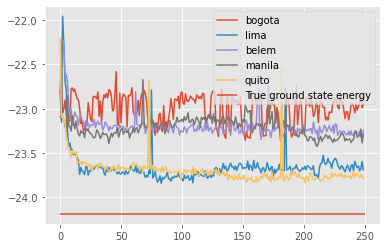

In [34]:
#plt.plot(test_santiago['loss'], label='santiago')
plt.plot(test_bogota['loss'], label='bogota')
plt.plot(test_lima['loss'], label='lima')
plt.plot(test_belem['loss'], label='belem')
plt.plot(test_manila['loss'], label='manila')
plt.plot(test_quito['loss'], label='quito')
plt.hlines(exact,0,250, label='True ground state energy')
plt.legend()

In [25]:
for backend in ["lima", "bogota", "santiago", "manila"]:
    remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=250, qfi_resamples=250, zero_params=True, backend="ibmq_"+backend)

KeyboardInterrupt: 

In [30]:
remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=250, qfi_resamples=250, zero_params=True, backend="ibmq_belem")

KeyboardInterrupt: 

runtime_job._start_websocket_client:WARNING:2021-10-26 19:00:36,169: An error occurred while streaming results from the server for job c5s3v4brrcfjv06gkitg:
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tim/anaconda3/lib/python3.7/site-packages/websocket/_app.py", line 369, in run_forever\n  